In [1]:
# Mammographic mass dataset

In [2]:
# importing packages and Libraries
# 1. Data Analysis and preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# 3: ML Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score
from collections import OrderedDict

In [3]:
#Loading dataset 
mammographic_data = pd.read_csv('mammographic mass.csv')

In [4]:
# Data Analysis and preprocessing

In [5]:
# Features, instances and data types
print("Total instances",mammographic_data.shape[0])
print("Total number of features are ", mammographic_data.shape[1])
print("Data Types:", mammographic_data.dtypes)

Total instances 830
Total number of features are  6
Data Types: BI-RADS     int64
Age         int64
Shape       int64
Margin      int64
Density     int64
Severity    int64
dtype: object


0    427
1    403
Name: Severity, dtype: int64


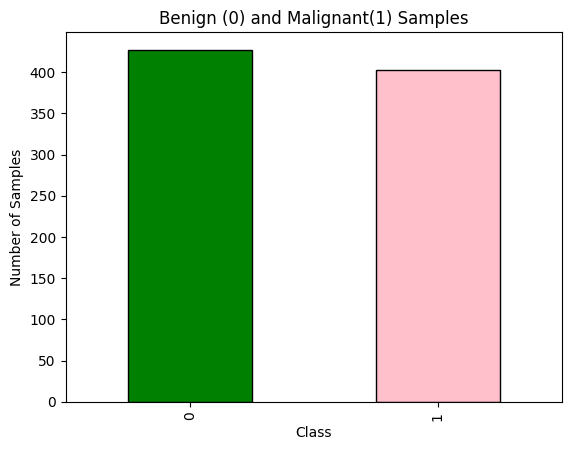

In [6]:
# Checking Class labels and distribution
class_counts = mammographic_data['Severity'].value_counts()
print(class_counts)
class_counts.plot(kind='bar', color=['green','pink'], edgecolor="black")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Benign (0) and Malignant(1) Samples")
plt.show()

In [7]:
# Checking missing values
missing_data= mammographic_data.isnull().sum()
print(missing_data)

BI-RADS     0
Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64


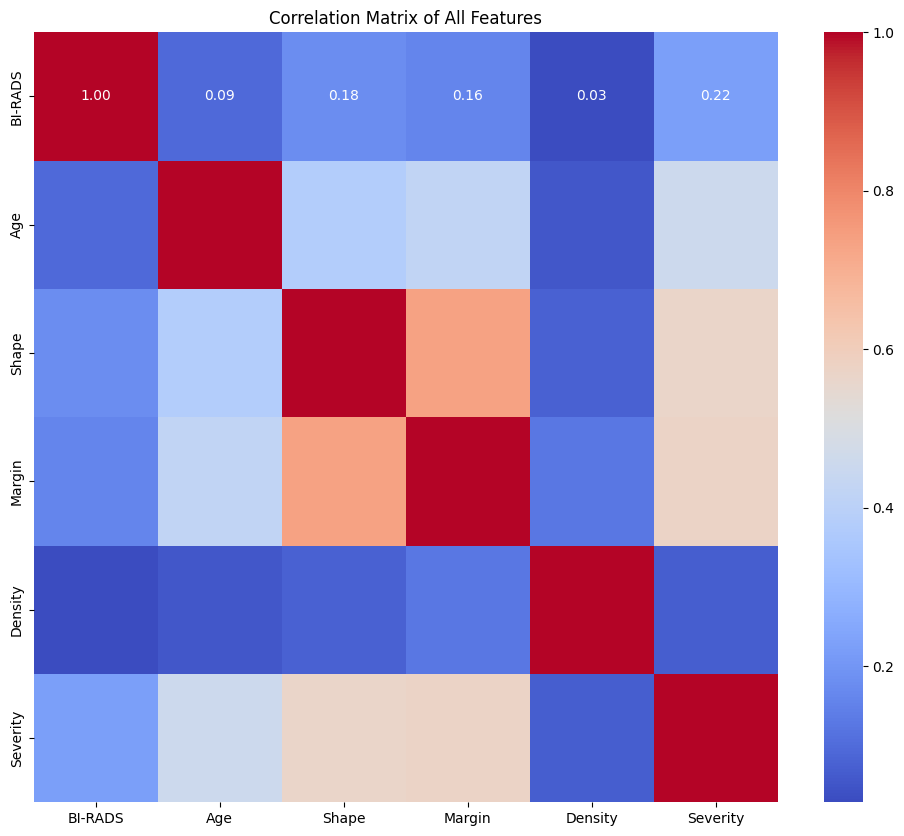

In [8]:
#Checking correlation between faetures:
correlation_matrix = mammographic_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of All Features')
plt.show()

In [9]:
correlation_threshold = 0.8
correlated_features = {}
for feature1 in correlation_matrix.columns:
    for feature2 in correlation_matrix.columns:
        if feature1 != feature2:
            correlation_value = correlation_matrix.loc[feature1, feature2]
            if abs(correlation_value) > correlation_threshold:
                if feature1 not in correlated_features:
                    correlated_features[feature1] = [feature2]
                else:
                    correlated_features[feature1].append(feature2)
for feature, correlated_list in correlated_features.items():
    print(f"{feature} is correlated with: {', '.join(correlated_list)}")

In [10]:
# Data preprocessing
# 1.NO Class label mapping required
# 2. No missing values
# 3. Feature selection- No correlated features                                  
# 4. No data imbalance handling required as dataset is balanced
# 5. Normalize data

In [11]:
clean= mammographic_data

In [12]:
#Datasplit 80:20
X =clean.drop(['Severity'], axis=1)
y =  clean['Severity']
random_state=123
feature_names = X.columns                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [13]:
#Normalizing data
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform (X_test)

In [14]:
# Ml Models Hyperparameter optimization, training ,testing, performance and Interpretability

In [15]:
# 1.DECISION TREE

# hyperpaarmeter optimization using randomized search
dt_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 5, 10, 20], 
    'min_samples_split': [2, 5, 10, 15, 20, 30, 40],
     'min_samples_leaf': [1, 2, 4]
}

search_dt = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=random_state),
    param_distributions=dt_params,  
    cv=5,
    scoring='f1',
    verbose=1
)

# DT training

search_dt.fit(X_train_scaled, y_train)
best_params = search_dt.best_params_
print("Best Parameters:", best_params)
print("Best f1 score for DT during training: ", search_dt.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'splitter': 'best', 'min_samples_split': 40, 'min_samples_leaf': 4, 'max_depth': 5, 'criterion': 'gini'}
Best f1 score for DT during training:  0.8248580687257409


In [16]:
# DT Testing
best_dt_model = search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test_scaled)

# DT performance evaluation
print("\nEvaluation Metrics for dt:")
accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_dt)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_dt)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_dt)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_dt, beta=2)
print("F2 Score:", f_beta)
auc = roc_auc_score(y_test,best_dt_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for dt:
Accuracy: 0.8192771084337349
Precision: 0.7931034482758621
Recall: 0.8518518518518519
F1 Score: 0.8214285714285715
F2 Score: 0.8394160583941606
AUC: 0.8971677559912854


In [17]:
# Test set instance 1 would be used for local interpretability
instance = X_test.iloc[0]
feature_dict = instance.to_dict()
print("Feature Dictionary:", feature_dict)

Feature Dictionary: {'BI-RADS': 4, 'Age': 47, 'Shape': 2, 'Margin': 4, 'Density': 2}


In [18]:
# as standardized data was used for model training and testing, we need to define scaled data instance for explaianbility as well
instance_to_explain = X_test_scaled[0, :].reshape(1, -1) 

In [19]:
# Model prediction and feature relevance based on decision path - Interpretability
prediction = best_dt_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")

feature_relevance = OrderedDict({feature: 0 for feature in X_test.columns.tolist()})
decision_path = best_dt_model.decision_path(instance_to_explain).toarray()
nodes_in_path = np.where(decision_path[0] == 1)[0]
for node in nodes_in_path:
    feature_index = best_dt_model.tree_.feature[node]
    if feature_index != -1 and feature_index < len(X_test.columns):
        feature_name = X_test.columns[feature_index]
        feature_relevance[feature_name] += 1

Model Prediction: 0


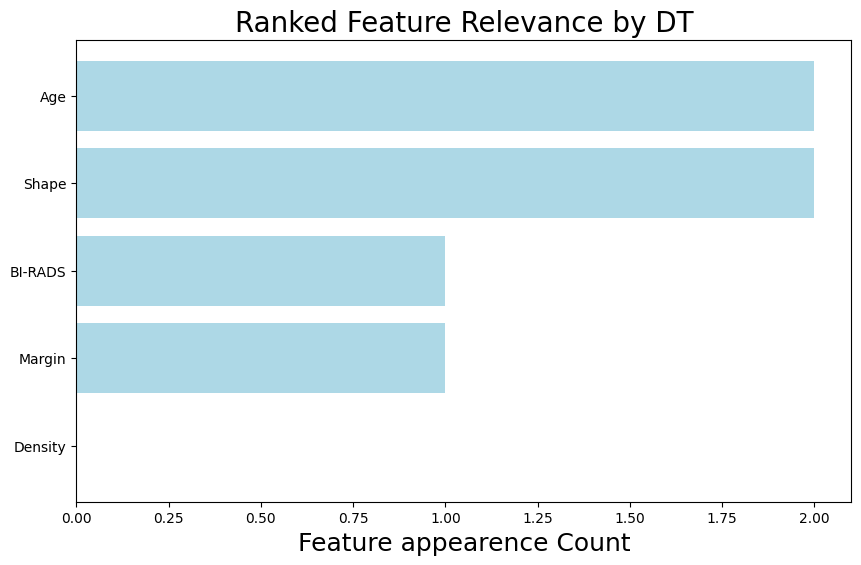

In [20]:
#visualising feature relevance by DT in descending order
sorted_feature_relevance = dict(sorted(feature_relevance.items(), key=lambda item: item[1], reverse=True))
feature_names = list(sorted_feature_relevance.keys())
feature_values = list(sorted_feature_relevance.values())
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_values, color='lightblue')
plt.xlabel("Feature appearence Count", fontsize=18)
plt.title("Ranked Feature Relevance by DT", fontsize=20)
plt.gca().invert_yaxis() 
plt.show()

In [21]:
# 2.RANDOM FOREST

# Hyperparameters optimization
param_dist = {
    'n_estimators': [10, 15, 20, 25, 30, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20, 30, 40],
    'min_samples_leaf': [1, 2, 4]
}

search_rf = RandomizedSearchCV(
     RandomForestClassifier(random_state=random_state),
     param_distributions=param_dist,
     cv=5,
     verbose=1,
    
)


# RF Training
search_rf.fit(X_train_scaled, y_train)
best_params_rf = search_rf.best_params_
print("Best Parameters for Random Forest:", best_params_rf)
print("Best f1 score for Rf during training: ", search_rf.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Random Forest: {'n_estimators': 25, 'min_samples_split': 30, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'entropy'}
Best f1 score for Rf during training:  0.8464912280701753


In [22]:
# RF testing
best_rf_model =search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)

# RF Performance Evaluation
print("\nEvaluation Metrics for Random Forest:")
accuracy= accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_rf)
print("Precision:", precision)
recall= recall_score(y_test, y_pred_rf)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_rf)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_rf, beta=2)
print("F2 Score:", f_beta)
auc= roc_auc_score(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for Random Forest:
Accuracy: 0.8313253012048193
Precision: 0.8117647058823529
Recall: 0.8518518518518519
F1 Score: 0.8313253012048193
F2 Score: 0.8435207823960879
AUC: 0.8900508351488743


In [23]:
#Model prediction and local feature importance- Interpretability
prediction = best_rf_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")
rf_feature_importances = best_rf_model.feature_importances_
sorted_indices = np.argsort(rf_feature_importances)[::-1]
sorted_features = [feature_names[idx] for idx in sorted_indices]
sorted_importances = [rf_feature_importances[idx] for idx in sorted_indices]

Model Prediction: 0


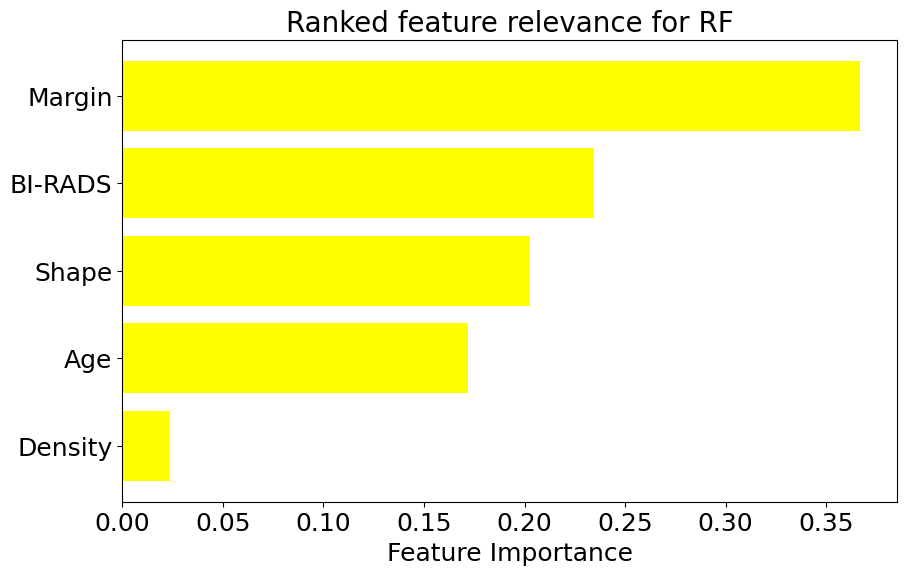

In [24]:
# Visualising feature relevance by RF
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='yellow')
plt.gca().tick_params( labelsize=18)
plt.xlabel('Feature Importance', fontsize=18 )
plt.title('Ranked feature relevance for RF', fontsize=20)
plt.gca().invert_yaxis() 
plt.show()

In [25]:
# 3. TabNet

# hyperparameter Optimization

tabnet_params = {
    'n_d': [8, 16, 32],
    'n_a': [8, 16, 32],
    'n_steps': [3, 5, 7],
    'gamma': [1.0, 1.3, 1.8],
    'lambda_sparse': [0.001, 0.005, 0.01],
}

search_tabnet = RandomizedSearchCV(
    TabNetClassifier(),
    param_distributions=tabnet_params,
    n_iter=50,
    cv=5,
    verbose=1,
    scoring='f1'
)

# TabNet Training
search_tabnet.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    max_epochs=100,
    patience=10,
    batch_size=20
)
best_params_tabnet = search_tabnet.best_params_
print("Best Parameters for TabNet:", best_params_tabnet)
print("Best f1 score for TabNet during training: ", search_tabnet.best_score_)

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
epoch 0  | loss: 0.57311 | val_0_auc: 0.84154 |  0:00:01s
epoch 1  | loss: 0.43672 | val_0_auc: 0.82266 |  0:00:02s
epoch 2  | loss: 0.40019 | val_0_auc: 0.84401 |  0:00:03s
epoch 3  | loss: 0.41964 | val_0_auc: 0.87553 |  0:00:04s
epoch 4  | loss: 0.40263 | val_0_auc: 0.86115 |  0:00:06s
epoch 5  | loss: 0.39989 | val_0_auc: 0.85795 |  0:00:07s
epoch 6  | loss: 0.38713 | val_0_auc: 0.86565 |  0:00:08s
epoch 7  | loss: 0.3823  | val_0_auc: 0.86783 |  0:00:09s
epoch 8  | loss: 0.37344 | val_0_auc: 0.86797 |  0:00:10s
epoch 9  | loss: 0.37272 | val_0_auc: 0.86362 |  0:00:12s
epoch 10 | loss: 0.39863 | val_0_auc: 0.85592 |  0:00:14s
epoch 11 | loss: 0.36131 | val_0_auc: 0.8533  |  0:00:16s
epoch 12 | loss: 0.40392 | val_0_auc: 0.86986 |  0:00:18s
epoch 13 | loss: 0.36257 | val_0_auc: 0.87219 |  0:00:20s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.87553


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56514 | val_0_auc: 0.8093  |  0:00:01s
epoch 1  | loss: 0.44014 | val_0_auc: 0.85723 |  0:00:03s
epoch 2  | loss: 0.41745 | val_0_auc: 0.73725 |  0:00:05s
epoch 3  | loss: 0.4044  | val_0_auc: 0.85534 |  0:00:07s
epoch 4  | loss: 0.38897 | val_0_auc: 0.84401 |  0:00:09s
epoch 5  | loss: 0.39833 | val_0_auc: 0.85243 |  0:00:11s
epoch 6  | loss: 0.3844  | val_0_auc: 0.86478 |  0:00:13s
epoch 7  | loss: 0.40107 | val_0_auc: 0.84096 |  0:00:15s
epoch 8  | loss: 0.38068 | val_0_auc: 0.84023 |  0:00:16s
epoch 9  | loss: 0.37899 | val_0_auc: 0.85258 |  0:00:18s
epoch 10 | loss: 0.39851 | val_0_auc: 0.84401 |  0:00:20s
epoch 11 | loss: 0.38663 | val_0_auc: 0.81206 |  0:00:22s
epoch 12 | loss: 0.39516 | val_0_auc: 0.85113 |  0:00:23s
epoch 13 | loss: 0.38582 | val_0_auc: 0.86812 |  0:00:25s
epoch 14 | loss: 0.39491 | val_0_auc: 0.87306 |  0:00:27s
epoch 15 | loss: 0.39695 | val_0_auc: 0.85229 |  0:00:29s
epoch 16 | loss: 0.38811 | val_0_auc: 0.87451 |  0:00:31s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62152 | val_0_auc: 0.7557  |  0:00:01s
epoch 1  | loss: 0.43827 | val_0_auc: 0.65599 |  0:00:03s
epoch 2  | loss: 0.4182  | val_0_auc: 0.81133 |  0:00:05s
epoch 3  | loss: 0.42518 | val_0_auc: 0.82934 |  0:00:06s
epoch 4  | loss: 0.39946 | val_0_auc: 0.85084 |  0:00:08s
epoch 5  | loss: 0.40365 | val_0_auc: 0.81786 |  0:00:10s
epoch 6  | loss: 0.42206 | val_0_auc: 0.79346 |  0:00:11s
epoch 7  | loss: 0.41264 | val_0_auc: 0.81394 |  0:00:13s
epoch 8  | loss: 0.39974 | val_0_auc: 0.8215  |  0:00:15s
epoch 9  | loss: 0.39407 | val_0_auc: 0.84444 |  0:00:16s
epoch 10 | loss: 0.37626 | val_0_auc: 0.85054 |  0:00:18s
epoch 11 | loss: 0.38355 | val_0_auc: 0.81394 |  0:00:20s
epoch 12 | loss: 0.38789 | val_0_auc: 0.86449 |  0:00:22s
epoch 13 | loss: 0.40155 | val_0_auc: 0.80566 |  0:00:23s
epoch 14 | loss: 0.39664 | val_0_auc: 0.84343 |  0:00:24s
epoch 15 | loss: 0.37712 | val_0_auc: 0.81612 |  0:00:25s
epoch 16 | loss: 0.41019 | val_0_auc: 0.83355 |  0:00:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.53574 | val_0_auc: 0.85229 |  0:00:01s
epoch 1  | loss: 0.45564 | val_0_auc: 0.77081 |  0:00:02s
epoch 2  | loss: 0.40529 | val_0_auc: 0.80871 |  0:00:04s
epoch 3  | loss: 0.42729 | val_0_auc: 0.84415 |  0:00:05s
epoch 4  | loss: 0.39361 | val_0_auc: 0.86057 |  0:00:06s
epoch 5  | loss: 0.40832 | val_0_auc: 0.83428 |  0:00:08s
epoch 6  | loss: 0.39086 | val_0_auc: 0.82861 |  0:00:09s
epoch 7  | loss: 0.42341 | val_0_auc: 0.82963 |  0:00:10s
epoch 8  | loss: 0.40444 | val_0_auc: 0.81786 |  0:00:12s
epoch 9  | loss: 0.41463 | val_0_auc: 0.84532 |  0:00:13s
epoch 10 | loss: 0.37649 | val_0_auc: 0.85664 |  0:00:14s
epoch 11 | loss: 0.38057 | val_0_auc: 0.84662 |  0:00:16s
epoch 12 | loss: 0.39452 | val_0_auc: 0.86391 |  0:00:17s
epoch 13 | loss: 0.37363 | val_0_auc: 0.86812 |  0:00:18s
epoch 14 | loss: 0.38703 | val_0_auc: 0.8671  |  0:00:20s
epoch 15 | loss: 0.38608 | val_0_auc: 0.87407 |  0:00:21s
epoch 16 | loss: 0.37682 | val_0_auc: 0.87015 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.5985  | val_0_auc: 0.84996 |  0:00:01s
epoch 1  | loss: 0.46487 | val_0_auc: 0.85505 |  0:00:02s
epoch 2  | loss: 0.42059 | val_0_auc: 0.86521 |  0:00:03s
epoch 3  | loss: 0.47464 | val_0_auc: 0.84532 |  0:00:05s
epoch 4  | loss: 0.43902 | val_0_auc: 0.81641 |  0:00:06s
epoch 5  | loss: 0.40852 | val_0_auc: 0.82702 |  0:00:07s
epoch 6  | loss: 0.40404 | val_0_auc: 0.84212 |  0:00:09s
epoch 7  | loss: 0.42437 | val_0_auc: 0.85214 |  0:00:10s
epoch 8  | loss: 0.42352 | val_0_auc: 0.85287 |  0:00:11s
epoch 9  | loss: 0.4019  | val_0_auc: 0.84691 |  0:00:13s
epoch 10 | loss: 0.41689 | val_0_auc: 0.87872 |  0:00:14s
epoch 11 | loss: 0.4091  | val_0_auc: 0.85113 |  0:00:15s
epoch 12 | loss: 0.38501 | val_0_auc: 0.87306 |  0:00:17s
epoch 13 | loss: 0.41146 | val_0_auc: 0.88366 |  0:00:18s
epoch 14 | loss: 0.41155 | val_0_auc: 0.87146 |  0:00:19s
epoch 15 | loss: 0.41169 | val_0_auc: 0.88264 |  0:00:20s
epoch 16 | loss: 0.42408 | val_0_auc: 0.86405 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61885 | val_0_auc: 0.71423 |  0:00:00s
epoch 1  | loss: 0.45942 | val_0_auc: 0.78983 |  0:00:01s
epoch 2  | loss: 0.4334  | val_0_auc: 0.87625 |  0:00:02s
epoch 3  | loss: 0.40882 | val_0_auc: 0.79753 |  0:00:03s
epoch 4  | loss: 0.39567 | val_0_auc: 0.80741 |  0:00:04s
epoch 5  | loss: 0.39898 | val_0_auc: 0.83762 |  0:00:05s
epoch 6  | loss: 0.42146 | val_0_auc: 0.81249 |  0:00:06s
epoch 7  | loss: 0.40185 | val_0_auc: 0.81336 |  0:00:07s
epoch 8  | loss: 0.36626 | val_0_auc: 0.83965 |  0:00:08s
epoch 9  | loss: 0.37229 | val_0_auc: 0.82237 |  0:00:09s
epoch 10 | loss: 0.39771 | val_0_auc: 0.79949 |  0:00:10s
epoch 11 | loss: 0.38935 | val_0_auc: 0.82977 |  0:00:11s
epoch 12 | loss: 0.38548 | val_0_auc: 0.83689 |  0:00:12s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.87625


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60178 | val_0_auc: 0.79942 |  0:00:00s
epoch 1  | loss: 0.44592 | val_0_auc: 0.79695 |  0:00:01s
epoch 2  | loss: 0.4535  | val_0_auc: 0.79753 |  0:00:02s
epoch 3  | loss: 0.44324 | val_0_auc: 0.70545 |  0:00:03s
epoch 4  | loss: 0.42136 | val_0_auc: 0.81917 |  0:00:04s
epoch 5  | loss: 0.40848 | val_0_auc: 0.7512  |  0:00:05s
epoch 6  | loss: 0.43753 | val_0_auc: 0.76943 |  0:00:06s
epoch 7  | loss: 0.40444 | val_0_auc: 0.81757 |  0:00:07s
epoch 8  | loss: 0.42432 | val_0_auc: 0.86347 |  0:00:08s
epoch 9  | loss: 0.41029 | val_0_auc: 0.86086 |  0:00:09s
epoch 10 | loss: 0.40717 | val_0_auc: 0.87349 |  0:00:09s
epoch 11 | loss: 0.40837 | val_0_auc: 0.86797 |  0:00:10s
epoch 12 | loss: 0.38194 | val_0_auc: 0.87829 |  0:00:11s
epoch 13 | loss: 0.38845 | val_0_auc: 0.87393 |  0:00:12s
epoch 14 | loss: 0.41278 | val_0_auc: 0.86739 |  0:00:13s
epoch 15 | loss: 0.39102 | val_0_auc: 0.8716  |  0:00:14s
epoch 16 | loss: 0.40288 | val_0_auc: 0.85069 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62691 | val_0_auc: 0.81816 |  0:00:00s
epoch 1  | loss: 0.46758 | val_0_auc: 0.81082 |  0:00:01s
epoch 2  | loss: 0.4356  | val_0_auc: 0.83101 |  0:00:02s
epoch 3  | loss: 0.46176 | val_0_auc: 0.82012 |  0:00:03s
epoch 4  | loss: 0.40471 | val_0_auc: 0.81816 |  0:00:04s
epoch 5  | loss: 0.42475 | val_0_auc: 0.7984  |  0:00:04s
epoch 6  | loss: 0.43698 | val_0_auc: 0.82564 |  0:00:05s
epoch 7  | loss: 0.42621 | val_0_auc: 0.82505 |  0:00:06s
epoch 8  | loss: 0.4237  | val_0_auc: 0.81961 |  0:00:07s
epoch 9  | loss: 0.40544 | val_0_auc: 0.80203 |  0:00:08s
epoch 10 | loss: 0.40095 | val_0_auc: 0.80886 |  0:00:09s
epoch 11 | loss: 0.39028 | val_0_auc: 0.79317 |  0:00:09s
epoch 12 | loss: 0.3784  | val_0_auc: 0.80661 |  0:00:10s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.83101


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60893 | val_0_auc: 0.76028 |  0:00:00s
epoch 1  | loss: 0.49727 | val_0_auc: 0.79383 |  0:00:01s
epoch 2  | loss: 0.42193 | val_0_auc: 0.79935 |  0:00:02s
epoch 3  | loss: 0.40866 | val_0_auc: 0.83021 |  0:00:03s
epoch 4  | loss: 0.40831 | val_0_auc: 0.85418 |  0:00:04s
epoch 5  | loss: 0.41774 | val_0_auc: 0.8427  |  0:00:05s
epoch 6  | loss: 0.41146 | val_0_auc: 0.8406  |  0:00:05s
epoch 7  | loss: 0.41691 | val_0_auc: 0.81743 |  0:00:06s
epoch 8  | loss: 0.40134 | val_0_auc: 0.83696 |  0:00:07s
epoch 9  | loss: 0.37516 | val_0_auc: 0.85381 |  0:00:08s
epoch 10 | loss: 0.40845 | val_0_auc: 0.8658  |  0:00:09s
epoch 11 | loss: 0.38981 | val_0_auc: 0.85149 |  0:00:10s
epoch 12 | loss: 0.36869 | val_0_auc: 0.84372 |  0:00:10s
epoch 13 | loss: 0.40247 | val_0_auc: 0.8772  |  0:00:11s
epoch 14 | loss: 0.37265 | val_0_auc: 0.87952 |  0:00:12s
epoch 15 | loss: 0.37951 | val_0_auc: 0.89027 |  0:00:13s
epoch 16 | loss: 0.38214 | val_0_auc: 0.89063 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64078 | val_0_auc: 0.74067 |  0:00:00s
epoch 1  | loss: 0.46829 | val_0_auc: 0.84771 |  0:00:01s
epoch 2  | loss: 0.4455  | val_0_auc: 0.84016 |  0:00:02s
epoch 3  | loss: 0.46222 | val_0_auc: 0.878   |  0:00:03s
epoch 4  | loss: 0.42002 | val_0_auc: 0.88642 |  0:00:04s
epoch 5  | loss: 0.43783 | val_0_auc: 0.87553 |  0:00:05s
epoch 6  | loss: 0.45272 | val_0_auc: 0.86275 |  0:00:05s
epoch 7  | loss: 0.43741 | val_0_auc: 0.8716  |  0:00:06s
epoch 8  | loss: 0.43385 | val_0_auc: 0.87393 |  0:00:07s
epoch 9  | loss: 0.41722 | val_0_auc: 0.88932 |  0:00:08s
epoch 10 | loss: 0.41141 | val_0_auc: 0.88017 |  0:00:09s
epoch 11 | loss: 0.45089 | val_0_auc: 0.87843 |  0:00:10s
epoch 12 | loss: 0.41258 | val_0_auc: 0.87829 |  0:00:10s
epoch 13 | loss: 0.41443 | val_0_auc: 0.81845 |  0:00:11s
epoch 14 | loss: 0.41005 | val_0_auc: 0.86463 |  0:00:12s
epoch 15 | loss: 0.39451 | val_0_auc: 0.86478 |  0:00:13s
epoch 16 | loss: 0.39041 | val_0_auc: 0.887   |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60026 | val_0_auc: 0.68221 |  0:00:00s
epoch 1  | loss: 0.39978 | val_0_auc: 0.8276  |  0:00:01s
epoch 2  | loss: 0.41507 | val_0_auc: 0.81496 |  0:00:02s
epoch 3  | loss: 0.41187 | val_0_auc: 0.83065 |  0:00:03s
epoch 4  | loss: 0.39369 | val_0_auc: 0.83108 |  0:00:03s
epoch 5  | loss: 0.39276 | val_0_auc: 0.83842 |  0:00:04s
epoch 6  | loss: 0.40895 | val_0_auc: 0.83936 |  0:00:05s
epoch 7  | loss: 0.3815  | val_0_auc: 0.85635 |  0:00:06s
epoch 8  | loss: 0.37484 | val_0_auc: 0.82992 |  0:00:06s
epoch 9  | loss: 0.37322 | val_0_auc: 0.84749 |  0:00:07s
epoch 10 | loss: 0.37609 | val_0_auc: 0.84139 |  0:00:08s
epoch 11 | loss: 0.4072  | val_0_auc: 0.82077 |  0:00:09s
epoch 12 | loss: 0.37982 | val_0_auc: 0.86086 |  0:00:10s
epoch 13 | loss: 0.39139 | val_0_auc: 0.86122 |  0:00:10s
epoch 14 | loss: 0.36069 | val_0_auc: 0.86282 |  0:00:11s
epoch 15 | loss: 0.3679  | val_0_auc: 0.86449 |  0:00:12s
epoch 16 | loss: 0.37307 | val_0_auc: 0.86028 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57354 | val_0_auc: 0.81554 |  0:00:00s
epoch 1  | loss: 0.458   | val_0_auc: 0.81757 |  0:00:01s
epoch 2  | loss: 0.46181 | val_0_auc: 0.84735 |  0:00:02s
epoch 3  | loss: 0.41874 | val_0_auc: 0.83747 |  0:00:03s
epoch 4  | loss: 0.42138 | val_0_auc: 0.85214 |  0:00:04s
epoch 5  | loss: 0.42179 | val_0_auc: 0.84473 |  0:00:05s
epoch 6  | loss: 0.418   | val_0_auc: 0.84749 |  0:00:05s
epoch 7  | loss: 0.39055 | val_0_auc: 0.84982 |  0:00:06s
epoch 8  | loss: 0.39625 | val_0_auc: 0.85025 |  0:00:07s
epoch 9  | loss: 0.38198 | val_0_auc: 0.8504  |  0:00:08s
epoch 10 | loss: 0.40227 | val_0_auc: 0.84503 |  0:00:09s
epoch 11 | loss: 0.40928 | val_0_auc: 0.84735 |  0:00:10s
epoch 12 | loss: 0.38362 | val_0_auc: 0.8512  |  0:00:10s
epoch 13 | loss: 0.37804 | val_0_auc: 0.85955 |  0:00:11s
epoch 14 | loss: 0.36729 | val_0_auc: 0.86565 |  0:00:12s
epoch 15 | loss: 0.37914 | val_0_auc: 0.87683 |  0:00:13s
epoch 16 | loss: 0.39103 | val_0_auc: 0.87596 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55755 | val_0_auc: 0.835   |  0:00:00s
epoch 1  | loss: 0.46118 | val_0_auc: 0.67756 |  0:00:01s
epoch 2  | loss: 0.44706 | val_0_auc: 0.79637 |  0:00:02s
epoch 3  | loss: 0.41585 | val_0_auc: 0.84009 |  0:00:03s
epoch 4  | loss: 0.41805 | val_0_auc: 0.77153 |  0:00:04s
epoch 5  | loss: 0.41339 | val_0_auc: 0.77908 |  0:00:05s
epoch 6  | loss: 0.4181  | val_0_auc: 0.83675 |  0:00:06s
epoch 7  | loss: 0.40017 | val_0_auc: 0.83791 |  0:00:07s
epoch 8  | loss: 0.41588 | val_0_auc: 0.85701 |  0:00:07s
epoch 9  | loss: 0.40823 | val_0_auc: 0.84924 |  0:00:08s
epoch 10 | loss: 0.39775 | val_0_auc: 0.83863 |  0:00:09s
epoch 11 | loss: 0.42088 | val_0_auc: 0.83776 |  0:00:10s
epoch 12 | loss: 0.40425 | val_0_auc: 0.82019 |  0:00:10s
epoch 13 | loss: 0.38714 | val_0_auc: 0.8411  |  0:00:11s
epoch 14 | loss: 0.39355 | val_0_auc: 0.84503 |  0:00:12s
epoch 15 | loss: 0.40691 | val_0_auc: 0.83094 |  0:00:13s
epoch 16 | loss: 0.39223 | val_0_auc: 0.85214 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.51513 | val_0_auc: 0.77008 |  0:00:00s
epoch 1  | loss: 0.45442 | val_0_auc: 0.72186 |  0:00:01s
epoch 2  | loss: 0.40768 | val_0_auc: 0.82208 |  0:00:02s
epoch 3  | loss: 0.40745 | val_0_auc: 0.82614 |  0:00:03s
epoch 4  | loss: 0.40744 | val_0_auc: 0.8411  |  0:00:04s
epoch 5  | loss: 0.39616 | val_0_auc: 0.8427  |  0:00:05s
epoch 6  | loss: 0.42518 | val_0_auc: 0.86638 |  0:00:06s
epoch 7  | loss: 0.39792 | val_0_auc: 0.81481 |  0:00:07s
epoch 8  | loss: 0.3847  | val_0_auc: 0.81699 |  0:00:08s
epoch 9  | loss: 0.39718 | val_0_auc: 0.8427  |  0:00:09s
epoch 10 | loss: 0.4062  | val_0_auc: 0.87335 |  0:00:10s
epoch 11 | loss: 0.38206 | val_0_auc: 0.87436 |  0:00:11s
epoch 12 | loss: 0.38749 | val_0_auc: 0.87233 |  0:00:12s
epoch 13 | loss: 0.3761  | val_0_auc: 0.89194 |  0:00:13s
epoch 14 | loss: 0.38265 | val_0_auc: 0.88853 |  0:00:14s
epoch 15 | loss: 0.41484 | val_0_auc: 0.89041 |  0:00:15s
epoch 16 | loss: 0.38238 | val_0_auc: 0.88831 |  0:00:16s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.5835  | val_0_auc: 0.81845 |  0:00:01s
epoch 1  | loss: 0.47461 | val_0_auc: 0.80595 |  0:00:02s
epoch 2  | loss: 0.45469 | val_0_auc: 0.87146 |  0:00:03s
epoch 3  | loss: 0.45632 | val_0_auc: 0.86783 |  0:00:04s
epoch 4  | loss: 0.43423 | val_0_auc: 0.82585 |  0:00:05s
epoch 5  | loss: 0.46338 | val_0_auc: 0.82803 |  0:00:06s
epoch 6  | loss: 0.44306 | val_0_auc: 0.85054 |  0:00:07s
epoch 7  | loss: 0.42656 | val_0_auc: 0.8602  |  0:00:08s
epoch 8  | loss: 0.42239 | val_0_auc: 0.82571 |  0:00:09s
epoch 9  | loss: 0.40858 | val_0_auc: 0.85418 |  0:00:10s
epoch 10 | loss: 0.44737 | val_0_auc: 0.82643 |  0:00:11s
epoch 11 | loss: 0.42189 | val_0_auc: 0.84227 |  0:00:12s
epoch 12 | loss: 0.41085 | val_0_auc: 0.84183 |  0:00:13s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.87146


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68998 | val_0_auc: 0.82963 |  0:00:01s
epoch 1  | loss: 0.57415 | val_0_auc: 0.86405 |  0:00:04s
epoch 2  | loss: 0.46889 | val_0_auc: 0.81002 |  0:00:05s
epoch 3  | loss: 0.4188  | val_0_auc: 0.64125 |  0:00:07s
epoch 4  | loss: 0.42399 | val_0_auc: 0.84473 |  0:00:09s
epoch 5  | loss: 0.40232 | val_0_auc: 0.87422 |  0:00:11s
epoch 6  | loss: 0.41118 | val_0_auc: 0.8549  |  0:00:13s
epoch 7  | loss: 0.433   | val_0_auc: 0.80276 |  0:00:14s
epoch 8  | loss: 0.37379 | val_0_auc: 0.81845 |  0:00:16s
epoch 9  | loss: 0.40779 | val_0_auc: 0.82774 |  0:00:18s
epoch 10 | loss: 0.39394 | val_0_auc: 0.81017 |  0:00:19s
epoch 11 | loss: 0.38625 | val_0_auc: 0.82876 |  0:00:21s
epoch 12 | loss: 0.39106 | val_0_auc: 0.84749 |  0:00:22s
epoch 13 | loss: 0.38568 | val_0_auc: 0.85185 |  0:00:24s
epoch 14 | loss: 0.38826 | val_0_auc: 0.83253 |  0:00:25s
epoch 15 | loss: 0.36334 | val_0_auc: 0.86449 |  0:00:27s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70975 | val_0_auc: 0.81888 |  0:00:01s
epoch 1  | loss: 0.46329 | val_0_auc: 0.84198 |  0:00:03s
epoch 2  | loss: 0.52033 | val_0_auc: 0.83253 |  0:00:04s
epoch 3  | loss: 0.41996 | val_0_auc: 0.79056 |  0:00:06s
epoch 4  | loss: 0.41975 | val_0_auc: 0.86754 |  0:00:08s
epoch 5  | loss: 0.42117 | val_0_auc: 0.85142 |  0:00:10s
epoch 6  | loss: 0.40967 | val_0_auc: 0.75904 |  0:00:12s
epoch 7  | loss: 0.46029 | val_0_auc: 0.83907 |  0:00:14s
epoch 8  | loss: 0.38593 | val_0_auc: 0.86594 |  0:00:16s
epoch 9  | loss: 0.40102 | val_0_auc: 0.85708 |  0:00:17s
epoch 10 | loss: 0.42082 | val_0_auc: 0.86086 |  0:00:19s
epoch 11 | loss: 0.41281 | val_0_auc: 0.86594 |  0:00:21s
epoch 12 | loss: 0.42027 | val_0_auc: 0.87829 |  0:00:23s
epoch 13 | loss: 0.37799 | val_0_auc: 0.878   |  0:00:25s
epoch 14 | loss: 0.39093 | val_0_auc: 0.86362 |  0:00:27s
epoch 15 | loss: 0.36701 | val_0_auc: 0.87771 |  0:00:29s
epoch 16 | loss: 0.40054 | val_0_auc: 0.87248 |  0:00:31s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79787 | val_0_auc: 0.80247 |  0:00:02s
epoch 1  | loss: 0.4834  | val_0_auc: 0.84633 |  0:00:04s
epoch 2  | loss: 0.48029 | val_0_auc: 0.86362 |  0:00:06s
epoch 3  | loss: 0.4231  | val_0_auc: 0.83558 |  0:00:08s
epoch 4  | loss: 0.46945 | val_0_auc: 0.85171 |  0:00:10s
epoch 5  | loss: 0.42414 | val_0_auc: 0.8533  |  0:00:11s
epoch 6  | loss: 0.4486  | val_0_auc: 0.86071 |  0:00:13s
epoch 7  | loss: 0.43398 | val_0_auc: 0.85359 |  0:00:15s
epoch 8  | loss: 0.37935 | val_0_auc: 0.87843 |  0:00:17s
epoch 9  | loss: 0.43089 | val_0_auc: 0.8215  |  0:00:19s
epoch 10 | loss: 0.43611 | val_0_auc: 0.826   |  0:00:21s
epoch 11 | loss: 0.43381 | val_0_auc: 0.85781 |  0:00:23s
epoch 12 | loss: 0.39938 | val_0_auc: 0.82324 |  0:00:25s
epoch 13 | loss: 0.40958 | val_0_auc: 0.83471 |  0:00:27s
epoch 14 | loss: 0.41417 | val_0_auc: 0.83268 |  0:00:28s
epoch 15 | loss: 0.39122 | val_0_auc: 0.85664 |  0:00:30s
epoch 16 | loss: 0.37313 | val_0_auc: 0.85418 |  0:00:32s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72359 | val_0_auc: 0.71344 |  0:00:01s
epoch 1  | loss: 0.46209 | val_0_auc: 0.75599 |  0:00:03s
epoch 2  | loss: 0.43633 | val_0_auc: 0.78591 |  0:00:05s
epoch 3  | loss: 0.45535 | val_0_auc: 0.85374 |  0:00:07s
epoch 4  | loss: 0.43775 | val_0_auc: 0.81002 |  0:00:09s
epoch 5  | loss: 0.42605 | val_0_auc: 0.83253 |  0:00:11s
epoch 6  | loss: 0.39809 | val_0_auc: 0.8671  |  0:00:13s
epoch 7  | loss: 0.43043 | val_0_auc: 0.85824 |  0:00:15s
epoch 8  | loss: 0.39373 | val_0_auc: 0.83137 |  0:00:16s
epoch 9  | loss: 0.38815 | val_0_auc: 0.85287 |  0:00:18s
epoch 10 | loss: 0.39487 | val_0_auc: 0.87197 |  0:00:20s
epoch 11 | loss: 0.41368 | val_0_auc: 0.87836 |  0:00:22s
epoch 12 | loss: 0.41647 | val_0_auc: 0.88141 |  0:00:24s
epoch 13 | loss: 0.37155 | val_0_auc: 0.88838 |  0:00:26s
epoch 14 | loss: 0.40354 | val_0_auc: 0.88824 |  0:00:28s
epoch 15 | loss: 0.35347 | val_0_auc: 0.8716  |  0:00:30s
epoch 16 | loss: 0.3742  | val_0_auc: 0.87233 |  0:00:32s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69546 | val_0_auc: 0.54161 |  0:00:01s
epoch 1  | loss: 0.58692 | val_0_auc: 0.84575 |  0:00:03s
epoch 2  | loss: 0.50745 | val_0_auc: 0.83224 |  0:00:05s
epoch 3  | loss: 0.48628 | val_0_auc: 0.83123 |  0:00:07s
epoch 4  | loss: 0.5094  | val_0_auc: 0.84677 |  0:00:09s
epoch 5  | loss: 0.45961 | val_0_auc: 0.85113 |  0:00:11s
epoch 6  | loss: 0.43278 | val_0_auc: 0.85563 |  0:00:13s
epoch 7  | loss: 0.45164 | val_0_auc: 0.83573 |  0:00:15s
epoch 8  | loss: 0.42564 | val_0_auc: 0.84604 |  0:00:16s
epoch 9  | loss: 0.43657 | val_0_auc: 0.86914 |  0:00:18s
epoch 10 | loss: 0.43153 | val_0_auc: 0.84285 |  0:00:20s
epoch 11 | loss: 0.40832 | val_0_auc: 0.8671  |  0:00:22s
epoch 12 | loss: 0.41469 | val_0_auc: 0.86754 |  0:00:24s
epoch 13 | loss: 0.39802 | val_0_auc: 0.87538 |  0:00:26s
epoch 14 | loss: 0.41607 | val_0_auc: 0.87771 |  0:00:28s
epoch 15 | loss: 0.40668 | val_0_auc: 0.84924 |  0:00:30s
epoch 16 | loss: 0.4081  | val_0_auc: 0.835   |  0:00:32s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55536 | val_0_auc: 0.58555 |  0:00:01s
epoch 1  | loss: 0.42516 | val_0_auc: 0.80813 |  0:00:02s
epoch 2  | loss: 0.39309 | val_0_auc: 0.78453 |  0:00:03s
epoch 3  | loss: 0.37538 | val_0_auc: 0.73958 |  0:00:04s
epoch 4  | loss: 0.39564 | val_0_auc: 0.7801  |  0:00:05s
epoch 5  | loss: 0.38758 | val_0_auc: 0.76848 |  0:00:06s
epoch 6  | loss: 0.39452 | val_0_auc: 0.76674 |  0:00:07s
epoch 7  | loss: 0.39    | val_0_auc: 0.77647 |  0:00:08s
epoch 8  | loss: 0.3681  | val_0_auc: 0.82048 |  0:00:09s
epoch 9  | loss: 0.36212 | val_0_auc: 0.83224 |  0:00:10s
epoch 10 | loss: 0.37747 | val_0_auc: 0.8459  |  0:00:12s
epoch 11 | loss: 0.36263 | val_0_auc: 0.83094 |  0:00:13s
epoch 12 | loss: 0.37199 | val_0_auc: 0.81322 |  0:00:14s
epoch 13 | loss: 0.38228 | val_0_auc: 0.84125 |  0:00:15s
epoch 14 | loss: 0.38351 | val_0_auc: 0.8321  |  0:00:16s
epoch 15 | loss: 0.37959 | val_0_auc: 0.8297  |  0:00:17s
epoch 16 | loss: 0.36482 | val_0_auc: 0.81939 |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55031 | val_0_auc: 0.76238 |  0:00:01s
epoch 1  | loss: 0.44087 | val_0_auc: 0.68446 |  0:00:02s
epoch 2  | loss: 0.41565 | val_0_auc: 0.77182 |  0:00:03s
epoch 3  | loss: 0.41863 | val_0_auc: 0.71794 |  0:00:04s
epoch 4  | loss: 0.40626 | val_0_auc: 0.67858 |  0:00:05s
epoch 5  | loss: 0.39901 | val_0_auc: 0.79012 |  0:00:06s
epoch 6  | loss: 0.41648 | val_0_auc: 0.79579 |  0:00:07s
epoch 7  | loss: 0.40346 | val_0_auc: 0.79593 |  0:00:08s
epoch 8  | loss: 0.41333 | val_0_auc: 0.84604 |  0:00:09s
epoch 9  | loss: 0.39351 | val_0_auc: 0.83994 |  0:00:10s
epoch 10 | loss: 0.39375 | val_0_auc: 0.84662 |  0:00:11s
epoch 11 | loss: 0.401   | val_0_auc: 0.85229 |  0:00:12s
epoch 12 | loss: 0.37263 | val_0_auc: 0.84183 |  0:00:13s
epoch 13 | loss: 0.39061 | val_0_auc: 0.83987 |  0:00:14s
epoch 14 | loss: 0.3916  | val_0_auc: 0.82651 |  0:00:15s
epoch 15 | loss: 0.38673 | val_0_auc: 0.78562 |  0:00:16s
epoch 16 | loss: 0.39009 | val_0_auc: 0.84466 |  0:00:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54055 | val_0_auc: 0.69288 |  0:00:00s
epoch 1  | loss: 0.48153 | val_0_auc: 0.81481 |  0:00:01s
epoch 2  | loss: 0.46248 | val_0_auc: 0.75556 |  0:00:02s
epoch 3  | loss: 0.47067 | val_0_auc: 0.83137 |  0:00:03s
epoch 4  | loss: 0.40568 | val_0_auc: 0.82135 |  0:00:04s
epoch 5  | loss: 0.42423 | val_0_auc: 0.83747 |  0:00:05s
epoch 6  | loss: 0.41112 | val_0_auc: 0.82295 |  0:00:06s
epoch 7  | loss: 0.4431  | val_0_auc: 0.81322 |  0:00:07s
epoch 8  | loss: 0.40365 | val_0_auc: 0.8398  |  0:00:08s
epoch 9  | loss: 0.39894 | val_0_auc: 0.85229 |  0:00:09s
epoch 10 | loss: 0.413   | val_0_auc: 0.84953 |  0:00:10s
epoch 11 | loss: 0.40987 | val_0_auc: 0.83631 |  0:00:11s
epoch 12 | loss: 0.39132 | val_0_auc: 0.83166 |  0:00:12s
epoch 13 | loss: 0.39895 | val_0_auc: 0.84749 |  0:00:13s
epoch 14 | loss: 0.43534 | val_0_auc: 0.83631 |  0:00:14s
epoch 15 | loss: 0.3893  | val_0_auc: 0.83341 |  0:00:15s
epoch 16 | loss: 0.38868 | val_0_auc: 0.85897 |  0:00:16s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59068 | val_0_auc: 0.79346 |  0:00:00s
epoch 1  | loss: 0.48994 | val_0_auc: 0.62876 |  0:00:02s
epoch 2  | loss: 0.46187 | val_0_auc: 0.79361 |  0:00:03s
epoch 3  | loss: 0.45016 | val_0_auc: 0.81743 |  0:00:04s
epoch 4  | loss: 0.40931 | val_0_auc: 0.84786 |  0:00:05s
epoch 5  | loss: 0.40025 | val_0_auc: 0.8549  |  0:00:06s
epoch 6  | loss: 0.38365 | val_0_auc: 0.84648 |  0:00:07s
epoch 7  | loss: 0.39407 | val_0_auc: 0.85766 |  0:00:08s
epoch 8  | loss: 0.3629  | val_0_auc: 0.86797 |  0:00:09s
epoch 9  | loss: 0.38926 | val_0_auc: 0.86797 |  0:00:10s
epoch 10 | loss: 0.39231 | val_0_auc: 0.83297 |  0:00:11s
epoch 11 | loss: 0.39328 | val_0_auc: 0.8642  |  0:00:12s
epoch 12 | loss: 0.38389 | val_0_auc: 0.87509 |  0:00:14s
epoch 13 | loss: 0.38502 | val_0_auc: 0.8703  |  0:00:15s
epoch 14 | loss: 0.37664 | val_0_auc: 0.87262 |  0:00:16s
epoch 15 | loss: 0.37874 | val_0_auc: 0.87901 |  0:00:17s
epoch 16 | loss: 0.37675 | val_0_auc: 0.8642  |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57311 | val_0_auc: 0.74408 |  0:00:01s
epoch 1  | loss: 0.45109 | val_0_auc: 0.80305 |  0:00:02s
epoch 2  | loss: 0.4236  | val_0_auc: 0.84401 |  0:00:03s
epoch 3  | loss: 0.45272 | val_0_auc: 0.8565  |  0:00:04s
epoch 4  | loss: 0.44965 | val_0_auc: 0.80537 |  0:00:05s
epoch 5  | loss: 0.43695 | val_0_auc: 0.81728 |  0:00:06s
epoch 6  | loss: 0.42379 | val_0_auc: 0.85461 |  0:00:07s
epoch 7  | loss: 0.4299  | val_0_auc: 0.8533  |  0:00:08s
epoch 8  | loss: 0.4026  | val_0_auc: 0.86296 |  0:00:10s
epoch 9  | loss: 0.4056  | val_0_auc: 0.85948 |  0:00:11s
epoch 10 | loss: 0.39314 | val_0_auc: 0.83914 |  0:00:12s
epoch 11 | loss: 0.39558 | val_0_auc: 0.77168 |  0:00:13s
epoch 12 | loss: 0.41804 | val_0_auc: 0.86115 |  0:00:14s
epoch 13 | loss: 0.40546 | val_0_auc: 0.86928 |  0:00:15s
epoch 14 | loss: 0.42247 | val_0_auc: 0.88119 |  0:00:16s
epoch 15 | loss: 0.40346 | val_0_auc: 0.85599 |  0:00:17s
epoch 16 | loss: 0.39592 | val_0_auc: 0.86863 |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61271 | val_0_auc: 0.77001 |  0:00:01s
epoch 1  | loss: 0.50645 | val_0_auc: 0.83515 |  0:00:02s
epoch 2  | loss: 0.4232  | val_0_auc: 0.79419 |  0:00:04s
epoch 3  | loss: 0.42873 | val_0_auc: 0.74713 |  0:00:05s
epoch 4  | loss: 0.41226 | val_0_auc: 0.80261 |  0:00:07s
epoch 5  | loss: 0.40554 | val_0_auc: 0.80218 |  0:00:08s
epoch 6  | loss: 0.4026  | val_0_auc: 0.80254 |  0:00:10s
epoch 7  | loss: 0.40036 | val_0_auc: 0.81794 |  0:00:11s
epoch 8  | loss: 0.39106 | val_0_auc: 0.84423 |  0:00:13s
epoch 9  | loss: 0.36557 | val_0_auc: 0.78141 |  0:00:14s
epoch 10 | loss: 0.371   | val_0_auc: 0.80566 |  0:00:16s
epoch 11 | loss: 0.36459 | val_0_auc: 0.81525 |  0:00:17s
epoch 12 | loss: 0.41083 | val_0_auc: 0.82121 |  0:00:19s
epoch 13 | loss: 0.37685 | val_0_auc: 0.82847 |  0:00:20s
epoch 14 | loss: 0.37598 | val_0_auc: 0.85664 |  0:00:21s
epoch 15 | loss: 0.37524 | val_0_auc: 0.86514 |  0:00:23s
epoch 16 | loss: 0.37842 | val_0_auc: 0.83638 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58806 | val_0_auc: 0.72484 |  0:00:01s
epoch 1  | loss: 0.42154 | val_0_auc: 0.85781 |  0:00:02s
epoch 2  | loss: 0.42098 | val_0_auc: 0.86049 |  0:00:03s
epoch 3  | loss: 0.45115 | val_0_auc: 0.86253 |  0:00:04s
epoch 4  | loss: 0.38484 | val_0_auc: 0.84038 |  0:00:05s
epoch 5  | loss: 0.38925 | val_0_auc: 0.86507 |  0:00:07s
epoch 6  | loss: 0.41915 | val_0_auc: 0.86914 |  0:00:08s
epoch 7  | loss: 0.39347 | val_0_auc: 0.87712 |  0:00:10s
epoch 8  | loss: 0.39824 | val_0_auc: 0.8626  |  0:00:11s
epoch 9  | loss: 0.38037 | val_0_auc: 0.86943 |  0:00:13s
epoch 10 | loss: 0.40317 | val_0_auc: 0.82977 |  0:00:14s
epoch 11 | loss: 0.39563 | val_0_auc: 0.86028 |  0:00:15s
epoch 12 | loss: 0.41317 | val_0_auc: 0.86696 |  0:00:17s
epoch 13 | loss: 0.40583 | val_0_auc: 0.83951 |  0:00:18s
epoch 14 | loss: 0.39318 | val_0_auc: 0.83399 |  0:00:19s
epoch 15 | loss: 0.38767 | val_0_auc: 0.87524 |  0:00:21s
epoch 16 | loss: 0.38361 | val_0_auc: 0.86921 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68199 | val_0_auc: 0.79695 |  0:00:01s
epoch 1  | loss: 0.4823  | val_0_auc: 0.78555 |  0:00:02s
epoch 2  | loss: 0.46925 | val_0_auc: 0.83021 |  0:00:04s
epoch 3  | loss: 0.4318  | val_0_auc: 0.78983 |  0:00:05s
epoch 4  | loss: 0.44475 | val_0_auc: 0.81147 |  0:00:06s
epoch 5  | loss: 0.39811 | val_0_auc: 0.81961 |  0:00:08s
epoch 6  | loss: 0.42693 | val_0_auc: 0.81198 |  0:00:09s
epoch 7  | loss: 0.39706 | val_0_auc: 0.8093  |  0:00:10s
epoch 8  | loss: 0.39704 | val_0_auc: 0.84815 |  0:00:12s
epoch 9  | loss: 0.38417 | val_0_auc: 0.82171 |  0:00:13s
epoch 10 | loss: 0.38333 | val_0_auc: 0.83755 |  0:00:14s
epoch 11 | loss: 0.38817 | val_0_auc: 0.83551 |  0:00:16s
epoch 12 | loss: 0.37889 | val_0_auc: 0.83544 |  0:00:17s
epoch 13 | loss: 0.40754 | val_0_auc: 0.84306 |  0:00:18s
epoch 14 | loss: 0.38722 | val_0_auc: 0.85381 |  0:00:19s
epoch 15 | loss: 0.36788 | val_0_auc: 0.84045 |  0:00:21s
epoch 16 | loss: 0.37809 | val_0_auc: 0.84677 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.5748  | val_0_auc: 0.8305  |  0:00:01s
epoch 1  | loss: 0.44565 | val_0_auc: 0.83086 |  0:00:02s
epoch 2  | loss: 0.45091 | val_0_auc: 0.81278 |  0:00:04s
epoch 3  | loss: 0.44121 | val_0_auc: 0.81786 |  0:00:05s
epoch 4  | loss: 0.44854 | val_0_auc: 0.80356 |  0:00:06s
epoch 5  | loss: 0.42842 | val_0_auc: 0.80806 |  0:00:08s
epoch 6  | loss: 0.40471 | val_0_auc: 0.80741 |  0:00:10s
epoch 7  | loss: 0.39452 | val_0_auc: 0.80951 |  0:00:12s
epoch 8  | loss: 0.39403 | val_0_auc: 0.80167 |  0:00:14s
epoch 9  | loss: 0.39681 | val_0_auc: 0.81518 |  0:00:16s
epoch 10 | loss: 0.403   | val_0_auc: 0.80908 |  0:00:18s
epoch 11 | loss: 0.40303 | val_0_auc: 0.84517 |  0:00:20s
epoch 12 | loss: 0.39139 | val_0_auc: 0.8146  |  0:00:23s
epoch 13 | loss: 0.40326 | val_0_auc: 0.83043 |  0:00:25s
epoch 14 | loss: 0.39513 | val_0_auc: 0.80668 |  0:00:27s
epoch 15 | loss: 0.38244 | val_0_auc: 0.8496  |  0:00:29s
epoch 16 | loss: 0.40362 | val_0_auc: 0.85301 |  0:00:31s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6566  | val_0_auc: 0.81147 |  0:00:01s
epoch 1  | loss: 0.48444 | val_0_auc: 0.73094 |  0:00:03s
epoch 2  | loss: 0.45089 | val_0_auc: 0.76463 |  0:00:05s
epoch 3  | loss: 0.43033 | val_0_auc: 0.79477 |  0:00:07s
epoch 4  | loss: 0.44435 | val_0_auc: 0.76122 |  0:00:08s
epoch 5  | loss: 0.4496  | val_0_auc: 0.80479 |  0:00:09s
epoch 6  | loss: 0.40513 | val_0_auc: 0.84263 |  0:00:11s
epoch 7  | loss: 0.42879 | val_0_auc: 0.83072 |  0:00:12s
epoch 8  | loss: 0.42874 | val_0_auc: 0.82963 |  0:00:14s
epoch 9  | loss: 0.40046 | val_0_auc: 0.83834 |  0:00:15s
epoch 10 | loss: 0.39757 | val_0_auc: 0.85541 |  0:00:16s
epoch 11 | loss: 0.41353 | val_0_auc: 0.85832 |  0:00:18s
epoch 12 | loss: 0.40553 | val_0_auc: 0.86434 |  0:00:19s
epoch 13 | loss: 0.40154 | val_0_auc: 0.87698 |  0:00:20s
epoch 14 | loss: 0.3997  | val_0_auc: 0.87967 |  0:00:22s
epoch 15 | loss: 0.39864 | val_0_auc: 0.88526 |  0:00:23s
epoch 16 | loss: 0.41854 | val_0_auc: 0.8626  |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13323 | val_0_auc: 0.82382 |  0:00:03s
epoch 1  | loss: 0.54647 | val_0_auc: 0.79492 |  0:00:06s
epoch 2  | loss: 0.57214 | val_0_auc: 0.78882 |  0:00:09s
epoch 3  | loss: 0.50802 | val_0_auc: 0.81845 |  0:00:12s
epoch 4  | loss: 0.43787 | val_0_auc: 0.82556 |  0:00:16s
epoch 5  | loss: 0.40026 | val_0_auc: 0.80305 |  0:00:19s
epoch 6  | loss: 0.41949 | val_0_auc: 0.81816 |  0:00:23s
epoch 7  | loss: 0.4137  | val_0_auc: 0.83108 |  0:00:26s
epoch 8  | loss: 0.45375 | val_0_auc: 0.84619 |  0:00:30s
epoch 9  | loss: 0.39768 | val_0_auc: 0.82876 |  0:00:33s
epoch 10 | loss: 0.39111 | val_0_auc: 0.84822 |  0:00:36s
epoch 11 | loss: 0.41574 | val_0_auc: 0.85447 |  0:00:39s
epoch 12 | loss: 0.42952 | val_0_auc: 0.84575 |  0:00:42s
epoch 13 | loss: 0.39237 | val_0_auc: 0.84444 |  0:00:45s
epoch 14 | loss: 0.40747 | val_0_auc: 0.84633 |  0:00:48s
epoch 15 | loss: 0.39506 | val_0_auc: 0.84633 |  0:00:50s
epoch 16 | loss: 0.37058 | val_0_auc: 0.8382  |  0:00:53s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.2337  | val_0_auc: 0.71816 |  0:00:02s
epoch 1  | loss: 0.74958 | val_0_auc: 0.52999 |  0:00:04s
epoch 2  | loss: 0.53487 | val_0_auc: 0.65025 |  0:00:06s
epoch 3  | loss: 0.47901 | val_0_auc: 0.80305 |  0:00:09s
epoch 4  | loss: 0.46359 | val_0_auc: 0.84633 |  0:00:12s
epoch 5  | loss: 0.43392 | val_0_auc: 0.81249 |  0:00:15s
epoch 6  | loss: 0.4273  | val_0_auc: 0.76616 |  0:00:18s
epoch 7  | loss: 0.4262  | val_0_auc: 0.83907 |  0:00:21s
epoch 8  | loss: 0.44806 | val_0_auc: 0.84473 |  0:00:23s
epoch 9  | loss: 0.4239  | val_0_auc: 0.80392 |  0:00:26s
epoch 10 | loss: 0.43039 | val_0_auc: 0.86347 |  0:00:28s
epoch 11 | loss: 0.40674 | val_0_auc: 0.85563 |  0:00:31s
epoch 12 | loss: 0.42584 | val_0_auc: 0.85113 |  0:00:34s
epoch 13 | loss: 0.45014 | val_0_auc: 0.83704 |  0:00:36s
epoch 14 | loss: 0.37993 | val_0_auc: 0.80407 |  0:00:39s
epoch 15 | loss: 0.39299 | val_0_auc: 0.81235 |  0:00:42s
epoch 16 | loss: 0.43071 | val_0_auc: 0.83529 |  0:00:45s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06735 | val_0_auc: 0.81496 |  0:00:01s
epoch 1  | loss: 0.63591 | val_0_auc: 0.75439 |  0:00:03s
epoch 2  | loss: 0.49894 | val_0_auc: 0.76834 |  0:00:04s
epoch 3  | loss: 0.45295 | val_0_auc: 0.78925 |  0:00:06s
epoch 4  | loss: 0.43428 | val_0_auc: 0.77981 |  0:00:07s
epoch 5  | loss: 0.45906 | val_0_auc: 0.81394 |  0:00:08s
epoch 6  | loss: 0.44333 | val_0_auc: 0.77182 |  0:00:10s
epoch 7  | loss: 0.42357 | val_0_auc: 0.80189 |  0:00:12s
epoch 8  | loss: 0.44968 | val_0_auc: 0.82121 |  0:00:13s
epoch 9  | loss: 0.39678 | val_0_auc: 0.81118 |  0:00:15s
epoch 10 | loss: 0.43366 | val_0_auc: 0.81874 |  0:00:16s
epoch 11 | loss: 0.39476 | val_0_auc: 0.81481 |  0:00:18s
epoch 12 | loss: 0.43183 | val_0_auc: 0.85113 |  0:00:20s
epoch 13 | loss: 0.42018 | val_0_auc: 0.83529 |  0:00:22s
epoch 14 | loss: 0.41664 | val_0_auc: 0.84938 |  0:00:24s
epoch 15 | loss: 0.39184 | val_0_auc: 0.8626  |  0:00:26s
epoch 16 | loss: 0.43888 | val_0_auc: 0.84328 |  0:00:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13162 | val_0_auc: 0.80073 |  0:00:01s
epoch 1  | loss: 0.67754 | val_0_auc: 0.7772  |  0:00:03s
epoch 2  | loss: 0.51091 | val_0_auc: 0.83268 |  0:00:04s
epoch 3  | loss: 0.51699 | val_0_auc: 0.85316 |  0:00:06s
epoch 4  | loss: 0.474   | val_0_auc: 0.85229 |  0:00:08s
epoch 5  | loss: 0.48747 | val_0_auc: 0.82672 |  0:00:09s
epoch 6  | loss: 0.41546 | val_0_auc: 0.81481 |  0:00:11s
epoch 7  | loss: 0.4371  | val_0_auc: 0.84691 |  0:00:13s
epoch 8  | loss: 0.47157 | val_0_auc: 0.84749 |  0:00:14s
epoch 9  | loss: 0.44646 | val_0_auc: 0.76412 |  0:00:16s
epoch 10 | loss: 0.50167 | val_0_auc: 0.83486 |  0:00:17s
epoch 11 | loss: 0.41775 | val_0_auc: 0.81089 |  0:00:18s
epoch 12 | loss: 0.42304 | val_0_auc: 0.85926 |  0:00:20s
epoch 13 | loss: 0.43101 | val_0_auc: 0.87466 |  0:00:22s
epoch 14 | loss: 0.42052 | val_0_auc: 0.85054 |  0:00:23s
epoch 15 | loss: 0.38268 | val_0_auc: 0.84895 |  0:00:25s
epoch 16 | loss: 0.42193 | val_0_auc: 0.85127 |  0:00:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.17224 | val_0_auc: 0.7862  |  0:00:01s
epoch 1  | loss: 0.59687 | val_0_auc: 0.7907  |  0:00:02s
epoch 2  | loss: 0.61007 | val_0_auc: 0.82338 |  0:00:04s
epoch 3  | loss: 0.53212 | val_0_auc: 0.78068 |  0:00:05s
epoch 4  | loss: 0.51592 | val_0_auc: 0.78664 |  0:00:07s
epoch 5  | loss: 0.45717 | val_0_auc: 0.84285 |  0:00:08s
epoch 6  | loss: 0.44495 | val_0_auc: 0.84328 |  0:00:10s
epoch 7  | loss: 0.45005 | val_0_auc: 0.85955 |  0:00:11s
epoch 8  | loss: 0.50335 | val_0_auc: 0.83399 |  0:00:13s
epoch 9  | loss: 0.44692 | val_0_auc: 0.83152 |  0:00:15s
epoch 10 | loss: 0.47828 | val_0_auc: 0.80697 |  0:00:16s
epoch 11 | loss: 0.44739 | val_0_auc: 0.80537 |  0:00:18s
epoch 12 | loss: 0.41698 | val_0_auc: 0.83842 |  0:00:19s
epoch 13 | loss: 0.43734 | val_0_auc: 0.83558 |  0:00:21s
epoch 14 | loss: 0.43501 | val_0_auc: 0.84858 |  0:00:23s
epoch 15 | loss: 0.42183 | val_0_auc: 0.8435  |  0:00:24s
epoch 16 | loss: 0.43682 | val_0_auc: 0.81126 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76124 | val_0_auc: 0.36035 |  0:00:01s
epoch 1  | loss: 0.79958 | val_0_auc: 0.78504 |  0:00:03s
epoch 2  | loss: 0.499   | val_0_auc: 0.8411  |  0:00:05s
epoch 3  | loss: 0.42769 | val_0_auc: 0.79201 |  0:00:06s
epoch 4  | loss: 0.43037 | val_0_auc: 0.84256 |  0:00:08s
epoch 5  | loss: 0.42012 | val_0_auc: 0.83602 |  0:00:10s
epoch 6  | loss: 0.40096 | val_0_auc: 0.82977 |  0:00:11s
epoch 7  | loss: 0.41363 | val_0_auc: 0.79506 |  0:00:13s
epoch 8  | loss: 0.42467 | val_0_auc: 0.79985 |  0:00:15s
epoch 9  | loss: 0.3862  | val_0_auc: 0.86158 |  0:00:16s
epoch 10 | loss: 0.38545 | val_0_auc: 0.86667 |  0:00:18s
epoch 11 | loss: 0.40051 | val_0_auc: 0.84444 |  0:00:20s
epoch 12 | loss: 0.40107 | val_0_auc: 0.84866 |  0:00:21s
epoch 13 | loss: 0.40075 | val_0_auc: 0.86013 |  0:00:23s
epoch 14 | loss: 0.39164 | val_0_auc: 0.8289  |  0:00:25s
epoch 15 | loss: 0.40714 | val_0_auc: 0.86754 |  0:00:26s
epoch 16 | loss: 0.38953 | val_0_auc: 0.87422 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82141 | val_0_auc: 0.75062 |  0:00:01s
epoch 1  | loss: 0.56527 | val_0_auc: 0.82898 |  0:00:03s
epoch 2  | loss: 0.51315 | val_0_auc: 0.85672 |  0:00:05s
epoch 3  | loss: 0.42913 | val_0_auc: 0.79898 |  0:00:06s
epoch 4  | loss: 0.45258 | val_0_auc: 0.81837 |  0:00:08s
epoch 5  | loss: 0.4526  | val_0_auc: 0.82266 |  0:00:10s
epoch 6  | loss: 0.40381 | val_0_auc: 0.81961 |  0:00:11s
epoch 7  | loss: 0.40768 | val_0_auc: 0.85352 |  0:00:13s
epoch 8  | loss: 0.40182 | val_0_auc: 0.8207  |  0:00:15s
epoch 9  | loss: 0.41927 | val_0_auc: 0.85069 |  0:00:16s
epoch 10 | loss: 0.39887 | val_0_auc: 0.8284  |  0:00:18s
epoch 11 | loss: 0.39931 | val_0_auc: 0.82491 |  0:00:19s
epoch 12 | loss: 0.42894 | val_0_auc: 0.82607 |  0:00:21s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.85672


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82061 | val_0_auc: 0.58315 |  0:00:01s
epoch 1  | loss: 0.54758 | val_0_auc: 0.7963  |  0:00:03s
epoch 2  | loss: 0.54267 | val_0_auc: 0.80407 |  0:00:04s
epoch 3  | loss: 0.47332 | val_0_auc: 0.85062 |  0:00:06s
epoch 4  | loss: 0.42513 | val_0_auc: 0.79513 |  0:00:08s
epoch 5  | loss: 0.42884 | val_0_auc: 0.83065 |  0:00:09s
epoch 6  | loss: 0.41981 | val_0_auc: 0.87538 |  0:00:11s
epoch 7  | loss: 0.42141 | val_0_auc: 0.85708 |  0:00:13s
epoch 8  | loss: 0.39006 | val_0_auc: 0.84691 |  0:00:15s
epoch 9  | loss: 0.39413 | val_0_auc: 0.84343 |  0:00:17s
epoch 10 | loss: 0.411   | val_0_auc: 0.85723 |  0:00:18s
epoch 11 | loss: 0.41429 | val_0_auc: 0.85795 |  0:00:20s
epoch 12 | loss: 0.40183 | val_0_auc: 0.86609 |  0:00:22s
epoch 13 | loss: 0.41245 | val_0_auc: 0.87633 |  0:00:24s
epoch 14 | loss: 0.40452 | val_0_auc: 0.87124 |  0:00:26s
epoch 15 | loss: 0.40471 | val_0_auc: 0.88134 |  0:00:27s
epoch 16 | loss: 0.3975  | val_0_auc: 0.86057 |  0:00:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.708   | val_0_auc: 0.74757 |  0:00:01s
epoch 1  | loss: 0.60551 | val_0_auc: 0.82527 |  0:00:03s
epoch 2  | loss: 0.47314 | val_0_auc: 0.84808 |  0:00:05s
epoch 3  | loss: 0.49021 | val_0_auc: 0.84619 |  0:00:06s
epoch 4  | loss: 0.42247 | val_0_auc: 0.84822 |  0:00:08s
epoch 5  | loss: 0.39962 | val_0_auc: 0.85679 |  0:00:10s
epoch 6  | loss: 0.39601 | val_0_auc: 0.83588 |  0:00:12s
epoch 7  | loss: 0.41571 | val_0_auc: 0.88526 |  0:00:13s
epoch 8  | loss: 0.41219 | val_0_auc: 0.8825  |  0:00:15s
epoch 9  | loss: 0.3902  | val_0_auc: 0.85694 |  0:00:17s
epoch 10 | loss: 0.43149 | val_0_auc: 0.87524 |  0:00:18s
epoch 11 | loss: 0.39414 | val_0_auc: 0.88046 |  0:00:20s
epoch 12 | loss: 0.39302 | val_0_auc: 0.86536 |  0:00:22s
epoch 13 | loss: 0.40281 | val_0_auc: 0.86957 |  0:00:24s
epoch 14 | loss: 0.39359 | val_0_auc: 0.87073 |  0:00:25s
epoch 15 | loss: 0.39307 | val_0_auc: 0.86478 |  0:00:27s
epoch 16 | loss: 0.38289 | val_0_auc: 0.85977 |  0:00:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7942  | val_0_auc: 0.79535 |  0:00:01s
epoch 1  | loss: 0.66344 | val_0_auc: 0.81423 |  0:00:03s
epoch 2  | loss: 0.54688 | val_0_auc: 0.3854  |  0:00:05s
epoch 3  | loss: 0.4921  | val_0_auc: 0.78381 |  0:00:07s
epoch 4  | loss: 0.45813 | val_0_auc: 0.81307 |  0:00:08s
epoch 5  | loss: 0.43374 | val_0_auc: 0.80842 |  0:00:10s
epoch 6  | loss: 0.50525 | val_0_auc: 0.79012 |  0:00:12s
epoch 7  | loss: 0.43736 | val_0_auc: 0.85534 |  0:00:13s
epoch 8  | loss: 0.42379 | val_0_auc: 0.86841 |  0:00:15s
epoch 9  | loss: 0.41233 | val_0_auc: 0.86863 |  0:00:17s
epoch 10 | loss: 0.42583 | val_0_auc: 0.87088 |  0:00:18s
epoch 11 | loss: 0.42808 | val_0_auc: 0.85185 |  0:00:20s
epoch 12 | loss: 0.45729 | val_0_auc: 0.84561 |  0:00:22s
epoch 13 | loss: 0.45507 | val_0_auc: 0.87422 |  0:00:23s
epoch 14 | loss: 0.43384 | val_0_auc: 0.86521 |  0:00:25s
epoch 15 | loss: 0.42641 | val_0_auc: 0.82498 |  0:00:27s
epoch 16 | loss: 0.442   | val_0_auc: 0.8589  |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68179 | val_0_auc: 0.66841 |  0:00:01s
epoch 1  | loss: 0.46709 | val_0_auc: 0.80487 |  0:00:02s
epoch 2  | loss: 0.52479 | val_0_auc: 0.80755 |  0:00:03s
epoch 3  | loss: 0.41576 | val_0_auc: 0.79375 |  0:00:04s
epoch 4  | loss: 0.40557 | val_0_auc: 0.80102 |  0:00:05s
epoch 5  | loss: 0.4394  | val_0_auc: 0.78838 |  0:00:06s
epoch 6  | loss: 0.42006 | val_0_auc: 0.82331 |  0:00:08s
epoch 7  | loss: 0.42159 | val_0_auc: 0.82731 |  0:00:09s
epoch 8  | loss: 0.36998 | val_0_auc: 0.85127 |  0:00:10s
epoch 9  | loss: 0.44488 | val_0_auc: 0.81307 |  0:00:11s
epoch 10 | loss: 0.39128 | val_0_auc: 0.83733 |  0:00:12s
epoch 11 | loss: 0.36935 | val_0_auc: 0.83631 |  0:00:13s
epoch 12 | loss: 0.39308 | val_0_auc: 0.83065 |  0:00:14s
epoch 13 | loss: 0.36733 | val_0_auc: 0.84285 |  0:00:16s
epoch 14 | loss: 0.37748 | val_0_auc: 0.8504  |  0:00:17s
epoch 15 | loss: 0.3932  | val_0_auc: 0.83282 |  0:00:18s
epoch 16 | loss: 0.39188 | val_0_auc: 0.84706 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71892 | val_0_auc: 0.83326 |  0:00:01s
epoch 1  | loss: 0.59549 | val_0_auc: 0.86972 |  0:00:02s
epoch 2  | loss: 0.50471 | val_0_auc: 0.88366 |  0:00:03s
epoch 3  | loss: 0.48495 | val_0_auc: 0.87248 |  0:00:04s
epoch 4  | loss: 0.4009  | val_0_auc: 0.87901 |  0:00:06s
epoch 5  | loss: 0.44933 | val_0_auc: 0.87015 |  0:00:07s
epoch 6  | loss: 0.42584 | val_0_auc: 0.87785 |  0:00:08s
epoch 7  | loss: 0.41519 | val_0_auc: 0.89078 |  0:00:09s
epoch 8  | loss: 0.40711 | val_0_auc: 0.88642 |  0:00:11s
epoch 9  | loss: 0.42489 | val_0_auc: 0.87393 |  0:00:12s
epoch 10 | loss: 0.38965 | val_0_auc: 0.88729 |  0:00:13s
epoch 11 | loss: 0.39475 | val_0_auc: 0.88322 |  0:00:14s
epoch 12 | loss: 0.41889 | val_0_auc: 0.88017 |  0:00:16s
epoch 13 | loss: 0.40075 | val_0_auc: 0.8841  |  0:00:17s
epoch 14 | loss: 0.39478 | val_0_auc: 0.86565 |  0:00:18s
epoch 15 | loss: 0.39302 | val_0_auc: 0.88293 |  0:00:20s
epoch 16 | loss: 0.40107 | val_0_auc: 0.88831 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68295 | val_0_auc: 0.86877 |  0:00:01s
epoch 1  | loss: 0.53186 | val_0_auc: 0.85635 |  0:00:02s
epoch 2  | loss: 0.5095  | val_0_auc: 0.85258 |  0:00:03s
epoch 3  | loss: 0.46008 | val_0_auc: 0.86158 |  0:00:04s
epoch 4  | loss: 0.40846 | val_0_auc: 0.79245 |  0:00:05s
epoch 5  | loss: 0.41341 | val_0_auc: 0.81525 |  0:00:07s
epoch 6  | loss: 0.4019  | val_0_auc: 0.83486 |  0:00:08s
epoch 7  | loss: 0.44366 | val_0_auc: 0.81975 |  0:00:09s
epoch 8  | loss: 0.43275 | val_0_auc: 0.84241 |  0:00:10s
epoch 9  | loss: 0.43471 | val_0_auc: 0.85389 |  0:00:11s
epoch 10 | loss: 0.45972 | val_0_auc: 0.8276  |  0:00:12s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.86877


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62159 | val_0_auc: 0.82992 |  0:00:01s
epoch 1  | loss: 0.56011 | val_0_auc: 0.73885 |  0:00:02s
epoch 2  | loss: 0.49668 | val_0_auc: 0.81133 |  0:00:03s
epoch 3  | loss: 0.44797 | val_0_auc: 0.86957 |  0:00:04s
epoch 4  | loss: 0.45116 | val_0_auc: 0.84096 |  0:00:05s
epoch 5  | loss: 0.42849 | val_0_auc: 0.8411  |  0:00:06s
epoch 6  | loss: 0.41997 | val_0_auc: 0.85185 |  0:00:08s
epoch 7  | loss: 0.40818 | val_0_auc: 0.86311 |  0:00:09s
epoch 8  | loss: 0.39472 | val_0_auc: 0.84728 |  0:00:10s
epoch 9  | loss: 0.40816 | val_0_auc: 0.8337  |  0:00:11s
epoch 10 | loss: 0.39705 | val_0_auc: 0.85512 |  0:00:12s
epoch 11 | loss: 0.40823 | val_0_auc: 0.86594 |  0:00:13s
epoch 12 | loss: 0.37118 | val_0_auc: 0.83268 |  0:00:14s
epoch 13 | loss: 0.40079 | val_0_auc: 0.83951 |  0:00:16s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.86957


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59478 | val_0_auc: 0.76209 |  0:00:01s
epoch 1  | loss: 0.56753 | val_0_auc: 0.81932 |  0:00:02s
epoch 2  | loss: 0.47011 | val_0_auc: 0.7862  |  0:00:03s
epoch 3  | loss: 0.45312 | val_0_auc: 0.85534 |  0:00:04s
epoch 4  | loss: 0.42481 | val_0_auc: 0.82295 |  0:00:05s
epoch 5  | loss: 0.45386 | val_0_auc: 0.84139 |  0:00:07s
epoch 6  | loss: 0.44433 | val_0_auc: 0.82164 |  0:00:08s
epoch 7  | loss: 0.43528 | val_0_auc: 0.80901 |  0:00:09s
epoch 8  | loss: 0.41747 | val_0_auc: 0.74365 |  0:00:10s
epoch 9  | loss: 0.42825 | val_0_auc: 0.79884 |  0:00:12s
epoch 10 | loss: 0.42291 | val_0_auc: 0.80697 |  0:00:13s
epoch 11 | loss: 0.44085 | val_0_auc: 0.80595 |  0:00:14s
epoch 12 | loss: 0.40739 | val_0_auc: 0.82542 |  0:00:15s
epoch 13 | loss: 0.40676 | val_0_auc: 0.85214 |  0:00:17s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.85534


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.52136 | val_0_auc: 0.82092 |  0:00:01s
epoch 1  | loss: 0.42998 | val_0_auc: 0.81206 |  0:00:02s
epoch 2  | loss: 0.38508 | val_0_auc: 0.78373 |  0:00:03s
epoch 3  | loss: 0.39599 | val_0_auc: 0.80901 |  0:00:04s
epoch 4  | loss: 0.38367 | val_0_auc: 0.83863 |  0:00:06s
epoch 5  | loss: 0.40242 | val_0_auc: 0.84357 |  0:00:07s
epoch 6  | loss: 0.38167 | val_0_auc: 0.85301 |  0:00:08s
epoch 7  | loss: 0.40123 | val_0_auc: 0.84212 |  0:00:09s
epoch 8  | loss: 0.38611 | val_0_auc: 0.86899 |  0:00:11s
epoch 9  | loss: 0.38343 | val_0_auc: 0.88308 |  0:00:12s
epoch 10 | loss: 0.38603 | val_0_auc: 0.85258 |  0:00:13s
epoch 11 | loss: 0.39552 | val_0_auc: 0.85868 |  0:00:14s
epoch 12 | loss: 0.38297 | val_0_auc: 0.86638 |  0:00:15s
epoch 13 | loss: 0.41367 | val_0_auc: 0.85534 |  0:00:16s
epoch 14 | loss: 0.37136 | val_0_auc: 0.86696 |  0:00:18s
epoch 15 | loss: 0.38444 | val_0_auc: 0.87669 |  0:00:19s
epoch 16 | loss: 0.36524 | val_0_auc: 0.89063 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57251 | val_0_auc: 0.86594 |  0:00:01s
epoch 1  | loss: 0.43263 | val_0_auc: 0.82963 |  0:00:02s
epoch 2  | loss: 0.39808 | val_0_auc: 0.82266 |  0:00:03s
epoch 3  | loss: 0.42506 | val_0_auc: 0.85359 |  0:00:04s
epoch 4  | loss: 0.41228 | val_0_auc: 0.83268 |  0:00:05s
epoch 5  | loss: 0.40684 | val_0_auc: 0.8459  |  0:00:07s
epoch 6  | loss: 0.40357 | val_0_auc: 0.85577 |  0:00:08s
epoch 7  | loss: 0.4316  | val_0_auc: 0.86783 |  0:00:09s
epoch 8  | loss: 0.38273 | val_0_auc: 0.86158 |  0:00:10s
epoch 9  | loss: 0.39726 | val_0_auc: 0.87131 |  0:00:11s
epoch 10 | loss: 0.39393 | val_0_auc: 0.87233 |  0:00:13s
epoch 11 | loss: 0.39619 | val_0_auc: 0.87349 |  0:00:14s
epoch 12 | loss: 0.40193 | val_0_auc: 0.87102 |  0:00:15s
epoch 13 | loss: 0.4058  | val_0_auc: 0.87734 |  0:00:16s
epoch 14 | loss: 0.38779 | val_0_auc: 0.8719  |  0:00:17s
epoch 15 | loss: 0.39907 | val_0_auc: 0.86768 |  0:00:18s
epoch 16 | loss: 0.39515 | val_0_auc: 0.89165 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54704 | val_0_auc: 0.78954 |  0:00:01s
epoch 1  | loss: 0.49958 | val_0_auc: 0.7663  |  0:00:02s
epoch 2  | loss: 0.43203 | val_0_auc: 0.79884 |  0:00:03s
epoch 3  | loss: 0.44144 | val_0_auc: 0.83253 |  0:00:04s
epoch 4  | loss: 0.39919 | val_0_auc: 0.83268 |  0:00:05s
epoch 5  | loss: 0.43272 | val_0_auc: 0.83558 |  0:00:06s
epoch 6  | loss: 0.41599 | val_0_auc: 0.84256 |  0:00:07s
epoch 7  | loss: 0.43025 | val_0_auc: 0.84793 |  0:00:08s
epoch 8  | loss: 0.39079 | val_0_auc: 0.8655  |  0:00:10s
epoch 9  | loss: 0.40883 | val_0_auc: 0.88264 |  0:00:11s
epoch 10 | loss: 0.3987  | val_0_auc: 0.88264 |  0:00:12s
epoch 11 | loss: 0.4004  | val_0_auc: 0.88903 |  0:00:13s
epoch 12 | loss: 0.40294 | val_0_auc: 0.86696 |  0:00:14s
epoch 13 | loss: 0.41921 | val_0_auc: 0.87785 |  0:00:15s
epoch 14 | loss: 0.408   | val_0_auc: 0.88787 |  0:00:16s
epoch 15 | loss: 0.40583 | val_0_auc: 0.87785 |  0:00:17s
epoch 16 | loss: 0.39922 | val_0_auc: 0.88874 |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55298 | val_0_auc: 0.81743 |  0:00:01s
epoch 1  | loss: 0.46094 | val_0_auc: 0.81975 |  0:00:02s
epoch 2  | loss: 0.39529 | val_0_auc: 0.83922 |  0:00:03s
epoch 3  | loss: 0.43854 | val_0_auc: 0.84633 |  0:00:04s
epoch 4  | loss: 0.3976  | val_0_auc: 0.83791 |  0:00:05s
epoch 5  | loss: 0.4132  | val_0_auc: 0.87378 |  0:00:06s
epoch 6  | loss: 0.42034 | val_0_auc: 0.86173 |  0:00:08s
epoch 7  | loss: 0.40083 | val_0_auc: 0.8719  |  0:00:09s
epoch 8  | loss: 0.38841 | val_0_auc: 0.86434 |  0:00:10s
epoch 9  | loss: 0.40115 | val_0_auc: 0.85374 |  0:00:11s
epoch 10 | loss: 0.38308 | val_0_auc: 0.85519 |  0:00:12s
epoch 11 | loss: 0.41279 | val_0_auc: 0.8215  |  0:00:14s
epoch 12 | loss: 0.40812 | val_0_auc: 0.85272 |  0:00:15s
epoch 13 | loss: 0.40724 | val_0_auc: 0.86376 |  0:00:16s
epoch 14 | loss: 0.41379 | val_0_auc: 0.85999 |  0:00:18s
epoch 15 | loss: 0.36501 | val_0_auc: 0.82585 |  0:00:19s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56356 | val_0_auc: 0.8337  |  0:00:01s
epoch 1  | loss: 0.46341 | val_0_auc: 0.84125 |  0:00:02s
epoch 2  | loss: 0.46215 | val_0_auc: 0.84691 |  0:00:03s
epoch 3  | loss: 0.47399 | val_0_auc: 0.85025 |  0:00:04s
epoch 4  | loss: 0.42185 | val_0_auc: 0.84764 |  0:00:06s
epoch 5  | loss: 0.44946 | val_0_auc: 0.85127 |  0:00:07s
epoch 6  | loss: 0.42932 | val_0_auc: 0.83951 |  0:00:08s
epoch 7  | loss: 0.45385 | val_0_auc: 0.87146 |  0:00:09s
epoch 8  | loss: 0.43923 | val_0_auc: 0.84386 |  0:00:10s
epoch 9  | loss: 0.43025 | val_0_auc: 0.80871 |  0:00:11s
epoch 10 | loss: 0.39955 | val_0_auc: 0.83834 |  0:00:13s
epoch 11 | loss: 0.4108  | val_0_auc: 0.79288 |  0:00:14s
epoch 12 | loss: 0.43287 | val_0_auc: 0.86943 |  0:00:15s
epoch 13 | loss: 0.42092 | val_0_auc: 0.88192 |  0:00:16s
epoch 14 | loss: 0.41248 | val_0_auc: 0.86449 |  0:00:17s
epoch 15 | loss: 0.40841 | val_0_auc: 0.8793  |  0:00:18s
epoch 16 | loss: 0.41961 | val_0_auc: 0.87277 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.5506  | val_0_auc: 0.77618 |  0:00:00s
epoch 1  | loss: 0.41956 | val_0_auc: 0.78606 |  0:00:01s
epoch 2  | loss: 0.40956 | val_0_auc: 0.8443  |  0:00:02s
epoch 3  | loss: 0.3938  | val_0_auc: 0.80886 |  0:00:02s
epoch 4  | loss: 0.40375 | val_0_auc: 0.8366  |  0:00:03s
epoch 5  | loss: 0.4018  | val_0_auc: 0.85142 |  0:00:04s
epoch 6  | loss: 0.39744 | val_0_auc: 0.85461 |  0:00:04s
epoch 7  | loss: 0.37123 | val_0_auc: 0.84343 |  0:00:05s
epoch 8  | loss: 0.38105 | val_0_auc: 0.82818 |  0:00:06s
epoch 9  | loss: 0.39532 | val_0_auc: 0.82179 |  0:00:07s
epoch 10 | loss: 0.38903 | val_0_auc: 0.81278 |  0:00:07s
epoch 11 | loss: 0.38576 | val_0_auc: 0.82469 |  0:00:08s
epoch 12 | loss: 0.38442 | val_0_auc: 0.83834 |  0:00:09s
epoch 13 | loss: 0.38457 | val_0_auc: 0.85113 |  0:00:09s
epoch 14 | loss: 0.37428 | val_0_auc: 0.84931 |  0:00:10s
epoch 15 | loss: 0.38204 | val_0_auc: 0.80857 |  0:00:11s
epoch 16 | loss: 0.3605  | val_0_auc: 0.84089 |  0:00:11s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.53143 | val_0_auc: 0.73384 |  0:00:00s
epoch 1  | loss: 0.42624 | val_0_auc: 0.85664 |  0:00:01s
epoch 2  | loss: 0.42043 | val_0_auc: 0.86565 |  0:00:02s
epoch 3  | loss: 0.38644 | val_0_auc: 0.8658  |  0:00:02s
epoch 4  | loss: 0.41098 | val_0_auc: 0.75962 |  0:00:03s
epoch 5  | loss: 0.41241 | val_0_auc: 0.85403 |  0:00:04s
epoch 6  | loss: 0.38486 | val_0_auc: 0.80668 |  0:00:05s
epoch 7  | loss: 0.40116 | val_0_auc: 0.86042 |  0:00:05s
epoch 8  | loss: 0.39463 | val_0_auc: 0.86013 |  0:00:06s
epoch 9  | loss: 0.41932 | val_0_auc: 0.85287 |  0:00:07s
epoch 10 | loss: 0.40208 | val_0_auc: 0.86231 |  0:00:07s
epoch 11 | loss: 0.39506 | val_0_auc: 0.87945 |  0:00:08s
epoch 12 | loss: 0.38976 | val_0_auc: 0.87393 |  0:00:09s
epoch 13 | loss: 0.41617 | val_0_auc: 0.87052 |  0:00:10s
epoch 14 | loss: 0.3869  | val_0_auc: 0.83624 |  0:00:11s
epoch 15 | loss: 0.40333 | val_0_auc: 0.82157 |  0:00:11s
epoch 16 | loss: 0.39197 | val_0_auc: 0.8284  |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57708 | val_0_auc: 0.83704 |  0:00:00s
epoch 1  | loss: 0.45171 | val_0_auc: 0.848   |  0:00:01s
epoch 2  | loss: 0.41859 | val_0_auc: 0.81823 |  0:00:02s
epoch 3  | loss: 0.42941 | val_0_auc: 0.83508 |  0:00:03s
epoch 4  | loss: 0.41278 | val_0_auc: 0.8549  |  0:00:04s
epoch 5  | loss: 0.39918 | val_0_auc: 0.85156 |  0:00:05s
epoch 6  | loss: 0.40412 | val_0_auc: 0.82077 |  0:00:05s
epoch 7  | loss: 0.4163  | val_0_auc: 0.85359 |  0:00:06s
epoch 8  | loss: 0.41815 | val_0_auc: 0.85229 |  0:00:07s
epoch 9  | loss: 0.39207 | val_0_auc: 0.86173 |  0:00:08s
epoch 10 | loss: 0.38085 | val_0_auc: 0.8642  |  0:00:09s
epoch 11 | loss: 0.37729 | val_0_auc: 0.83021 |  0:00:09s
epoch 12 | loss: 0.3869  | val_0_auc: 0.87393 |  0:00:10s
epoch 13 | loss: 0.39051 | val_0_auc: 0.887   |  0:00:11s
epoch 14 | loss: 0.41494 | val_0_auc: 0.8732  |  0:00:12s
epoch 15 | loss: 0.42748 | val_0_auc: 0.84488 |  0:00:13s
epoch 16 | loss: 0.39967 | val_0_auc: 0.83253 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.53936 | val_0_auc: 0.82375 |  0:00:00s
epoch 1  | loss: 0.47923 | val_0_auc: 0.84147 |  0:00:01s
epoch 2  | loss: 0.41449 | val_0_auc: 0.82709 |  0:00:02s
epoch 3  | loss: 0.40362 | val_0_auc: 0.81678 |  0:00:03s
epoch 4  | loss: 0.43084 | val_0_auc: 0.83108 |  0:00:04s
epoch 5  | loss: 0.39591 | val_0_auc: 0.82469 |  0:00:04s
epoch 6  | loss: 0.39535 | val_0_auc: 0.79237 |  0:00:05s
epoch 7  | loss: 0.42016 | val_0_auc: 0.81656 |  0:00:06s
epoch 8  | loss: 0.40397 | val_0_auc: 0.80516 |  0:00:07s
epoch 9  | loss: 0.3842  | val_0_auc: 0.8366  |  0:00:08s
epoch 10 | loss: 0.38011 | val_0_auc: 0.86507 |  0:00:08s
epoch 11 | loss: 0.38055 | val_0_auc: 0.86028 |  0:00:09s
epoch 12 | loss: 0.36741 | val_0_auc: 0.85287 |  0:00:10s
epoch 13 | loss: 0.36812 | val_0_auc: 0.86935 |  0:00:11s
epoch 14 | loss: 0.38827 | val_0_auc: 0.87487 |  0:00:11s
epoch 15 | loss: 0.38851 | val_0_auc: 0.85977 |  0:00:12s
epoch 16 | loss: 0.37731 | val_0_auc: 0.85715 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61193 | val_0_auc: 0.84924 |  0:00:00s
epoch 1  | loss: 0.44023 | val_0_auc: 0.8947  |  0:00:01s
epoch 2  | loss: 0.40011 | val_0_auc: 0.85969 |  0:00:02s
epoch 3  | loss: 0.40688 | val_0_auc: 0.86609 |  0:00:03s
epoch 4  | loss: 0.4238  | val_0_auc: 0.83718 |  0:00:03s
epoch 5  | loss: 0.43463 | val_0_auc: 0.81692 |  0:00:04s
epoch 6  | loss: 0.45025 | val_0_auc: 0.83195 |  0:00:05s
epoch 7  | loss: 0.41091 | val_0_auc: 0.84561 |  0:00:06s
epoch 8  | loss: 0.44104 | val_0_auc: 0.83537 |  0:00:06s
epoch 9  | loss: 0.40938 | val_0_auc: 0.8191  |  0:00:07s
epoch 10 | loss: 0.40862 | val_0_auc: 0.81954 |  0:00:08s
epoch 11 | loss: 0.43081 | val_0_auc: 0.84975 |  0:00:09s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.8947


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57066 | val_0_auc: 0.86224 |  0:00:00s
epoch 1  | loss: 0.43625 | val_0_auc: 0.84967 |  0:00:01s
epoch 2  | loss: 0.40352 | val_0_auc: 0.82266 |  0:00:02s
epoch 3  | loss: 0.39808 | val_0_auc: 0.82426 |  0:00:03s
epoch 4  | loss: 0.39061 | val_0_auc: 0.79971 |  0:00:04s
epoch 5  | loss: 0.3893  | val_0_auc: 0.83544 |  0:00:05s
epoch 6  | loss: 0.37108 | val_0_auc: 0.84227 |  0:00:06s
epoch 7  | loss: 0.38524 | val_0_auc: 0.83355 |  0:00:06s
epoch 8  | loss: 0.36548 | val_0_auc: 0.84277 |  0:00:07s
epoch 9  | loss: 0.37776 | val_0_auc: 0.82317 |  0:00:08s
epoch 10 | loss: 0.36748 | val_0_auc: 0.84633 |  0:00:09s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.86224


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57009 | val_0_auc: 0.85142 |  0:00:00s
epoch 1  | loss: 0.46262 | val_0_auc: 0.75861 |  0:00:01s
epoch 2  | loss: 0.46368 | val_0_auc: 0.79855 |  0:00:02s
epoch 3  | loss: 0.45868 | val_0_auc: 0.85897 |  0:00:03s
epoch 4  | loss: 0.43094 | val_0_auc: 0.83413 |  0:00:04s
epoch 5  | loss: 0.43604 | val_0_auc: 0.86129 |  0:00:05s
epoch 6  | loss: 0.42759 | val_0_auc: 0.86042 |  0:00:06s
epoch 7  | loss: 0.41259 | val_0_auc: 0.84517 |  0:00:07s
epoch 8  | loss: 0.42083 | val_0_auc: 0.82121 |  0:00:07s
epoch 9  | loss: 0.39273 | val_0_auc: 0.86035 |  0:00:08s
epoch 10 | loss: 0.39366 | val_0_auc: 0.8467  |  0:00:09s
epoch 11 | loss: 0.39162 | val_0_auc: 0.85447 |  0:00:10s
epoch 12 | loss: 0.37005 | val_0_auc: 0.85592 |  0:00:11s
epoch 13 | loss: 0.37441 | val_0_auc: 0.84386 |  0:00:12s
epoch 14 | loss: 0.40517 | val_0_auc: 0.84401 |  0:00:13s
epoch 15 | loss: 0.40052 | val_0_auc: 0.86078 |  0:00:14s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55238 | val_0_auc: 0.69731 |  0:00:00s
epoch 1  | loss: 0.50995 | val_0_auc: 0.8191  |  0:00:01s
epoch 2  | loss: 0.49671 | val_0_auc: 0.83813 |  0:00:02s
epoch 3  | loss: 0.4535  | val_0_auc: 0.82796 |  0:00:03s
epoch 4  | loss: 0.44272 | val_0_auc: 0.84248 |  0:00:04s
epoch 5  | loss: 0.42132 | val_0_auc: 0.82338 |  0:00:05s
epoch 6  | loss: 0.44193 | val_0_auc: 0.82193 |  0:00:06s
epoch 7  | loss: 0.42605 | val_0_auc: 0.83057 |  0:00:07s
epoch 8  | loss: 0.40622 | val_0_auc: 0.82331 |  0:00:07s
epoch 9  | loss: 0.40915 | val_0_auc: 0.83413 |  0:00:08s
epoch 10 | loss: 0.43242 | val_0_auc: 0.85933 |  0:00:09s
epoch 11 | loss: 0.39794 | val_0_auc: 0.86964 |  0:00:10s
epoch 12 | loss: 0.39092 | val_0_auc: 0.87066 |  0:00:11s
epoch 13 | loss: 0.40161 | val_0_auc: 0.85178 |  0:00:12s
epoch 14 | loss: 0.41957 | val_0_auc: 0.87124 |  0:00:13s
epoch 15 | loss: 0.39049 | val_0_auc: 0.87328 |  0:00:13s
epoch 16 | loss: 0.41175 | val_0_auc: 0.8435  |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59046 | val_0_auc: 0.68838 |  0:00:00s
epoch 1  | loss: 0.46104 | val_0_auc: 0.81256 |  0:00:01s
epoch 2  | loss: 0.42368 | val_0_auc: 0.79949 |  0:00:02s
epoch 3  | loss: 0.43133 | val_0_auc: 0.81278 |  0:00:03s
epoch 4  | loss: 0.42741 | val_0_auc: 0.81852 |  0:00:03s
epoch 5  | loss: 0.42286 | val_0_auc: 0.78453 |  0:00:04s
epoch 6  | loss: 0.40002 | val_0_auc: 0.81394 |  0:00:05s
epoch 7  | loss: 0.42993 | val_0_auc: 0.80218 |  0:00:06s
epoch 8  | loss: 0.37702 | val_0_auc: 0.81365 |  0:00:07s
epoch 9  | loss: 0.41325 | val_0_auc: 0.78555 |  0:00:07s
epoch 10 | loss: 0.42309 | val_0_auc: 0.80465 |  0:00:08s
epoch 11 | loss: 0.41186 | val_0_auc: 0.82077 |  0:00:09s
epoch 12 | loss: 0.38927 | val_0_auc: 0.82716 |  0:00:10s
epoch 13 | loss: 0.3787  | val_0_auc: 0.81147 |  0:00:11s
epoch 14 | loss: 0.39578 | val_0_auc: 0.82614 |  0:00:11s
epoch 15 | loss: 0.38718 | val_0_auc: 0.83711 |  0:00:12s
epoch 16 | loss: 0.38213 | val_0_auc: 0.83834 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.5887  | val_0_auc: 0.82135 |  0:00:00s
epoch 1  | loss: 0.47033 | val_0_auc: 0.77676 |  0:00:01s
epoch 2  | loss: 0.43948 | val_0_auc: 0.78286 |  0:00:02s
epoch 3  | loss: 0.45578 | val_0_auc: 0.80712 |  0:00:03s
epoch 4  | loss: 0.46658 | val_0_auc: 0.83522 |  0:00:04s
epoch 5  | loss: 0.42581 | val_0_auc: 0.8321  |  0:00:05s
epoch 6  | loss: 0.4354  | val_0_auc: 0.84837 |  0:00:06s
epoch 7  | loss: 0.44276 | val_0_auc: 0.84524 |  0:00:07s
epoch 8  | loss: 0.42868 | val_0_auc: 0.86405 |  0:00:08s
epoch 9  | loss: 0.39837 | val_0_auc: 0.86325 |  0:00:08s
epoch 10 | loss: 0.42621 | val_0_auc: 0.85207 |  0:00:09s
epoch 11 | loss: 0.40309 | val_0_auc: 0.86173 |  0:00:10s
epoch 12 | loss: 0.42405 | val_0_auc: 0.87698 |  0:00:11s
epoch 13 | loss: 0.416   | val_0_auc: 0.85955 |  0:00:12s
epoch 14 | loss: 0.42885 | val_0_auc: 0.86696 |  0:00:12s
epoch 15 | loss: 0.41203 | val_0_auc: 0.87233 |  0:00:13s
epoch 16 | loss: 0.40547 | val_0_auc: 0.88729 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64452 | val_0_auc: 0.78126 |  0:00:01s
epoch 1  | loss: 0.48041 | val_0_auc: 0.82033 |  0:00:03s
epoch 2  | loss: 0.47897 | val_0_auc: 0.76412 |  0:00:04s
epoch 3  | loss: 0.4277  | val_0_auc: 0.79172 |  0:00:06s
epoch 4  | loss: 0.41335 | val_0_auc: 0.7833  |  0:00:08s
epoch 5  | loss: 0.41914 | val_0_auc: 0.80813 |  0:00:09s
epoch 6  | loss: 0.40847 | val_0_auc: 0.84706 |  0:00:11s
epoch 7  | loss: 0.46231 | val_0_auc: 0.78765 |  0:00:13s
epoch 8  | loss: 0.38314 | val_0_auc: 0.84982 |  0:00:14s
epoch 9  | loss: 0.39949 | val_0_auc: 0.82789 |  0:00:16s
epoch 10 | loss: 0.40895 | val_0_auc: 0.8398  |  0:00:18s
epoch 11 | loss: 0.38627 | val_0_auc: 0.80102 |  0:00:20s
epoch 12 | loss: 0.38368 | val_0_auc: 0.84459 |  0:00:22s
epoch 13 | loss: 0.40438 | val_0_auc: 0.82062 |  0:00:24s
epoch 14 | loss: 0.39394 | val_0_auc: 0.83413 |  0:00:25s
epoch 15 | loss: 0.36674 | val_0_auc: 0.84488 |  0:00:27s
epoch 16 | loss: 0.40975 | val_0_auc: 0.85272 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71351 | val_0_auc: 0.64866 |  0:00:01s
epoch 1  | loss: 0.47351 | val_0_auc: 0.67814 |  0:00:03s
epoch 2  | loss: 0.50691 | val_0_auc: 0.81344 |  0:00:04s
epoch 3  | loss: 0.4067  | val_0_auc: 0.8687  |  0:00:06s
epoch 4  | loss: 0.41268 | val_0_auc: 0.83275 |  0:00:08s
epoch 5  | loss: 0.41591 | val_0_auc: 0.86638 |  0:00:09s
epoch 6  | loss: 0.39159 | val_0_auc: 0.87422 |  0:00:11s
epoch 7  | loss: 0.45498 | val_0_auc: 0.86565 |  0:00:13s
epoch 8  | loss: 0.39276 | val_0_auc: 0.86057 |  0:00:14s
epoch 9  | loss: 0.41161 | val_0_auc: 0.87131 |  0:00:16s
epoch 10 | loss: 0.42527 | val_0_auc: 0.88504 |  0:00:17s
epoch 11 | loss: 0.4163  | val_0_auc: 0.86275 |  0:00:19s
epoch 12 | loss: 0.39769 | val_0_auc: 0.84771 |  0:00:20s
epoch 13 | loss: 0.37287 | val_0_auc: 0.86434 |  0:00:22s
epoch 14 | loss: 0.39479 | val_0_auc: 0.85664 |  0:00:23s
epoch 15 | loss: 0.371   | val_0_auc: 0.85069 |  0:00:25s
epoch 16 | loss: 0.39694 | val_0_auc: 0.87146 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76986 | val_0_auc: 0.87364 |  0:00:01s
epoch 1  | loss: 0.49684 | val_0_auc: 0.7695  |  0:00:03s
epoch 2  | loss: 0.50229 | val_0_auc: 0.84532 |  0:00:04s
epoch 3  | loss: 0.41259 | val_0_auc: 0.75527 |  0:00:06s
epoch 4  | loss: 0.45346 | val_0_auc: 0.82992 |  0:00:08s
epoch 5  | loss: 0.42796 | val_0_auc: 0.85752 |  0:00:09s
epoch 6  | loss: 0.41753 | val_0_auc: 0.82498 |  0:00:11s
epoch 7  | loss: 0.45705 | val_0_auc: 0.79375 |  0:00:13s
epoch 8  | loss: 0.3789  | val_0_auc: 0.86826 |  0:00:15s
epoch 9  | loss: 0.40549 | val_0_auc: 0.84779 |  0:00:17s
epoch 10 | loss: 0.39499 | val_0_auc: 0.8337  |  0:00:18s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.87364


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71463 | val_0_auc: 0.60523 |  0:00:01s
epoch 1  | loss: 0.46673 | val_0_auc: 0.8199  |  0:00:03s
epoch 2  | loss: 0.46752 | val_0_auc: 0.81975 |  0:00:05s
epoch 3  | loss: 0.41717 | val_0_auc: 0.78272 |  0:00:06s
epoch 4  | loss: 0.44266 | val_0_auc: 0.83805 |  0:00:08s
epoch 5  | loss: 0.41389 | val_0_auc: 0.70153 |  0:00:10s
epoch 6  | loss: 0.41334 | val_0_auc: 0.75512 |  0:00:11s
epoch 7  | loss: 0.40964 | val_0_auc: 0.85853 |  0:00:12s
epoch 8  | loss: 0.38907 | val_0_auc: 0.85069 |  0:00:14s
epoch 9  | loss: 0.37618 | val_0_auc: 0.8504  |  0:00:15s
epoch 10 | loss: 0.41435 | val_0_auc: 0.83253 |  0:00:17s
epoch 11 | loss: 0.45285 | val_0_auc: 0.83551 |  0:00:18s
epoch 12 | loss: 0.41258 | val_0_auc: 0.82963 |  0:00:20s
epoch 13 | loss: 0.3756  | val_0_auc: 0.85047 |  0:00:21s
epoch 14 | loss: 0.42419 | val_0_auc: 0.8687  |  0:00:23s
epoch 15 | loss: 0.38125 | val_0_auc: 0.85657 |  0:00:24s
epoch 16 | loss: 0.39403 | val_0_auc: 0.85933 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73872 | val_0_auc: 0.76601 |  0:00:01s
epoch 1  | loss: 0.54129 | val_0_auc: 0.71888 |  0:00:03s
epoch 2  | loss: 0.48884 | val_0_auc: 0.76296 |  0:00:04s
epoch 3  | loss: 0.46313 | val_0_auc: 0.80922 |  0:00:06s
epoch 4  | loss: 0.49178 | val_0_auc: 0.80566 |  0:00:07s
epoch 5  | loss: 0.46184 | val_0_auc: 0.82019 |  0:00:09s
epoch 6  | loss: 0.43258 | val_0_auc: 0.80261 |  0:00:10s
epoch 7  | loss: 0.44133 | val_0_auc: 0.82905 |  0:00:12s
epoch 8  | loss: 0.4319  | val_0_auc: 0.84372 |  0:00:13s
epoch 9  | loss: 0.43744 | val_0_auc: 0.83842 |  0:00:15s
epoch 10 | loss: 0.41901 | val_0_auc: 0.85563 |  0:00:16s
epoch 11 | loss: 0.41791 | val_0_auc: 0.85476 |  0:00:18s
epoch 12 | loss: 0.40907 | val_0_auc: 0.84619 |  0:00:19s
epoch 13 | loss: 0.3973  | val_0_auc: 0.86028 |  0:00:21s
epoch 14 | loss: 0.43164 | val_0_auc: 0.84401 |  0:00:22s
epoch 15 | loss: 0.42826 | val_0_auc: 0.8305  |  0:00:24s
epoch 16 | loss: 0.42404 | val_0_auc: 0.86173 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55985 | val_0_auc: 0.79942 |  0:00:00s
epoch 1  | loss: 0.38174 | val_0_auc: 0.84256 |  0:00:01s
epoch 2  | loss: 0.39789 | val_0_auc: 0.85773 |  0:00:02s
epoch 3  | loss: 0.38382 | val_0_auc: 0.86195 |  0:00:03s
epoch 4  | loss: 0.41007 | val_0_auc: 0.85091 |  0:00:03s
epoch 5  | loss: 0.39826 | val_0_auc: 0.84103 |  0:00:04s
epoch 6  | loss: 0.37241 | val_0_auc: 0.8345  |  0:00:05s
epoch 7  | loss: 0.38416 | val_0_auc: 0.8374  |  0:00:05s
epoch 8  | loss: 0.36562 | val_0_auc: 0.85272 |  0:00:06s
epoch 9  | loss: 0.39696 | val_0_auc: 0.86681 |  0:00:07s
epoch 10 | loss: 0.38429 | val_0_auc: 0.87698 |  0:00:08s
epoch 11 | loss: 0.36466 | val_0_auc: 0.88932 |  0:00:08s
epoch 12 | loss: 0.39066 | val_0_auc: 0.87117 |  0:00:09s
epoch 13 | loss: 0.37105 | val_0_auc: 0.87044 |  0:00:10s
epoch 14 | loss: 0.36937 | val_0_auc: 0.88279 |  0:00:11s
epoch 15 | loss: 0.37156 | val_0_auc: 0.88126 |  0:00:11s
epoch 16 | loss: 0.36672 | val_0_auc: 0.8533  |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.53834 | val_0_auc: 0.82854 |  0:00:00s
epoch 1  | loss: 0.44216 | val_0_auc: 0.79129 |  0:00:01s
epoch 2  | loss: 0.41271 | val_0_auc: 0.81235 |  0:00:02s
epoch 3  | loss: 0.42467 | val_0_auc: 0.83544 |  0:00:03s
epoch 4  | loss: 0.42671 | val_0_auc: 0.85679 |  0:00:03s
epoch 5  | loss: 0.40967 | val_0_auc: 0.8398  |  0:00:04s
epoch 6  | loss: 0.40136 | val_0_auc: 0.83123 |  0:00:05s
epoch 7  | loss: 0.40909 | val_0_auc: 0.86245 |  0:00:06s
epoch 8  | loss: 0.39729 | val_0_auc: 0.84343 |  0:00:07s
epoch 9  | loss: 0.40415 | val_0_auc: 0.8398  |  0:00:07s
epoch 10 | loss: 0.40806 | val_0_auc: 0.81365 |  0:00:08s
epoch 11 | loss: 0.40016 | val_0_auc: 0.83602 |  0:00:09s
epoch 12 | loss: 0.38602 | val_0_auc: 0.87204 |  0:00:09s
epoch 13 | loss: 0.41575 | val_0_auc: 0.87669 |  0:00:10s
epoch 14 | loss: 0.39025 | val_0_auc: 0.85737 |  0:00:11s
epoch 15 | loss: 0.40497 | val_0_auc: 0.8642  |  0:00:12s
epoch 16 | loss: 0.37952 | val_0_auc: 0.85948 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58451 | val_0_auc: 0.8342  |  0:00:00s
epoch 1  | loss: 0.49178 | val_0_auc: 0.86231 |  0:00:01s
epoch 2  | loss: 0.4116  | val_0_auc: 0.8366  |  0:00:02s
epoch 3  | loss: 0.40556 | val_0_auc: 0.81917 |  0:00:02s
epoch 4  | loss: 0.40865 | val_0_auc: 0.848   |  0:00:03s
epoch 5  | loss: 0.40807 | val_0_auc: 0.82004 |  0:00:04s
epoch 6  | loss: 0.41034 | val_0_auc: 0.82571 |  0:00:05s
epoch 7  | loss: 0.41808 | val_0_auc: 0.8045  |  0:00:06s
epoch 8  | loss: 0.43095 | val_0_auc: 0.81656 |  0:00:06s
epoch 9  | loss: 0.39915 | val_0_auc: 0.81757 |  0:00:07s
epoch 10 | loss: 0.38574 | val_0_auc: 0.83297 |  0:00:08s
epoch 11 | loss: 0.39328 | val_0_auc: 0.83079 |  0:00:09s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.86231


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.52663 | val_0_auc: 0.85301 |  0:00:00s
epoch 1  | loss: 0.47171 | val_0_auc: 0.83079 |  0:00:01s
epoch 2  | loss: 0.44397 | val_0_auc: 0.81278 |  0:00:02s
epoch 3  | loss: 0.39836 | val_0_auc: 0.77023 |  0:00:03s
epoch 4  | loss: 0.42866 | val_0_auc: 0.7939  |  0:00:03s
epoch 5  | loss: 0.41119 | val_0_auc: 0.83675 |  0:00:04s
epoch 6  | loss: 0.40638 | val_0_auc: 0.81474 |  0:00:05s
epoch 7  | loss: 0.43584 | val_0_auc: 0.80574 |  0:00:06s
epoch 8  | loss: 0.42088 | val_0_auc: 0.84031 |  0:00:07s
epoch 9  | loss: 0.39075 | val_0_auc: 0.86797 |  0:00:07s
epoch 10 | loss: 0.37208 | val_0_auc: 0.88112 |  0:00:08s
epoch 11 | loss: 0.39148 | val_0_auc: 0.86187 |  0:00:09s
epoch 12 | loss: 0.38044 | val_0_auc: 0.85723 |  0:00:10s
epoch 13 | loss: 0.39506 | val_0_auc: 0.84713 |  0:00:10s
epoch 14 | loss: 0.3967  | val_0_auc: 0.84132 |  0:00:11s
epoch 15 | loss: 0.4021  | val_0_auc: 0.88184 |  0:00:13s
epoch 16 | loss: 0.37349 | val_0_auc: 0.88301 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61727 | val_0_auc: 0.81017 |  0:00:00s
epoch 1  | loss: 0.46373 | val_0_auc: 0.82498 |  0:00:01s
epoch 2  | loss: 0.42243 | val_0_auc: 0.77858 |  0:00:02s
epoch 3  | loss: 0.43182 | val_0_auc: 0.81511 |  0:00:03s
epoch 4  | loss: 0.39922 | val_0_auc: 0.88148 |  0:00:03s
epoch 5  | loss: 0.40025 | val_0_auc: 0.8854  |  0:00:04s
epoch 6  | loss: 0.43189 | val_0_auc: 0.87567 |  0:00:05s
epoch 7  | loss: 0.3885  | val_0_auc: 0.86318 |  0:00:06s
epoch 8  | loss: 0.40952 | val_0_auc: 0.8719  |  0:00:06s
epoch 9  | loss: 0.40709 | val_0_auc: 0.86732 |  0:00:07s
epoch 10 | loss: 0.40512 | val_0_auc: 0.87226 |  0:00:08s
epoch 11 | loss: 0.42471 | val_0_auc: 0.88707 |  0:00:08s
epoch 12 | loss: 0.40844 | val_0_auc: 0.84757 |  0:00:09s
epoch 13 | loss: 0.40662 | val_0_auc: 0.85229 |  0:00:10s
epoch 14 | loss: 0.40155 | val_0_auc: 0.86071 |  0:00:11s
epoch 15 | loss: 0.40632 | val_0_auc: 0.8902  |  0:00:11s
epoch 16 | loss: 0.3848  | val_0_auc: 0.87959 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67491 | val_0_auc: 0.76732 |  0:00:01s
epoch 1  | loss: 0.56773 | val_0_auc: 0.83137 |  0:00:02s
epoch 2  | loss: 0.46249 | val_0_auc: 0.83065 |  0:00:03s
epoch 3  | loss: 0.40824 | val_0_auc: 0.79768 |  0:00:05s
epoch 4  | loss: 0.39125 | val_0_auc: 0.86507 |  0:00:06s
epoch 5  | loss: 0.40241 | val_0_auc: 0.84212 |  0:00:07s
epoch 6  | loss: 0.43506 | val_0_auc: 0.84081 |  0:00:09s
epoch 7  | loss: 0.43017 | val_0_auc: 0.8244  |  0:00:10s
epoch 8  | loss: 0.40686 | val_0_auc: 0.8289  |  0:00:11s
epoch 9  | loss: 0.40977 | val_0_auc: 0.85534 |  0:00:12s
epoch 10 | loss: 0.4269  | val_0_auc: 0.86173 |  0:00:14s
epoch 11 | loss: 0.39429 | val_0_auc: 0.8533  |  0:00:15s
epoch 12 | loss: 0.39567 | val_0_auc: 0.84488 |  0:00:16s
epoch 13 | loss: 0.38608 | val_0_auc: 0.82861 |  0:00:17s
epoch 14 | loss: 0.40415 | val_0_auc: 0.82266 |  0:00:19s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.86507


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64889 | val_0_auc: 0.76892 |  0:00:01s
epoch 1  | loss: 0.59237 | val_0_auc: 0.78649 |  0:00:02s
epoch 2  | loss: 0.45449 | val_0_auc: 0.80218 |  0:00:03s
epoch 3  | loss: 0.46181 | val_0_auc: 0.79419 |  0:00:05s
epoch 4  | loss: 0.40579 | val_0_auc: 0.81118 |  0:00:06s
epoch 5  | loss: 0.39616 | val_0_auc: 0.83486 |  0:00:07s
epoch 6  | loss: 0.44539 | val_0_auc: 0.84517 |  0:00:08s
epoch 7  | loss: 0.42403 | val_0_auc: 0.84299 |  0:00:10s
epoch 8  | loss: 0.43598 | val_0_auc: 0.86449 |  0:00:11s
epoch 9  | loss: 0.4262  | val_0_auc: 0.8504  |  0:00:12s
epoch 10 | loss: 0.42731 | val_0_auc: 0.83159 |  0:00:13s
epoch 11 | loss: 0.40802 | val_0_auc: 0.84212 |  0:00:15s
epoch 12 | loss: 0.43293 | val_0_auc: 0.85025 |  0:00:16s
epoch 13 | loss: 0.40437 | val_0_auc: 0.85113 |  0:00:17s
epoch 14 | loss: 0.40002 | val_0_auc: 0.85301 |  0:00:19s
epoch 15 | loss: 0.40112 | val_0_auc: 0.86914 |  0:00:20s
epoch 16 | loss: 0.39999 | val_0_auc: 0.84633 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67462 | val_0_auc: 0.67015 |  0:00:01s
epoch 1  | loss: 0.52646 | val_0_auc: 0.7024  |  0:00:02s
epoch 2  | loss: 0.53118 | val_0_auc: 0.80203 |  0:00:04s
epoch 3  | loss: 0.44755 | val_0_auc: 0.83036 |  0:00:05s
epoch 4  | loss: 0.42421 | val_0_auc: 0.82237 |  0:00:06s
epoch 5  | loss: 0.41447 | val_0_auc: 0.84473 |  0:00:07s
epoch 6  | loss: 0.4216  | val_0_auc: 0.84001 |  0:00:09s
epoch 7  | loss: 0.40548 | val_0_auc: 0.79956 |  0:00:10s
epoch 8  | loss: 0.40937 | val_0_auc: 0.76747 |  0:00:11s
epoch 9  | loss: 0.43341 | val_0_auc: 0.84394 |  0:00:13s
epoch 10 | loss: 0.37775 | val_0_auc: 0.87988 |  0:00:14s
epoch 11 | loss: 0.41427 | val_0_auc: 0.84982 |  0:00:15s
epoch 12 | loss: 0.42335 | val_0_auc: 0.85185 |  0:00:16s
epoch 13 | loss: 0.42762 | val_0_auc: 0.86275 |  0:00:18s
epoch 14 | loss: 0.39814 | val_0_auc: 0.84691 |  0:00:19s
epoch 15 | loss: 0.3972  | val_0_auc: 0.85708 |  0:00:20s
epoch 16 | loss: 0.40071 | val_0_auc: 0.84314 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81771 | val_0_auc: 0.80683 |  0:00:01s
epoch 1  | loss: 0.52698 | val_0_auc: 0.84256 |  0:00:02s
epoch 2  | loss: 0.42938 | val_0_auc: 0.83602 |  0:00:03s
epoch 3  | loss: 0.42913 | val_0_auc: 0.85635 |  0:00:05s
epoch 4  | loss: 0.41587 | val_0_auc: 0.852   |  0:00:06s
epoch 5  | loss: 0.40655 | val_0_auc: 0.84023 |  0:00:07s
epoch 6  | loss: 0.41478 | val_0_auc: 0.84749 |  0:00:08s
epoch 7  | loss: 0.37128 | val_0_auc: 0.84256 |  0:00:10s
epoch 8  | loss: 0.43019 | val_0_auc: 0.84749 |  0:00:11s
epoch 9  | loss: 0.40536 | val_0_auc: 0.85476 |  0:00:12s
epoch 10 | loss: 0.379   | val_0_auc: 0.84532 |  0:00:13s
epoch 11 | loss: 0.42269 | val_0_auc: 0.861   |  0:00:15s
epoch 12 | loss: 0.3917  | val_0_auc: 0.86333 |  0:00:16s
epoch 13 | loss: 0.38516 | val_0_auc: 0.84735 |  0:00:17s
epoch 14 | loss: 0.40005 | val_0_auc: 0.86144 |  0:00:19s
epoch 15 | loss: 0.38301 | val_0_auc: 0.88337 |  0:00:20s
epoch 16 | loss: 0.38971 | val_0_auc: 0.85708 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75394 | val_0_auc: 0.72317 |  0:00:01s
epoch 1  | loss: 0.58535 | val_0_auc: 0.84691 |  0:00:02s
epoch 2  | loss: 0.46172 | val_0_auc: 0.53558 |  0:00:03s
epoch 3  | loss: 0.48137 | val_0_auc: 0.83261 |  0:00:05s
epoch 4  | loss: 0.46047 | val_0_auc: 0.7971  |  0:00:06s
epoch 5  | loss: 0.45674 | val_0_auc: 0.84633 |  0:00:07s
epoch 6  | loss: 0.45769 | val_0_auc: 0.81017 |  0:00:08s
epoch 7  | loss: 0.42922 | val_0_auc: 0.83689 |  0:00:10s
epoch 8  | loss: 0.42607 | val_0_auc: 0.84503 |  0:00:11s
epoch 9  | loss: 0.43099 | val_0_auc: 0.85991 |  0:00:12s
epoch 10 | loss: 0.41614 | val_0_auc: 0.83399 |  0:00:14s
epoch 11 | loss: 0.43464 | val_0_auc: 0.84473 |  0:00:15s
epoch 12 | loss: 0.4534  | val_0_auc: 0.852   |  0:00:16s
epoch 13 | loss: 0.4237  | val_0_auc: 0.86224 |  0:00:18s
epoch 14 | loss: 0.40445 | val_0_auc: 0.86696 |  0:00:19s
epoch 15 | loss: 0.41282 | val_0_auc: 0.8581  |  0:00:20s
epoch 16 | loss: 0.41544 | val_0_auc: 0.84081 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.49761 | val_0_auc: 0.84633 |  0:00:00s
epoch 1  | loss: 0.42293 | val_0_auc: 0.85265 |  0:00:01s
epoch 2  | loss: 0.41589 | val_0_auc: 0.76209 |  0:00:02s
epoch 3  | loss: 0.40303 | val_0_auc: 0.79884 |  0:00:03s
epoch 4  | loss: 0.40767 | val_0_auc: 0.77386 |  0:00:04s
epoch 5  | loss: 0.39761 | val_0_auc: 0.8093  |  0:00:05s
epoch 6  | loss: 0.42937 | val_0_auc: 0.77778 |  0:00:06s
epoch 7  | loss: 0.40358 | val_0_auc: 0.85236 |  0:00:06s
epoch 8  | loss: 0.38043 | val_0_auc: 0.85359 |  0:00:07s
epoch 9  | loss: 0.39595 | val_0_auc: 0.86768 |  0:00:08s
epoch 10 | loss: 0.37747 | val_0_auc: 0.85969 |  0:00:09s
epoch 11 | loss: 0.36931 | val_0_auc: 0.88344 |  0:00:10s
epoch 12 | loss: 0.39474 | val_0_auc: 0.89753 |  0:00:11s
epoch 13 | loss: 0.39667 | val_0_auc: 0.88751 |  0:00:11s
epoch 14 | loss: 0.40433 | val_0_auc: 0.87291 |  0:00:12s
epoch 15 | loss: 0.38207 | val_0_auc: 0.86797 |  0:00:13s
epoch 16 | loss: 0.36438 | val_0_auc: 0.85127 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54983 | val_0_auc: 0.80065 |  0:00:00s
epoch 1  | loss: 0.46404 | val_0_auc: 0.83007 |  0:00:01s
epoch 2  | loss: 0.4081  | val_0_auc: 0.8459  |  0:00:02s
epoch 3  | loss: 0.424   | val_0_auc: 0.83007 |  0:00:03s
epoch 4  | loss: 0.38874 | val_0_auc: 0.82745 |  0:00:04s
epoch 5  | loss: 0.40878 | val_0_auc: 0.82789 |  0:00:05s
epoch 6  | loss: 0.41408 | val_0_auc: 0.83457 |  0:00:05s
epoch 7  | loss: 0.43956 | val_0_auc: 0.85098 |  0:00:06s
epoch 8  | loss: 0.39385 | val_0_auc: 0.86899 |  0:00:07s
epoch 9  | loss: 0.42211 | val_0_auc: 0.8658  |  0:00:08s
epoch 10 | loss: 0.44761 | val_0_auc: 0.85882 |  0:00:09s
epoch 11 | loss: 0.38895 | val_0_auc: 0.86362 |  0:00:10s
epoch 12 | loss: 0.38737 | val_0_auc: 0.86623 |  0:00:11s
epoch 13 | loss: 0.3975  | val_0_auc: 0.86863 |  0:00:12s
epoch 14 | loss: 0.39731 | val_0_auc: 0.87262 |  0:00:12s
epoch 15 | loss: 0.40894 | val_0_auc: 0.86899 |  0:00:13s
epoch 16 | loss: 0.38258 | val_0_auc: 0.87988 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54815 | val_0_auc: 0.71852 |  0:00:00s
epoch 1  | loss: 0.45688 | val_0_auc: 0.71184 |  0:00:02s
epoch 2  | loss: 0.41601 | val_0_auc: 0.86195 |  0:00:03s
epoch 3  | loss: 0.43223 | val_0_auc: 0.80755 |  0:00:03s
epoch 4  | loss: 0.43541 | val_0_auc: 0.83776 |  0:00:04s
epoch 5  | loss: 0.39856 | val_0_auc: 0.81409 |  0:00:05s
epoch 6  | loss: 0.41153 | val_0_auc: 0.77008 |  0:00:06s
epoch 7  | loss: 0.4074  | val_0_auc: 0.80915 |  0:00:07s
epoch 8  | loss: 0.39923 | val_0_auc: 0.83588 |  0:00:08s
epoch 9  | loss: 0.40285 | val_0_auc: 0.83515 |  0:00:09s
epoch 10 | loss: 0.41995 | val_0_auc: 0.81612 |  0:00:09s
epoch 11 | loss: 0.40181 | val_0_auc: 0.83762 |  0:00:10s
epoch 12 | loss: 0.41324 | val_0_auc: 0.86921 |  0:00:11s
epoch 13 | loss: 0.4042  | val_0_auc: 0.85984 |  0:00:12s
epoch 14 | loss: 0.3797  | val_0_auc: 0.85054 |  0:00:13s
epoch 15 | loss: 0.42217 | val_0_auc: 0.83834 |  0:00:14s
epoch 16 | loss: 0.37248 | val_0_auc: 0.85338 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56629 | val_0_auc: 0.78126 |  0:00:00s
epoch 1  | loss: 0.4739  | val_0_auc: 0.84096 |  0:00:01s
epoch 2  | loss: 0.40358 | val_0_auc: 0.81917 |  0:00:02s
epoch 3  | loss: 0.4318  | val_0_auc: 0.73101 |  0:00:03s
epoch 4  | loss: 0.43047 | val_0_auc: 0.79564 |  0:00:04s
epoch 5  | loss: 0.38961 | val_0_auc: 0.80639 |  0:00:05s
epoch 6  | loss: 0.41009 | val_0_auc: 0.77436 |  0:00:05s
epoch 7  | loss: 0.39809 | val_0_auc: 0.84996 |  0:00:06s
epoch 8  | loss: 0.38088 | val_0_auc: 0.79172 |  0:00:07s
epoch 9  | loss: 0.412   | val_0_auc: 0.80508 |  0:00:08s
epoch 10 | loss: 0.36682 | val_0_auc: 0.85287 |  0:00:09s
epoch 11 | loss: 0.38723 | val_0_auc: 0.82527 |  0:00:10s
epoch 12 | loss: 0.379   | val_0_auc: 0.83014 |  0:00:11s
epoch 13 | loss: 0.39214 | val_0_auc: 0.8419  |  0:00:12s
epoch 14 | loss: 0.36983 | val_0_auc: 0.83609 |  0:00:12s
epoch 15 | loss: 0.41075 | val_0_auc: 0.81126 |  0:00:13s
epoch 16 | loss: 0.35538 | val_0_auc: 0.83348 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56225 | val_0_auc: 0.82462 |  0:00:01s
epoch 1  | loss: 0.45865 | val_0_auc: 0.76391 |  0:00:02s
epoch 2  | loss: 0.44545 | val_0_auc: 0.83007 |  0:00:03s
epoch 3  | loss: 0.41293 | val_0_auc: 0.7968  |  0:00:03s
epoch 4  | loss: 0.43953 | val_0_auc: 0.84125 |  0:00:04s
epoch 5  | loss: 0.43924 | val_0_auc: 0.84125 |  0:00:05s
epoch 6  | loss: 0.44252 | val_0_auc: 0.83341 |  0:00:06s
epoch 7  | loss: 0.40813 | val_0_auc: 0.86478 |  0:00:07s
epoch 8  | loss: 0.43437 | val_0_auc: 0.84691 |  0:00:08s
epoch 9  | loss: 0.3987  | val_0_auc: 0.86797 |  0:00:09s
epoch 10 | loss: 0.41058 | val_0_auc: 0.85969 |  0:00:09s
epoch 11 | loss: 0.39569 | val_0_auc: 0.86115 |  0:00:10s
epoch 12 | loss: 0.42722 | val_0_auc: 0.85679 |  0:00:11s
epoch 13 | loss: 0.4075  | val_0_auc: 0.85084 |  0:00:12s
epoch 14 | loss: 0.40357 | val_0_auc: 0.83617 |  0:00:13s
epoch 15 | loss: 0.42749 | val_0_auc: 0.82629 |  0:00:14s
epoch 16 | loss: 0.39523 | val_0_auc: 0.86768 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.53007 | val_0_auc: 0.82956 |  0:00:00s
epoch 1  | loss: 0.42684 | val_0_auc: 0.85795 |  0:00:01s
epoch 2  | loss: 0.42663 | val_0_auc: 0.81104 |  0:00:02s
epoch 3  | loss: 0.39999 | val_0_auc: 0.8337  |  0:00:03s
epoch 4  | loss: 0.42667 | val_0_auc: 0.84038 |  0:00:04s
epoch 5  | loss: 0.40183 | val_0_auc: 0.85708 |  0:00:05s
epoch 6  | loss: 0.39965 | val_0_auc: 0.84924 |  0:00:06s
epoch 7  | loss: 0.39557 | val_0_auc: 0.84953 |  0:00:07s
epoch 8  | loss: 0.38988 | val_0_auc: 0.8427  |  0:00:08s
epoch 9  | loss: 0.38891 | val_0_auc: 0.78388 |  0:00:08s
epoch 10 | loss: 0.40054 | val_0_auc: 0.86405 |  0:00:09s
epoch 11 | loss: 0.37808 | val_0_auc: 0.85592 |  0:00:10s
epoch 12 | loss: 0.39338 | val_0_auc: 0.8581  |  0:00:11s
epoch 13 | loss: 0.38418 | val_0_auc: 0.85243 |  0:00:12s
epoch 14 | loss: 0.40728 | val_0_auc: 0.86187 |  0:00:13s
epoch 15 | loss: 0.4059  | val_0_auc: 0.85737 |  0:00:14s
epoch 16 | loss: 0.37146 | val_0_auc: 0.85853 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54934 | val_0_auc: 0.77618 |  0:00:00s
epoch 1  | loss: 0.44326 | val_0_auc: 0.8154  |  0:00:01s
epoch 2  | loss: 0.4325  | val_0_auc: 0.80378 |  0:00:02s
epoch 3  | loss: 0.4101  | val_0_auc: 0.83413 |  0:00:03s
epoch 4  | loss: 0.42769 | val_0_auc: 0.82927 |  0:00:04s
epoch 5  | loss: 0.4259  | val_0_auc: 0.84372 |  0:00:05s
epoch 6  | loss: 0.41957 | val_0_auc: 0.83457 |  0:00:05s
epoch 7  | loss: 0.41356 | val_0_auc: 0.84633 |  0:00:06s
epoch 8  | loss: 0.39521 | val_0_auc: 0.81975 |  0:00:07s
epoch 9  | loss: 0.39984 | val_0_auc: 0.84343 |  0:00:08s
epoch 10 | loss: 0.39675 | val_0_auc: 0.84967 |  0:00:09s
epoch 11 | loss: 0.3957  | val_0_auc: 0.85781 |  0:00:10s
epoch 12 | loss: 0.40518 | val_0_auc: 0.87945 |  0:00:11s
epoch 13 | loss: 0.41702 | val_0_auc: 0.87778 |  0:00:11s
epoch 14 | loss: 0.39468 | val_0_auc: 0.84495 |  0:00:12s
epoch 15 | loss: 0.4131  | val_0_auc: 0.87865 |  0:00:13s
epoch 16 | loss: 0.3799  | val_0_auc: 0.88635 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55354 | val_0_auc: 0.81532 |  0:00:00s
epoch 1  | loss: 0.43894 | val_0_auc: 0.74154 |  0:00:01s
epoch 2  | loss: 0.41976 | val_0_auc: 0.79506 |  0:00:02s
epoch 3  | loss: 0.4192  | val_0_auc: 0.81641 |  0:00:03s
epoch 4  | loss: 0.44137 | val_0_auc: 0.76572 |  0:00:04s
epoch 5  | loss: 0.41497 | val_0_auc: 0.76013 |  0:00:04s
epoch 6  | loss: 0.41365 | val_0_auc: 0.77502 |  0:00:05s
epoch 7  | loss: 0.38515 | val_0_auc: 0.80755 |  0:00:06s
epoch 8  | loss: 0.41153 | val_0_auc: 0.83108 |  0:00:07s
epoch 9  | loss: 0.408   | val_0_auc: 0.81707 |  0:00:08s
epoch 10 | loss: 0.40952 | val_0_auc: 0.78141 |  0:00:09s
epoch 11 | loss: 0.41187 | val_0_auc: 0.80537 |  0:00:09s
epoch 12 | loss: 0.42858 | val_0_auc: 0.82389 |  0:00:10s
epoch 13 | loss: 0.42286 | val_0_auc: 0.83036 |  0:00:11s
epoch 14 | loss: 0.39841 | val_0_auc: 0.83007 |  0:00:12s
epoch 15 | loss: 0.44021 | val_0_auc: 0.83682 |  0:00:13s
epoch 16 | loss: 0.38294 | val_0_auc: 0.83863 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57008 | val_0_auc: 0.77894 |  0:00:00s
epoch 1  | loss: 0.49219 | val_0_auc: 0.82542 |  0:00:01s
epoch 2  | loss: 0.41479 | val_0_auc: 0.80341 |  0:00:02s
epoch 3  | loss: 0.41938 | val_0_auc: 0.82164 |  0:00:03s
epoch 4  | loss: 0.43438 | val_0_auc: 0.81627 |  0:00:04s
epoch 5  | loss: 0.38231 | val_0_auc: 0.85432 |  0:00:05s
epoch 6  | loss: 0.41116 | val_0_auc: 0.80465 |  0:00:06s
epoch 7  | loss: 0.38295 | val_0_auc: 0.83646 |  0:00:07s
epoch 8  | loss: 0.38432 | val_0_auc: 0.87328 |  0:00:08s
epoch 9  | loss: 0.39896 | val_0_auc: 0.84139 |  0:00:09s
epoch 10 | loss: 0.38251 | val_0_auc: 0.87938 |  0:00:10s
epoch 11 | loss: 0.39278 | val_0_auc: 0.8573  |  0:00:11s
epoch 12 | loss: 0.40077 | val_0_auc: 0.86202 |  0:00:12s
epoch 13 | loss: 0.40815 | val_0_auc: 0.86594 |  0:00:12s
epoch 14 | loss: 0.37665 | val_0_auc: 0.86405 |  0:00:13s
epoch 15 | loss: 0.43698 | val_0_auc: 0.84662 |  0:00:14s
epoch 16 | loss: 0.36659 | val_0_auc: 0.86914 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58935 | val_0_auc: 0.71126 |  0:00:00s
epoch 1  | loss: 0.46974 | val_0_auc: 0.85817 |  0:00:01s
epoch 2  | loss: 0.44006 | val_0_auc: 0.84582 |  0:00:02s
epoch 3  | loss: 0.44073 | val_0_auc: 0.85381 |  0:00:03s
epoch 4  | loss: 0.43426 | val_0_auc: 0.83224 |  0:00:04s
epoch 5  | loss: 0.44775 | val_0_auc: 0.82033 |  0:00:05s
epoch 6  | loss: 0.43959 | val_0_auc: 0.87545 |  0:00:06s
epoch 7  | loss: 0.4147  | val_0_auc: 0.8658  |  0:00:07s
epoch 8  | loss: 0.43534 | val_0_auc: 0.86071 |  0:00:08s
epoch 9  | loss: 0.40497 | val_0_auc: 0.85882 |  0:00:09s
epoch 10 | loss: 0.41919 | val_0_auc: 0.85969 |  0:00:10s
epoch 11 | loss: 0.40507 | val_0_auc: 0.86057 |  0:00:11s
epoch 12 | loss: 0.42531 | val_0_auc: 0.86318 |  0:00:12s
epoch 13 | loss: 0.38528 | val_0_auc: 0.861   |  0:00:13s
epoch 14 | loss: 0.40736 | val_0_auc: 0.84517 |  0:00:14s
epoch 15 | loss: 0.43423 | val_0_auc: 0.83166 |  0:00:15s
epoch 16 | loss: 0.41962 | val_0_auc: 0.86492 |  0:00:16s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99148 | val_0_auc: 0.75178 |  0:00:01s
epoch 1  | loss: 0.70101 | val_0_auc: 0.86028 |  0:00:03s
epoch 2  | loss: 0.47642 | val_0_auc: 0.87974 |  0:00:06s
epoch 3  | loss: 0.42965 | val_0_auc: 0.86202 |  0:00:09s
epoch 4  | loss: 0.41837 | val_0_auc: 0.81786 |  0:00:11s
epoch 5  | loss: 0.41515 | val_0_auc: 0.84924 |  0:00:13s
epoch 6  | loss: 0.39381 | val_0_auc: 0.81481 |  0:00:15s
epoch 7  | loss: 0.38716 | val_0_auc: 0.77952 |  0:00:17s
epoch 8  | loss: 0.41481 | val_0_auc: 0.7085  |  0:00:19s
epoch 9  | loss: 0.37955 | val_0_auc: 0.80421 |  0:00:20s
epoch 10 | loss: 0.3998  | val_0_auc: 0.83805 |  0:00:22s
epoch 11 | loss: 0.41395 | val_0_auc: 0.84488 |  0:00:24s
epoch 12 | loss: 0.36723 | val_0_auc: 0.84227 |  0:00:26s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.87974


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22667 | val_0_auc: 0.66841 |  0:00:01s
epoch 1  | loss: 0.67483 | val_0_auc: 0.81409 |  0:00:03s
epoch 2  | loss: 0.49156 | val_0_auc: 0.82716 |  0:00:05s
epoch 3  | loss: 0.47453 | val_0_auc: 0.83007 |  0:00:07s
epoch 4  | loss: 0.4568  | val_0_auc: 0.7955  |  0:00:09s
epoch 5  | loss: 0.43037 | val_0_auc: 0.86187 |  0:00:11s
epoch 6  | loss: 0.42037 | val_0_auc: 0.82614 |  0:00:12s
epoch 7  | loss: 0.38891 | val_0_auc: 0.83675 |  0:00:14s
epoch 8  | loss: 0.41366 | val_0_auc: 0.85403 |  0:00:16s
epoch 9  | loss: 0.43325 | val_0_auc: 0.84328 |  0:00:18s
epoch 10 | loss: 0.42004 | val_0_auc: 0.81845 |  0:00:20s
epoch 11 | loss: 0.43005 | val_0_auc: 0.85229 |  0:00:21s
epoch 12 | loss: 0.38836 | val_0_auc: 0.86754 |  0:00:23s
epoch 13 | loss: 0.41077 | val_0_auc: 0.84924 |  0:00:25s
epoch 14 | loss: 0.40659 | val_0_auc: 0.86812 |  0:00:27s
epoch 15 | loss: 0.38718 | val_0_auc: 0.86638 |  0:00:29s
epoch 16 | loss: 0.39787 | val_0_auc: 0.8671  |  0:00:31s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00245 | val_0_auc: 0.84982 |  0:00:01s
epoch 1  | loss: 0.61922 | val_0_auc: 0.85171 |  0:00:03s
epoch 2  | loss: 0.5265  | val_0_auc: 0.77502 |  0:00:05s
epoch 3  | loss: 0.44369 | val_0_auc: 0.84314 |  0:00:07s
epoch 4  | loss: 0.42872 | val_0_auc: 0.81351 |  0:00:09s
epoch 5  | loss: 0.42953 | val_0_auc: 0.86086 |  0:00:11s
epoch 6  | loss: 0.40665 | val_0_auc: 0.84808 |  0:00:13s
epoch 7  | loss: 0.42166 | val_0_auc: 0.8289  |  0:00:14s
epoch 8  | loss: 0.40791 | val_0_auc: 0.81888 |  0:00:16s
epoch 9  | loss: 0.43901 | val_0_auc: 0.83399 |  0:00:18s
epoch 10 | loss: 0.39509 | val_0_auc: 0.85374 |  0:00:20s
epoch 11 | loss: 0.40677 | val_0_auc: 0.84227 |  0:00:22s
epoch 12 | loss: 0.43373 | val_0_auc: 0.84488 |  0:00:23s
epoch 13 | loss: 0.40576 | val_0_auc: 0.85461 |  0:00:25s
epoch 14 | loss: 0.406   | val_0_auc: 0.84967 |  0:00:27s
epoch 15 | loss: 0.39613 | val_0_auc: 0.85708 |  0:00:29s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.1265  | val_0_auc: 0.82542 |  0:00:02s
epoch 1  | loss: 0.62856 | val_0_auc: 0.70799 |  0:00:03s
epoch 2  | loss: 0.55776 | val_0_auc: 0.81757 |  0:00:05s
epoch 3  | loss: 0.43487 | val_0_auc: 0.80748 |  0:00:07s
epoch 4  | loss: 0.41403 | val_0_auc: 0.80886 |  0:00:09s
epoch 5  | loss: 0.39683 | val_0_auc: 0.82694 |  0:00:11s
epoch 6  | loss: 0.4225  | val_0_auc: 0.82629 |  0:00:13s
epoch 7  | loss: 0.41855 | val_0_auc: 0.8459  |  0:00:15s
epoch 8  | loss: 0.41035 | val_0_auc: 0.85127 |  0:00:16s
epoch 9  | loss: 0.42969 | val_0_auc: 0.86202 |  0:00:18s
epoch 10 | loss: 0.39535 | val_0_auc: 0.87001 |  0:00:20s
epoch 11 | loss: 0.37671 | val_0_auc: 0.82469 |  0:00:22s
epoch 12 | loss: 0.40224 | val_0_auc: 0.8297  |  0:00:24s
epoch 13 | loss: 0.39539 | val_0_auc: 0.86696 |  0:00:26s
epoch 14 | loss: 0.37259 | val_0_auc: 0.87466 |  0:00:27s
epoch 15 | loss: 0.39049 | val_0_auc: 0.87407 |  0:00:29s
epoch 16 | loss: 0.36238 | val_0_auc: 0.87553 |  0:00:31s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07681 | val_0_auc: 0.23399 |  0:00:01s
epoch 1  | loss: 0.62233 | val_0_auc: 0.77545 |  0:00:03s
epoch 2  | loss: 0.50268 | val_0_auc: 0.83704 |  0:00:05s
epoch 3  | loss: 0.49164 | val_0_auc: 0.81162 |  0:00:08s
epoch 4  | loss: 0.45839 | val_0_auc: 0.83631 |  0:00:09s
epoch 5  | loss: 0.4525  | val_0_auc: 0.83544 |  0:00:11s
epoch 6  | loss: 0.43519 | val_0_auc: 0.84517 |  0:00:13s
epoch 7  | loss: 0.46189 | val_0_auc: 0.86797 |  0:00:15s
epoch 8  | loss: 0.41312 | val_0_auc: 0.84953 |  0:00:17s
epoch 9  | loss: 0.41968 | val_0_auc: 0.8427  |  0:00:19s
epoch 10 | loss: 0.41249 | val_0_auc: 0.81089 |  0:00:21s
epoch 11 | loss: 0.42692 | val_0_auc: 0.86957 |  0:00:23s
epoch 12 | loss: 0.44378 | val_0_auc: 0.80828 |  0:00:25s
epoch 13 | loss: 0.41806 | val_0_auc: 0.83951 |  0:00:27s
epoch 14 | loss: 0.39061 | val_0_auc: 0.86478 |  0:00:29s
epoch 15 | loss: 0.42172 | val_0_auc: 0.86739 |  0:00:31s
epoch 16 | loss: 0.42292 | val_0_auc: 0.86812 |  0:00:33s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.03386 | val_0_auc: 0.69034 |  0:00:01s
epoch 1  | loss: 0.60396 | val_0_auc: 0.77269 |  0:00:03s
epoch 2  | loss: 0.48724 | val_0_auc: 0.82564 |  0:00:04s
epoch 3  | loss: 0.40944 | val_0_auc: 0.81699 |  0:00:06s
epoch 4  | loss: 0.42163 | val_0_auc: 0.81917 |  0:00:08s
epoch 5  | loss: 0.42078 | val_0_auc: 0.82687 |  0:00:09s
epoch 6  | loss: 0.39428 | val_0_auc: 0.82614 |  0:00:11s
epoch 7  | loss: 0.39196 | val_0_auc: 0.80232 |  0:00:12s
epoch 8  | loss: 0.48293 | val_0_auc: 0.82789 |  0:00:14s
epoch 9  | loss: 0.39612 | val_0_auc: 0.83036 |  0:00:16s
epoch 10 | loss: 0.41253 | val_0_auc: 0.80683 |  0:00:17s
epoch 11 | loss: 0.39625 | val_0_auc: 0.81786 |  0:00:19s
epoch 12 | loss: 0.42972 | val_0_auc: 0.85534 |  0:00:21s
epoch 13 | loss: 0.3963  | val_0_auc: 0.85084 |  0:00:22s
epoch 14 | loss: 0.40617 | val_0_auc: 0.8472  |  0:00:24s
epoch 15 | loss: 0.39348 | val_0_auc: 0.85403 |  0:00:25s
epoch 16 | loss: 0.37167 | val_0_auc: 0.86028 |  0:00:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15754 | val_0_auc: 0.82745 |  0:00:01s
epoch 1  | loss: 0.60884 | val_0_auc: 0.64909 |  0:00:03s
epoch 2  | loss: 0.5855  | val_0_auc: 0.84415 |  0:00:04s
epoch 3  | loss: 0.436   | val_0_auc: 0.81089 |  0:00:05s
epoch 4  | loss: 0.50101 | val_0_auc: 0.8154  |  0:00:07s
epoch 5  | loss: 0.44294 | val_0_auc: 0.79441 |  0:00:08s
epoch 6  | loss: 0.49909 | val_0_auc: 0.83987 |  0:00:10s
epoch 7  | loss: 0.45709 | val_0_auc: 0.85214 |  0:00:11s
epoch 8  | loss: 0.43005 | val_0_auc: 0.8411  |  0:00:13s
epoch 9  | loss: 0.39975 | val_0_auc: 0.82919 |  0:00:14s
epoch 10 | loss: 0.40393 | val_0_auc: 0.8122  |  0:00:16s
epoch 11 | loss: 0.40961 | val_0_auc: 0.82948 |  0:00:17s
epoch 12 | loss: 0.42131 | val_0_auc: 0.86797 |  0:00:19s
epoch 13 | loss: 0.42589 | val_0_auc: 0.85396 |  0:00:20s
epoch 14 | loss: 0.41188 | val_0_auc: 0.85948 |  0:00:21s
epoch 15 | loss: 0.3968  | val_0_auc: 0.87625 |  0:00:23s
epoch 16 | loss: 0.41716 | val_0_auc: 0.87625 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08485 | val_0_auc: 0.85679 |  0:00:01s
epoch 1  | loss: 0.58824 | val_0_auc: 0.81438 |  0:00:02s
epoch 2  | loss: 0.49377 | val_0_auc: 0.83457 |  0:00:04s
epoch 3  | loss: 0.49166 | val_0_auc: 0.81612 |  0:00:06s
epoch 4  | loss: 0.4731  | val_0_auc: 0.79216 |  0:00:07s
epoch 5  | loss: 0.44652 | val_0_auc: 0.8398  |  0:00:08s
epoch 6  | loss: 0.44283 | val_0_auc: 0.73885 |  0:00:10s
epoch 7  | loss: 0.4029  | val_0_auc: 0.85229 |  0:00:11s
epoch 8  | loss: 0.46141 | val_0_auc: 0.85548 |  0:00:13s
epoch 9  | loss: 0.46154 | val_0_auc: 0.82716 |  0:00:14s
epoch 10 | loss: 0.46849 | val_0_auc: 0.81656 |  0:00:16s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.85679


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.1524  | val_0_auc: 0.83007 |  0:00:01s
epoch 1  | loss: 0.54287 | val_0_auc: 0.82571 |  0:00:02s
epoch 2  | loss: 0.56421 | val_0_auc: 0.85287 |  0:00:04s
epoch 3  | loss: 0.52756 | val_0_auc: 0.83072 |  0:00:05s
epoch 4  | loss: 0.45737 | val_0_auc: 0.83195 |  0:00:07s
epoch 5  | loss: 0.47017 | val_0_auc: 0.83776 |  0:00:08s
epoch 6  | loss: 0.42803 | val_0_auc: 0.85084 |  0:00:10s
epoch 7  | loss: 0.42277 | val_0_auc: 0.80203 |  0:00:11s
epoch 8  | loss: 0.45105 | val_0_auc: 0.82113 |  0:00:12s
epoch 9  | loss: 0.39728 | val_0_auc: 0.82382 |  0:00:14s
epoch 10 | loss: 0.43716 | val_0_auc: 0.84154 |  0:00:15s
epoch 11 | loss: 0.4018  | val_0_auc: 0.85258 |  0:00:17s
epoch 12 | loss: 0.39919 | val_0_auc: 0.86398 |  0:00:18s
epoch 13 | loss: 0.40348 | val_0_auc: 0.86696 |  0:00:20s
epoch 14 | loss: 0.40856 | val_0_auc: 0.87349 |  0:00:22s
epoch 15 | loss: 0.39516 | val_0_auc: 0.87291 |  0:00:23s
epoch 16 | loss: 0.41202 | val_0_auc: 0.88918 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.26593 | val_0_auc: 0.80073 |  0:00:01s
epoch 1  | loss: 0.64746 | val_0_auc: 0.69412 |  0:00:02s
epoch 2  | loss: 0.58095 | val_0_auc: 0.77226 |  0:00:04s
epoch 3  | loss: 0.499   | val_0_auc: 0.85359 |  0:00:05s
epoch 4  | loss: 0.48797 | val_0_auc: 0.78184 |  0:00:07s
epoch 5  | loss: 0.47573 | val_0_auc: 0.76354 |  0:00:08s
epoch 6  | loss: 0.4638  | val_0_auc: 0.83529 |  0:00:10s
epoch 7  | loss: 0.45863 | val_0_auc: 0.85004 |  0:00:11s
epoch 8  | loss: 0.48836 | val_0_auc: 0.81728 |  0:00:13s
epoch 9  | loss: 0.46083 | val_0_auc: 0.87102 |  0:00:14s
epoch 10 | loss: 0.4504  | val_0_auc: 0.8719  |  0:00:16s
epoch 11 | loss: 0.42705 | val_0_auc: 0.85926 |  0:00:17s
epoch 12 | loss: 0.45193 | val_0_auc: 0.86812 |  0:00:18s
epoch 13 | loss: 0.41135 | val_0_auc: 0.8228  |  0:00:20s
epoch 14 | loss: 0.43607 | val_0_auc: 0.78751 |  0:00:21s
epoch 15 | loss: 0.41586 | val_0_auc: 0.79826 |  0:00:23s
epoch 16 | loss: 0.44618 | val_0_auc: 0.79208 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.93834 | val_0_auc: 0.85694 |  0:00:01s
epoch 1  | loss: 0.65488 | val_0_auc: 0.82033 |  0:00:03s
epoch 2  | loss: 0.48388 | val_0_auc: 0.82469 |  0:00:05s
epoch 3  | loss: 0.44834 | val_0_auc: 0.81249 |  0:00:07s
epoch 4  | loss: 0.41997 | val_0_auc: 0.81627 |  0:00:08s
epoch 5  | loss: 0.41286 | val_0_auc: 0.86129 |  0:00:10s
epoch 6  | loss: 0.43907 | val_0_auc: 0.85389 |  0:00:12s
epoch 7  | loss: 0.38467 | val_0_auc: 0.87059 |  0:00:14s
epoch 8  | loss: 0.42752 | val_0_auc: 0.84822 |  0:00:15s
epoch 9  | loss: 0.38986 | val_0_auc: 0.83893 |  0:00:17s
epoch 10 | loss: 0.41603 | val_0_auc: 0.86173 |  0:00:19s
epoch 11 | loss: 0.42586 | val_0_auc: 0.85084 |  0:00:21s
epoch 12 | loss: 0.36186 | val_0_auc: 0.86696 |  0:00:23s
epoch 13 | loss: 0.37485 | val_0_auc: 0.8719  |  0:00:24s
epoch 14 | loss: 0.37082 | val_0_auc: 0.86652 |  0:00:26s
epoch 15 | loss: 0.37979 | val_0_auc: 0.86144 |  0:00:28s
epoch 16 | loss: 0.41106 | val_0_auc: 0.87538 |  0:00:30s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87981 | val_0_auc: 0.79608 |  0:00:01s
epoch 1  | loss: 0.69512 | val_0_auc: 0.80203 |  0:00:03s
epoch 2  | loss: 0.55494 | val_0_auc: 0.75984 |  0:00:05s
epoch 3  | loss: 0.44925 | val_0_auc: 0.81743 |  0:00:07s
epoch 4  | loss: 0.42821 | val_0_auc: 0.84081 |  0:00:09s
epoch 5  | loss: 0.42084 | val_0_auc: 0.8382  |  0:00:11s
epoch 6  | loss: 0.40806 | val_0_auc: 0.82876 |  0:00:12s
epoch 7  | loss: 0.39741 | val_0_auc: 0.84561 |  0:00:14s
epoch 8  | loss: 0.4162  | val_0_auc: 0.85897 |  0:00:16s
epoch 9  | loss: 0.40786 | val_0_auc: 0.84648 |  0:00:18s
epoch 10 | loss: 0.40011 | val_0_auc: 0.85679 |  0:00:20s
epoch 11 | loss: 0.41116 | val_0_auc: 0.85127 |  0:00:22s
epoch 12 | loss: 0.41142 | val_0_auc: 0.85577 |  0:00:23s
epoch 13 | loss: 0.40439 | val_0_auc: 0.86855 |  0:00:25s
epoch 14 | loss: 0.38303 | val_0_auc: 0.87102 |  0:00:27s
epoch 15 | loss: 0.38989 | val_0_auc: 0.86449 |  0:00:29s
epoch 16 | loss: 0.40612 | val_0_auc: 0.87553 |  0:00:31s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.0388  | val_0_auc: 0.55701 |  0:00:01s
epoch 1  | loss: 0.69118 | val_0_auc: 0.80755 |  0:00:03s
epoch 2  | loss: 0.55898 | val_0_auc: 0.83893 |  0:00:05s
epoch 3  | loss: 0.46017 | val_0_auc: 0.84459 |  0:00:07s
epoch 4  | loss: 0.411   | val_0_auc: 0.82658 |  0:00:09s
epoch 5  | loss: 0.42867 | val_0_auc: 0.84125 |  0:00:11s
epoch 6  | loss: 0.39906 | val_0_auc: 0.83529 |  0:00:12s
epoch 7  | loss: 0.4254  | val_0_auc: 0.84989 |  0:00:14s
epoch 8  | loss: 0.40973 | val_0_auc: 0.82803 |  0:00:16s
epoch 9  | loss: 0.42343 | val_0_auc: 0.85824 |  0:00:18s
epoch 10 | loss: 0.39933 | val_0_auc: 0.85621 |  0:00:20s
epoch 11 | loss: 0.40763 | val_0_auc: 0.84168 |  0:00:22s
epoch 12 | loss: 0.42861 | val_0_auc: 0.8459  |  0:00:24s
epoch 13 | loss: 0.39834 | val_0_auc: 0.86333 |  0:00:26s
epoch 14 | loss: 0.39828 | val_0_auc: 0.86224 |  0:00:28s
epoch 15 | loss: 0.37251 | val_0_auc: 0.84909 |  0:00:29s
epoch 16 | loss: 0.40894 | val_0_auc: 0.82847 |  0:00:31s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10295 | val_0_auc: 0.82876 |  0:00:02s
epoch 1  | loss: 0.59583 | val_0_auc: 0.72593 |  0:00:03s
epoch 2  | loss: 0.50652 | val_0_auc: 0.81772 |  0:00:05s
epoch 3  | loss: 0.41618 | val_0_auc: 0.85773 |  0:00:07s
epoch 4  | loss: 0.40233 | val_0_auc: 0.84982 |  0:00:09s
epoch 5  | loss: 0.4062  | val_0_auc: 0.86652 |  0:00:11s
epoch 6  | loss: 0.43766 | val_0_auc: 0.86594 |  0:00:13s
epoch 7  | loss: 0.41843 | val_0_auc: 0.85476 |  0:00:14s
epoch 8  | loss: 0.39    | val_0_auc: 0.87654 |  0:00:16s
epoch 9  | loss: 0.436   | val_0_auc: 0.8732  |  0:00:18s
epoch 10 | loss: 0.38401 | val_0_auc: 0.8841  |  0:00:20s
epoch 11 | loss: 0.37398 | val_0_auc: 0.86362 |  0:00:22s
epoch 12 | loss: 0.41128 | val_0_auc: 0.85476 |  0:00:24s
epoch 13 | loss: 0.40293 | val_0_auc: 0.85577 |  0:00:25s
epoch 14 | loss: 0.3848  | val_0_auc: 0.87117 |  0:00:27s
epoch 15 | loss: 0.39876 | val_0_auc: 0.86333 |  0:00:29s
epoch 16 | loss: 0.38351 | val_0_auc: 0.86594 |  0:00:31s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07992 | val_0_auc: 0.56166 |  0:00:02s
epoch 1  | loss: 0.6382  | val_0_auc: 0.79753 |  0:00:03s
epoch 2  | loss: 0.51824 | val_0_auc: 0.81859 |  0:00:05s
epoch 3  | loss: 0.49603 | val_0_auc: 0.80741 |  0:00:07s
epoch 4  | loss: 0.44113 | val_0_auc: 0.83442 |  0:00:09s
epoch 5  | loss: 0.43901 | val_0_auc: 0.84532 |  0:00:11s
epoch 6  | loss: 0.4228  | val_0_auc: 0.85897 |  0:00:13s
epoch 7  | loss: 0.46651 | val_0_auc: 0.87015 |  0:00:15s
epoch 8  | loss: 0.43469 | val_0_auc: 0.84575 |  0:00:17s
epoch 9  | loss: 0.43257 | val_0_auc: 0.84081 |  0:00:18s
epoch 10 | loss: 0.43038 | val_0_auc: 0.88279 |  0:00:20s
epoch 11 | loss: 0.43821 | val_0_auc: 0.88322 |  0:00:22s
epoch 12 | loss: 0.43433 | val_0_auc: 0.8764  |  0:00:24s
epoch 13 | loss: 0.41695 | val_0_auc: 0.87451 |  0:00:26s
epoch 14 | loss: 0.40637 | val_0_auc: 0.86289 |  0:00:28s
epoch 15 | loss: 0.43037 | val_0_auc: 0.85679 |  0:00:30s
epoch 16 | loss: 0.43113 | val_0_auc: 0.87204 |  0:00:32s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6035  | val_0_auc: 0.79274 |  0:00:01s
epoch 1  | loss: 0.43631 | val_0_auc: 0.76471 |  0:00:02s
epoch 2  | loss: 0.41118 | val_0_auc: 0.80276 |  0:00:03s
epoch 3  | loss: 0.42497 | val_0_auc: 0.84938 |  0:00:04s
epoch 4  | loss: 0.40068 | val_0_auc: 0.84328 |  0:00:05s
epoch 5  | loss: 0.41579 | val_0_auc: 0.81685 |  0:00:06s
epoch 6  | loss: 0.4018  | val_0_auc: 0.83203 |  0:00:07s
epoch 7  | loss: 0.42425 | val_0_auc: 0.81351 |  0:00:09s
epoch 8  | loss: 0.39053 | val_0_auc: 0.80748 |  0:00:10s
epoch 9  | loss: 0.3906  | val_0_auc: 0.82578 |  0:00:11s
epoch 10 | loss: 0.38007 | val_0_auc: 0.82912 |  0:00:12s
epoch 11 | loss: 0.39559 | val_0_auc: 0.85933 |  0:00:13s
epoch 12 | loss: 0.38559 | val_0_auc: 0.85338 |  0:00:14s
epoch 13 | loss: 0.41045 | val_0_auc: 0.85054 |  0:00:15s
epoch 14 | loss: 0.38566 | val_0_auc: 0.84118 |  0:00:16s
epoch 15 | loss: 0.38791 | val_0_auc: 0.83457 |  0:00:17s
epoch 16 | loss: 0.37754 | val_0_auc: 0.85287 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59602 | val_0_auc: 0.68381 |  0:00:01s
epoch 1  | loss: 0.47622 | val_0_auc: 0.63224 |  0:00:02s
epoch 2  | loss: 0.44447 | val_0_auc: 0.81438 |  0:00:03s
epoch 3  | loss: 0.45234 | val_0_auc: 0.85359 |  0:00:04s
epoch 4  | loss: 0.4257  | val_0_auc: 0.84444 |  0:00:05s
epoch 5  | loss: 0.42196 | val_0_auc: 0.85098 |  0:00:07s
epoch 6  | loss: 0.42558 | val_0_auc: 0.84154 |  0:00:09s
epoch 7  | loss: 0.44404 | val_0_auc: 0.82629 |  0:00:10s
epoch 8  | loss: 0.40325 | val_0_auc: 0.83145 |  0:00:12s
epoch 9  | loss: 0.427   | val_0_auc: 0.84248 |  0:00:13s
epoch 10 | loss: 0.40908 | val_0_auc: 0.85468 |  0:00:14s
epoch 11 | loss: 0.42133 | val_0_auc: 0.85788 |  0:00:15s
epoch 12 | loss: 0.40436 | val_0_auc: 0.8541  |  0:00:16s
epoch 13 | loss: 0.41627 | val_0_auc: 0.85352 |  0:00:17s
epoch 14 | loss: 0.3794  | val_0_auc: 0.86006 |  0:00:18s
epoch 15 | loss: 0.38354 | val_0_auc: 0.85352 |  0:00:20s
epoch 16 | loss: 0.3891  | val_0_auc: 0.86623 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59076 | val_0_auc: 0.69339 |  0:00:01s
epoch 1  | loss: 0.51339 | val_0_auc: 0.86289 |  0:00:02s
epoch 2  | loss: 0.41755 | val_0_auc: 0.84372 |  0:00:03s
epoch 3  | loss: 0.49712 | val_0_auc: 0.8374  |  0:00:04s
epoch 4  | loss: 0.42216 | val_0_auc: 0.84357 |  0:00:05s
epoch 5  | loss: 0.46099 | val_0_auc: 0.81511 |  0:00:06s
epoch 6  | loss: 0.44904 | val_0_auc: 0.84227 |  0:00:07s
epoch 7  | loss: 0.44764 | val_0_auc: 0.84212 |  0:00:09s
epoch 8  | loss: 0.41123 | val_0_auc: 0.81249 |  0:00:10s
epoch 9  | loss: 0.41785 | val_0_auc: 0.79855 |  0:00:11s
epoch 10 | loss: 0.41583 | val_0_auc: 0.86187 |  0:00:12s
epoch 11 | loss: 0.42672 | val_0_auc: 0.83057 |  0:00:13s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.86289


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57796 | val_0_auc: 0.78344 |  0:00:01s
epoch 1  | loss: 0.50591 | val_0_auc: 0.84706 |  0:00:02s
epoch 2  | loss: 0.43849 | val_0_auc: 0.80131 |  0:00:03s
epoch 3  | loss: 0.47737 | val_0_auc: 0.83355 |  0:00:04s
epoch 4  | loss: 0.40168 | val_0_auc: 0.78591 |  0:00:05s
epoch 5  | loss: 0.41065 | val_0_auc: 0.76819 |  0:00:06s
epoch 6  | loss: 0.42938 | val_0_auc: 0.78548 |  0:00:07s
epoch 7  | loss: 0.40585 | val_0_auc: 0.84764 |  0:00:09s
epoch 8  | loss: 0.43126 | val_0_auc: 0.84975 |  0:00:10s
epoch 9  | loss: 0.41681 | val_0_auc: 0.8565  |  0:00:11s
epoch 10 | loss: 0.39658 | val_0_auc: 0.86013 |  0:00:12s
epoch 11 | loss: 0.43769 | val_0_auc: 0.80465 |  0:00:13s
epoch 12 | loss: 0.41051 | val_0_auc: 0.80944 |  0:00:14s
epoch 13 | loss: 0.39713 | val_0_auc: 0.82564 |  0:00:15s
epoch 14 | loss: 0.42139 | val_0_auc: 0.82317 |  0:00:16s
epoch 15 | loss: 0.40156 | val_0_auc: 0.83849 |  0:00:18s
epoch 16 | loss: 0.40336 | val_0_auc: 0.8297  |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6272  | val_0_auc: 0.76609 |  0:00:01s
epoch 1  | loss: 0.46985 | val_0_auc: 0.80784 |  0:00:02s
epoch 2  | loss: 0.47237 | val_0_auc: 0.84067 |  0:00:03s
epoch 3  | loss: 0.48192 | val_0_auc: 0.74604 |  0:00:04s
epoch 4  | loss: 0.44814 | val_0_auc: 0.75846 |  0:00:05s
epoch 5  | loss: 0.47235 | val_0_auc: 0.83282 |  0:00:06s
epoch 6  | loss: 0.43597 | val_0_auc: 0.85817 |  0:00:07s
epoch 7  | loss: 0.42714 | val_0_auc: 0.82309 |  0:00:08s
epoch 8  | loss: 0.45033 | val_0_auc: 0.82919 |  0:00:09s
epoch 9  | loss: 0.44488 | val_0_auc: 0.83442 |  0:00:10s
epoch 10 | loss: 0.40745 | val_0_auc: 0.8594  |  0:00:11s
epoch 11 | loss: 0.40766 | val_0_auc: 0.83195 |  0:00:12s
epoch 12 | loss: 0.4261  | val_0_auc: 0.84038 |  0:00:14s
epoch 13 | loss: 0.41934 | val_0_auc: 0.85113 |  0:00:15s
epoch 14 | loss: 0.41698 | val_0_auc: 0.84394 |  0:00:16s
epoch 15 | loss: 0.41601 | val_0_auc: 0.85054 |  0:00:17s
epoch 16 | loss: 0.41668 | val_0_auc: 0.84996 |  0:00:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.51132 | val_0_auc: 0.87102 |  0:00:00s
epoch 1  | loss: 0.40324 | val_0_auc: 0.83588 |  0:00:01s
epoch 2  | loss: 0.39811 | val_0_auc: 0.81089 |  0:00:02s
epoch 3  | loss: 0.39034 | val_0_auc: 0.82672 |  0:00:02s
epoch 4  | loss: 0.41127 | val_0_auc: 0.84517 |  0:00:03s
epoch 5  | loss: 0.39608 | val_0_auc: 0.84851 |  0:00:04s
epoch 6  | loss: 0.38585 | val_0_auc: 0.83486 |  0:00:05s
epoch 7  | loss: 0.38119 | val_0_auc: 0.85926 |  0:00:05s
epoch 8  | loss: 0.36726 | val_0_auc: 0.84633 |  0:00:06s
epoch 9  | loss: 0.3972  | val_0_auc: 0.82934 |  0:00:07s
epoch 10 | loss: 0.38945 | val_0_auc: 0.82309 |  0:00:08s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.87102


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57315 | val_0_auc: 0.81206 |  0:00:00s
epoch 1  | loss: 0.43939 | val_0_auc: 0.83776 |  0:00:01s
epoch 2  | loss: 0.42481 | val_0_auc: 0.83341 |  0:00:02s
epoch 3  | loss: 0.3955  | val_0_auc: 0.83834 |  0:00:02s
epoch 4  | loss: 0.41313 | val_0_auc: 0.83384 |  0:00:03s
epoch 5  | loss: 0.40176 | val_0_auc: 0.83951 |  0:00:04s
epoch 6  | loss: 0.38609 | val_0_auc: 0.83457 |  0:00:05s
epoch 7  | loss: 0.40416 | val_0_auc: 0.8642  |  0:00:05s
epoch 8  | loss: 0.40283 | val_0_auc: 0.8366  |  0:00:06s
epoch 9  | loss: 0.40912 | val_0_auc: 0.85824 |  0:00:07s
epoch 10 | loss: 0.39544 | val_0_auc: 0.85258 |  0:00:07s
epoch 11 | loss: 0.4196  | val_0_auc: 0.80973 |  0:00:08s
epoch 12 | loss: 0.38157 | val_0_auc: 0.83907 |  0:00:09s
epoch 13 | loss: 0.39979 | val_0_auc: 0.8411  |  0:00:10s
epoch 14 | loss: 0.3911  | val_0_auc: 0.84503 |  0:00:10s
epoch 15 | loss: 0.43316 | val_0_auc: 0.86623 |  0:00:11s
epoch 16 | loss: 0.4061  | val_0_auc: 0.88627 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.52127 | val_0_auc: 0.86057 |  0:00:00s
epoch 1  | loss: 0.43675 | val_0_auc: 0.86826 |  0:00:01s
epoch 2  | loss: 0.40981 | val_0_auc: 0.86405 |  0:00:02s
epoch 3  | loss: 0.39886 | val_0_auc: 0.79971 |  0:00:02s
epoch 4  | loss: 0.40614 | val_0_auc: 0.8183  |  0:00:03s
epoch 5  | loss: 0.37629 | val_0_auc: 0.85301 |  0:00:04s
epoch 6  | loss: 0.39018 | val_0_auc: 0.87335 |  0:00:05s
epoch 7  | loss: 0.42007 | val_0_auc: 0.86507 |  0:00:05s
epoch 8  | loss: 0.42326 | val_0_auc: 0.86906 |  0:00:06s
epoch 9  | loss: 0.39252 | val_0_auc: 0.86659 |  0:00:07s
epoch 10 | loss: 0.37856 | val_0_auc: 0.87269 |  0:00:08s
epoch 11 | loss: 0.3674  | val_0_auc: 0.8764  |  0:00:08s
epoch 12 | loss: 0.38242 | val_0_auc: 0.87545 |  0:00:09s
epoch 13 | loss: 0.38204 | val_0_auc: 0.85105 |  0:00:10s
epoch 14 | loss: 0.40425 | val_0_auc: 0.86855 |  0:00:10s
epoch 15 | loss: 0.41017 | val_0_auc: 0.87262 |  0:00:11s
epoch 16 | loss: 0.40481 | val_0_auc: 0.88126 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.53138 | val_0_auc: 0.81264 |  0:00:00s
epoch 1  | loss: 0.49107 | val_0_auc: 0.78214 |  0:00:01s
epoch 2  | loss: 0.45212 | val_0_auc: 0.82353 |  0:00:02s
epoch 3  | loss: 0.40218 | val_0_auc: 0.81133 |  0:00:03s
epoch 4  | loss: 0.42695 | val_0_auc: 0.83007 |  0:00:03s
epoch 5  | loss: 0.39361 | val_0_auc: 0.8427  |  0:00:04s
epoch 6  | loss: 0.38476 | val_0_auc: 0.81293 |  0:00:05s
epoch 7  | loss: 0.43285 | val_0_auc: 0.86391 |  0:00:06s
epoch 8  | loss: 0.41142 | val_0_auc: 0.87683 |  0:00:07s
epoch 9  | loss: 0.38329 | val_0_auc: 0.87204 |  0:00:07s
epoch 10 | loss: 0.36103 | val_0_auc: 0.87952 |  0:00:08s
epoch 11 | loss: 0.37254 | val_0_auc: 0.84924 |  0:00:09s
epoch 12 | loss: 0.37212 | val_0_auc: 0.86434 |  0:00:10s
epoch 13 | loss: 0.36069 | val_0_auc: 0.87901 |  0:00:11s
epoch 14 | loss: 0.3857  | val_0_auc: 0.87175 |  0:00:11s
epoch 15 | loss: 0.37437 | val_0_auc: 0.87683 |  0:00:12s
epoch 16 | loss: 0.38772 | val_0_auc: 0.87524 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58795 | val_0_auc: 0.86899 |  0:00:00s
epoch 1  | loss: 0.47194 | val_0_auc: 0.8549  |  0:00:01s
epoch 2  | loss: 0.41989 | val_0_auc: 0.8411  |  0:00:02s
epoch 3  | loss: 0.41414 | val_0_auc: 0.8504  |  0:00:02s
epoch 4  | loss: 0.4112  | val_0_auc: 0.86347 |  0:00:03s
epoch 5  | loss: 0.41658 | val_0_auc: 0.85418 |  0:00:04s
epoch 6  | loss: 0.44078 | val_0_auc: 0.84067 |  0:00:05s
epoch 7  | loss: 0.39339 | val_0_auc: 0.83631 |  0:00:05s
epoch 8  | loss: 0.42806 | val_0_auc: 0.81409 |  0:00:06s
epoch 9  | loss: 0.39357 | val_0_auc: 0.81235 |  0:00:07s
epoch 10 | loss: 0.41073 | val_0_auc: 0.81656 |  0:00:08s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.86899


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65942 | val_0_auc: 0.53319 |  0:00:01s
epoch 1  | loss: 0.53167 | val_0_auc: 0.77589 |  0:00:02s
epoch 2  | loss: 0.44256 | val_0_auc: 0.81743 |  0:00:04s
epoch 3  | loss: 0.41331 | val_0_auc: 0.84648 |  0:00:05s
epoch 4  | loss: 0.39289 | val_0_auc: 0.84851 |  0:00:06s
epoch 5  | loss: 0.40513 | val_0_auc: 0.89107 |  0:00:07s
epoch 6  | loss: 0.39895 | val_0_auc: 0.87262 |  0:00:09s
epoch 7  | loss: 0.40124 | val_0_auc: 0.85505 |  0:00:10s
epoch 8  | loss: 0.39538 | val_0_auc: 0.86318 |  0:00:11s
epoch 9  | loss: 0.37149 | val_0_auc: 0.83893 |  0:00:12s
epoch 10 | loss: 0.39721 | val_0_auc: 0.85156 |  0:00:14s
epoch 11 | loss: 0.37018 | val_0_auc: 0.85868 |  0:00:15s
epoch 12 | loss: 0.38209 | val_0_auc: 0.83036 |  0:00:16s
epoch 13 | loss: 0.37125 | val_0_auc: 0.80189 |  0:00:17s
epoch 14 | loss: 0.38912 | val_0_auc: 0.7984  |  0:00:19s
epoch 15 | loss: 0.37051 | val_0_auc: 0.86696 |  0:00:20s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6943  | val_0_auc: 0.82099 |  0:00:01s
epoch 1  | loss: 0.49625 | val_0_auc: 0.84619 |  0:00:02s
epoch 2  | loss: 0.45661 | val_0_auc: 0.81394 |  0:00:03s
epoch 3  | loss: 0.44781 | val_0_auc: 0.87829 |  0:00:05s
epoch 4  | loss: 0.42339 | val_0_auc: 0.8488  |  0:00:06s
epoch 5  | loss: 0.39992 | val_0_auc: 0.84706 |  0:00:07s
epoch 6  | loss: 0.41778 | val_0_auc: 0.84967 |  0:00:09s
epoch 7  | loss: 0.42225 | val_0_auc: 0.85142 |  0:00:10s
epoch 8  | loss: 0.40071 | val_0_auc: 0.86231 |  0:00:11s
epoch 9  | loss: 0.3913  | val_0_auc: 0.85766 |  0:00:12s
epoch 10 | loss: 0.37606 | val_0_auc: 0.85374 |  0:00:14s
epoch 11 | loss: 0.39659 | val_0_auc: 0.87001 |  0:00:15s
epoch 12 | loss: 0.40684 | val_0_auc: 0.85955 |  0:00:16s
epoch 13 | loss: 0.39645 | val_0_auc: 0.86507 |  0:00:18s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.87829


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64407 | val_0_auc: 0.76442 |  0:00:01s
epoch 1  | loss: 0.55679 | val_0_auc: 0.77284 |  0:00:02s
epoch 2  | loss: 0.4997  | val_0_auc: 0.83602 |  0:00:04s
epoch 3  | loss: 0.44379 | val_0_auc: 0.84677 |  0:00:05s
epoch 4  | loss: 0.41545 | val_0_auc: 0.84604 |  0:00:06s
epoch 5  | loss: 0.41114 | val_0_auc: 0.85214 |  0:00:07s
epoch 6  | loss: 0.44348 | val_0_auc: 0.84662 |  0:00:09s
epoch 7  | loss: 0.40292 | val_0_auc: 0.87858 |  0:00:10s
epoch 8  | loss: 0.41035 | val_0_auc: 0.84735 |  0:00:11s
epoch 9  | loss: 0.40217 | val_0_auc: 0.85911 |  0:00:13s
epoch 10 | loss: 0.36964 | val_0_auc: 0.85127 |  0:00:14s
epoch 11 | loss: 0.38851 | val_0_auc: 0.85577 |  0:00:15s
epoch 12 | loss: 0.41629 | val_0_auc: 0.83036 |  0:00:17s
epoch 13 | loss: 0.40338 | val_0_auc: 0.84227 |  0:00:18s
epoch 14 | loss: 0.3968  | val_0_auc: 0.8366  |  0:00:19s
epoch 15 | loss: 0.3939  | val_0_auc: 0.85563 |  0:00:20s
epoch 16 | loss: 0.39642 | val_0_auc: 0.84808 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83283 | val_0_auc: 0.88468 |  0:00:01s
epoch 1  | loss: 0.47947 | val_0_auc: 0.71605 |  0:00:02s
epoch 2  | loss: 0.43429 | val_0_auc: 0.87683 |  0:00:03s
epoch 3  | loss: 0.42063 | val_0_auc: 0.88555 |  0:00:05s
epoch 4  | loss: 0.38356 | val_0_auc: 0.87204 |  0:00:06s
epoch 5  | loss: 0.3853  | val_0_auc: 0.88264 |  0:00:07s
epoch 6  | loss: 0.40615 | val_0_auc: 0.83108 |  0:00:08s
epoch 7  | loss: 0.37347 | val_0_auc: 0.85054 |  0:00:10s
epoch 8  | loss: 0.41576 | val_0_auc: 0.80886 |  0:00:11s
epoch 9  | loss: 0.41604 | val_0_auc: 0.87451 |  0:00:12s
epoch 10 | loss: 0.37526 | val_0_auc: 0.85868 |  0:00:14s
epoch 11 | loss: 0.42237 | val_0_auc: 0.88046 |  0:00:15s
epoch 12 | loss: 0.40907 | val_0_auc: 0.86812 |  0:00:16s
epoch 13 | loss: 0.39957 | val_0_auc: 0.87843 |  0:00:18s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.88555


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78324 | val_0_auc: 0.70138 |  0:00:01s
epoch 1  | loss: 0.58574 | val_0_auc: 0.80871 |  0:00:02s
epoch 2  | loss: 0.49004 | val_0_auc: 0.8093  |  0:00:04s
epoch 3  | loss: 0.45088 | val_0_auc: 0.84343 |  0:00:05s
epoch 4  | loss: 0.43796 | val_0_auc: 0.8138  |  0:00:06s
epoch 5  | loss: 0.44348 | val_0_auc: 0.82745 |  0:00:08s
epoch 6  | loss: 0.43159 | val_0_auc: 0.82397 |  0:00:09s
epoch 7  | loss: 0.39823 | val_0_auc: 0.84851 |  0:00:10s
epoch 8  | loss: 0.4077  | val_0_auc: 0.83079 |  0:00:12s
epoch 9  | loss: 0.43098 | val_0_auc: 0.84444 |  0:00:13s
epoch 10 | loss: 0.41108 | val_0_auc: 0.81917 |  0:00:14s
epoch 11 | loss: 0.41833 | val_0_auc: 0.84372 |  0:00:16s
epoch 12 | loss: 0.43209 | val_0_auc: 0.86943 |  0:00:17s
epoch 13 | loss: 0.39829 | val_0_auc: 0.87538 |  0:00:18s
epoch 14 | loss: 0.38486 | val_0_auc: 0.86914 |  0:00:20s
epoch 15 | loss: 0.39995 | val_0_auc: 0.86609 |  0:00:21s
epoch 16 | loss: 0.41142 | val_0_auc: 0.86289 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60003 | val_0_auc: 0.75062 |  0:00:01s
epoch 1  | loss: 0.47845 | val_0_auc: 0.85781 |  0:00:02s
epoch 2  | loss: 0.40272 | val_0_auc: 0.85563 |  0:00:03s
epoch 3  | loss: 0.42734 | val_0_auc: 0.85795 |  0:00:04s
epoch 4  | loss: 0.40063 | val_0_auc: 0.84256 |  0:00:05s
epoch 5  | loss: 0.39623 | val_0_auc: 0.83907 |  0:00:06s
epoch 6  | loss: 0.401   | val_0_auc: 0.82607 |  0:00:07s
epoch 7  | loss: 0.37961 | val_0_auc: 0.84938 |  0:00:08s
epoch 8  | loss: 0.38772 | val_0_auc: 0.86129 |  0:00:10s
epoch 9  | loss: 0.37653 | val_0_auc: 0.85984 |  0:00:11s
epoch 10 | loss: 0.40541 | val_0_auc: 0.85192 |  0:00:12s
epoch 11 | loss: 0.37469 | val_0_auc: 0.82672 |  0:00:13s
epoch 12 | loss: 0.39644 | val_0_auc: 0.83675 |  0:00:14s
epoch 13 | loss: 0.3618  | val_0_auc: 0.87545 |  0:00:15s
epoch 14 | loss: 0.41282 | val_0_auc: 0.84386 |  0:00:17s
epoch 15 | loss: 0.36464 | val_0_auc: 0.83689 |  0:00:18s
epoch 16 | loss: 0.37053 | val_0_auc: 0.85221 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57328 | val_0_auc: 0.76275 |  0:00:01s
epoch 1  | loss: 0.40391 | val_0_auc: 0.83399 |  0:00:02s
epoch 2  | loss: 0.42978 | val_0_auc: 0.83014 |  0:00:03s
epoch 3  | loss: 0.40948 | val_0_auc: 0.8427  |  0:00:04s
epoch 4  | loss: 0.39616 | val_0_auc: 0.84662 |  0:00:06s
epoch 5  | loss: 0.41326 | val_0_auc: 0.8472  |  0:00:07s
epoch 6  | loss: 0.3971  | val_0_auc: 0.8772  |  0:00:08s
epoch 7  | loss: 0.39797 | val_0_auc: 0.86071 |  0:00:09s
epoch 8  | loss: 0.40416 | val_0_auc: 0.84706 |  0:00:10s
epoch 9  | loss: 0.41218 | val_0_auc: 0.83544 |  0:00:11s
epoch 10 | loss: 0.41746 | val_0_auc: 0.81728 |  0:00:13s
epoch 11 | loss: 0.39589 | val_0_auc: 0.86667 |  0:00:14s
epoch 12 | loss: 0.38731 | val_0_auc: 0.88017 |  0:00:15s
epoch 13 | loss: 0.39643 | val_0_auc: 0.88671 |  0:00:16s
epoch 14 | loss: 0.40316 | val_0_auc: 0.87988 |  0:00:18s
epoch 15 | loss: 0.39266 | val_0_auc: 0.88359 |  0:00:19s
epoch 16 | loss: 0.39442 | val_0_auc: 0.87654 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61802 | val_0_auc: 0.83268 |  0:00:01s
epoch 1  | loss: 0.45819 | val_0_auc: 0.81496 |  0:00:02s
epoch 2  | loss: 0.43244 | val_0_auc: 0.84089 |  0:00:03s
epoch 3  | loss: 0.44732 | val_0_auc: 0.83951 |  0:00:04s
epoch 4  | loss: 0.41707 | val_0_auc: 0.84575 |  0:00:05s
epoch 5  | loss: 0.42354 | val_0_auc: 0.84706 |  0:00:06s
epoch 6  | loss: 0.41148 | val_0_auc: 0.85011 |  0:00:07s
epoch 7  | loss: 0.42184 | val_0_auc: 0.86507 |  0:00:09s
epoch 8  | loss: 0.40532 | val_0_auc: 0.84125 |  0:00:10s
epoch 9  | loss: 0.43118 | val_0_auc: 0.82992 |  0:00:11s
epoch 10 | loss: 0.40965 | val_0_auc: 0.85069 |  0:00:12s
epoch 11 | loss: 0.4074  | val_0_auc: 0.80973 |  0:00:13s
epoch 12 | loss: 0.43774 | val_0_auc: 0.86768 |  0:00:14s
epoch 13 | loss: 0.40083 | val_0_auc: 0.85127 |  0:00:15s
epoch 14 | loss: 0.40311 | val_0_auc: 0.85999 |  0:00:17s
epoch 15 | loss: 0.39545 | val_0_auc: 0.85897 |  0:00:18s
epoch 16 | loss: 0.39542 | val_0_auc: 0.8687  |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55748 | val_0_auc: 0.76747 |  0:00:01s
epoch 1  | loss: 0.41087 | val_0_auc: 0.75861 |  0:00:02s
epoch 2  | loss: 0.40889 | val_0_auc: 0.81118 |  0:00:03s
epoch 3  | loss: 0.40986 | val_0_auc: 0.84198 |  0:00:04s
epoch 4  | loss: 0.38855 | val_0_auc: 0.82934 |  0:00:05s
epoch 5  | loss: 0.39474 | val_0_auc: 0.79731 |  0:00:06s
epoch 6  | loss: 0.40156 | val_0_auc: 0.78918 |  0:00:08s
epoch 7  | loss: 0.432   | val_0_auc: 0.82752 |  0:00:09s
epoch 8  | loss: 0.3792  | val_0_auc: 0.80341 |  0:00:10s
epoch 9  | loss: 0.39125 | val_0_auc: 0.84452 |  0:00:11s
epoch 10 | loss: 0.37283 | val_0_auc: 0.84924 |  0:00:12s
epoch 11 | loss: 0.38378 | val_0_auc: 0.86725 |  0:00:13s
epoch 12 | loss: 0.4044  | val_0_auc: 0.8655  |  0:00:14s
epoch 13 | loss: 0.38359 | val_0_auc: 0.87219 |  0:00:16s
epoch 14 | loss: 0.39403 | val_0_auc: 0.85773 |  0:00:17s
epoch 15 | loss: 0.41312 | val_0_auc: 0.83922 |  0:00:18s
epoch 16 | loss: 0.38265 | val_0_auc: 0.85156 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59148 | val_0_auc: 0.81656 |  0:00:01s
epoch 1  | loss: 0.48508 | val_0_auc: 0.80842 |  0:00:02s
epoch 2  | loss: 0.44603 | val_0_auc: 0.86057 |  0:00:03s
epoch 3  | loss: 0.43679 | val_0_auc: 0.86623 |  0:00:04s
epoch 4  | loss: 0.43315 | val_0_auc: 0.86057 |  0:00:05s
epoch 5  | loss: 0.42552 | val_0_auc: 0.86398 |  0:00:06s
epoch 6  | loss: 0.40856 | val_0_auc: 0.86601 |  0:00:08s
epoch 7  | loss: 0.44886 | val_0_auc: 0.86536 |  0:00:09s
epoch 8  | loss: 0.44628 | val_0_auc: 0.88017 |  0:00:10s
epoch 9  | loss: 0.41853 | val_0_auc: 0.87364 |  0:00:11s
epoch 10 | loss: 0.428   | val_0_auc: 0.86609 |  0:00:12s
epoch 11 | loss: 0.42078 | val_0_auc: 0.85454 |  0:00:13s
epoch 12 | loss: 0.40401 | val_0_auc: 0.84495 |  0:00:14s
epoch 13 | loss: 0.40596 | val_0_auc: 0.87117 |  0:00:16s
epoch 14 | loss: 0.40724 | val_0_auc: 0.87872 |  0:00:17s
epoch 15 | loss: 0.40664 | val_0_auc: 0.87393 |  0:00:18s
epoch 16 | loss: 0.40469 | val_0_auc: 0.87611 |  0:00:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07253 | val_0_auc: 0.79608 |  0:00:01s
epoch 1  | loss: 0.57778 | val_0_auc: 0.72404 |  0:00:03s
epoch 2  | loss: 0.49704 | val_0_auc: 0.81961 |  0:00:04s
epoch 3  | loss: 0.42184 | val_0_auc: 0.82556 |  0:00:06s
epoch 4  | loss: 0.39    | val_0_auc: 0.8183  |  0:00:08s
epoch 5  | loss: 0.40245 | val_0_auc: 0.84909 |  0:00:09s
epoch 6  | loss: 0.39301 | val_0_auc: 0.80523 |  0:00:11s
epoch 7  | loss: 0.39713 | val_0_auc: 0.83573 |  0:00:12s
epoch 8  | loss: 0.44315 | val_0_auc: 0.82426 |  0:00:14s
epoch 9  | loss: 0.37757 | val_0_auc: 0.81612 |  0:00:15s
epoch 10 | loss: 0.38788 | val_0_auc: 0.81111 |  0:00:17s
epoch 11 | loss: 0.39043 | val_0_auc: 0.85752 |  0:00:19s
epoch 12 | loss: 0.4098  | val_0_auc: 0.79935 |  0:00:20s
epoch 13 | loss: 0.38568 | val_0_auc: 0.84212 |  0:00:22s
epoch 14 | loss: 0.38436 | val_0_auc: 0.84662 |  0:00:23s
epoch 15 | loss: 0.39032 | val_0_auc: 0.8594  |  0:00:24s
epoch 16 | loss: 0.39783 | val_0_auc: 0.85359 |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00272 | val_0_auc: 0.78555 |  0:00:01s
epoch 1  | loss: 0.54674 | val_0_auc: 0.84662 |  0:00:02s
epoch 2  | loss: 0.51514 | val_0_auc: 0.85098 |  0:00:04s
epoch 3  | loss: 0.47448 | val_0_auc: 0.82019 |  0:00:05s
epoch 4  | loss: 0.41743 | val_0_auc: 0.8716  |  0:00:07s
epoch 5  | loss: 0.41717 | val_0_auc: 0.85156 |  0:00:08s
epoch 6  | loss: 0.39919 | val_0_auc: 0.82629 |  0:00:10s
epoch 7  | loss: 0.39647 | val_0_auc: 0.85606 |  0:00:11s
epoch 8  | loss: 0.43597 | val_0_auc: 0.84764 |  0:00:12s
epoch 9  | loss: 0.40294 | val_0_auc: 0.84575 |  0:00:14s
epoch 10 | loss: 0.39693 | val_0_auc: 0.82106 |  0:00:15s
epoch 11 | loss: 0.40137 | val_0_auc: 0.85534 |  0:00:17s
epoch 12 | loss: 0.41108 | val_0_auc: 0.86478 |  0:00:18s
epoch 13 | loss: 0.42072 | val_0_auc: 0.86071 |  0:00:20s
epoch 14 | loss: 0.39028 | val_0_auc: 0.86144 |  0:00:21s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.8716


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14749 | val_0_auc: 0.83312 |  0:00:01s
epoch 1  | loss: 0.52159 | val_0_auc: 0.79477 |  0:00:02s
epoch 2  | loss: 0.51902 | val_0_auc: 0.80189 |  0:00:04s
epoch 3  | loss: 0.44058 | val_0_auc: 0.85418 |  0:00:05s
epoch 4  | loss: 0.46816 | val_0_auc: 0.85534 |  0:00:07s
epoch 5  | loss: 0.4355  | val_0_auc: 0.85505 |  0:00:08s
epoch 6  | loss: 0.41541 | val_0_auc: 0.86928 |  0:00:10s
epoch 7  | loss: 0.39322 | val_0_auc: 0.84241 |  0:00:11s
epoch 8  | loss: 0.40401 | val_0_auc: 0.85766 |  0:00:13s
epoch 9  | loss: 0.39297 | val_0_auc: 0.84285 |  0:00:14s
epoch 10 | loss: 0.44    | val_0_auc: 0.84837 |  0:00:16s
epoch 11 | loss: 0.41483 | val_0_auc: 0.8138  |  0:00:17s
epoch 12 | loss: 0.4024  | val_0_auc: 0.85432 |  0:00:19s
epoch 13 | loss: 0.40662 | val_0_auc: 0.87073 |  0:00:20s
epoch 14 | loss: 0.39951 | val_0_auc: 0.86957 |  0:00:21s
epoch 15 | loss: 0.38309 | val_0_auc: 0.852   |  0:00:23s
epoch 16 | loss: 0.43507 | val_0_auc: 0.8244  |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99438 | val_0_auc: 0.82992 |  0:00:01s
epoch 1  | loss: 0.51584 | val_0_auc: 0.84561 |  0:00:02s
epoch 2  | loss: 0.43755 | val_0_auc: 0.80639 |  0:00:04s
epoch 3  | loss: 0.42598 | val_0_auc: 0.85519 |  0:00:05s
epoch 4  | loss: 0.40567 | val_0_auc: 0.86783 |  0:00:07s
epoch 5  | loss: 0.44061 | val_0_auc: 0.85752 |  0:00:08s
epoch 6  | loss: 0.38264 | val_0_auc: 0.87175 |  0:00:09s
epoch 7  | loss: 0.42636 | val_0_auc: 0.84067 |  0:00:11s
epoch 8  | loss: 0.42574 | val_0_auc: 0.85418 |  0:00:12s
epoch 9  | loss: 0.38916 | val_0_auc: 0.83181 |  0:00:14s
epoch 10 | loss: 0.41815 | val_0_auc: 0.86216 |  0:00:16s
epoch 11 | loss: 0.36903 | val_0_auc: 0.8594  |  0:00:17s
epoch 12 | loss: 0.38473 | val_0_auc: 0.86754 |  0:00:19s
epoch 13 | loss: 0.39518 | val_0_auc: 0.86754 |  0:00:20s
epoch 14 | loss: 0.37406 | val_0_auc: 0.85606 |  0:00:22s
epoch 15 | loss: 0.36213 | val_0_auc: 0.87741 |  0:00:23s
epoch 16 | loss: 0.38869 | val_0_auc: 0.86957 |  0:00:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97295 | val_0_auc: 0.44459 |  0:00:01s
epoch 1  | loss: 0.5743  | val_0_auc: 0.71474 |  0:00:02s
epoch 2  | loss: 0.48487 | val_0_auc: 0.77807 |  0:00:04s
epoch 3  | loss: 0.46019 | val_0_auc: 0.80842 |  0:00:05s
epoch 4  | loss: 0.47827 | val_0_auc: 0.83747 |  0:00:07s
epoch 5  | loss: 0.44053 | val_0_auc: 0.85403 |  0:00:08s
epoch 6  | loss: 0.42475 | val_0_auc: 0.8703  |  0:00:10s
epoch 7  | loss: 0.44374 | val_0_auc: 0.85171 |  0:00:11s
epoch 8  | loss: 0.45165 | val_0_auc: 0.83166 |  0:00:13s
epoch 9  | loss: 0.45428 | val_0_auc: 0.82411 |  0:00:14s
epoch 10 | loss: 0.42841 | val_0_auc: 0.84314 |  0:00:16s
epoch 11 | loss: 0.43296 | val_0_auc: 0.8565  |  0:00:18s
epoch 12 | loss: 0.42219 | val_0_auc: 0.85374 |  0:00:19s
epoch 13 | loss: 0.40106 | val_0_auc: 0.85635 |  0:00:21s
epoch 14 | loss: 0.43036 | val_0_auc: 0.8658  |  0:00:23s
epoch 15 | loss: 0.39561 | val_0_auc: 0.82309 |  0:00:24s
epoch 16 | loss: 0.41935 | val_0_auc: 0.85287 |  0:00:26s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57561 | val_0_auc: 0.80261 |  0:00:00s
epoch 1  | loss: 0.448   | val_0_auc: 0.81903 |  0:00:01s
epoch 2  | loss: 0.4058  | val_0_auc: 0.85882 |  0:00:02s
epoch 3  | loss: 0.39613 | val_0_auc: 0.81249 |  0:00:03s
epoch 4  | loss: 0.40878 | val_0_auc: 0.81656 |  0:00:04s
epoch 5  | loss: 0.3965  | val_0_auc: 0.79695 |  0:00:04s
epoch 6  | loss: 0.39114 | val_0_auc: 0.80944 |  0:00:05s
epoch 7  | loss: 0.3717  | val_0_auc: 0.81576 |  0:00:06s
epoch 8  | loss: 0.3712  | val_0_auc: 0.82869 |  0:00:07s
epoch 9  | loss: 0.39129 | val_0_auc: 0.82433 |  0:00:08s
epoch 10 | loss: 0.38171 | val_0_auc: 0.77466 |  0:00:08s
epoch 11 | loss: 0.39485 | val_0_auc: 0.83123 |  0:00:09s
epoch 12 | loss: 0.37565 | val_0_auc: 0.85265 |  0:00:10s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.85882


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56867 | val_0_auc: 0.78853 |  0:00:00s
epoch 1  | loss: 0.46773 | val_0_auc: 0.71939 |  0:00:01s
epoch 2  | loss: 0.42798 | val_0_auc: 0.76964 |  0:00:02s
epoch 3  | loss: 0.4297  | val_0_auc: 0.84895 |  0:00:03s
epoch 4  | loss: 0.39587 | val_0_auc: 0.84009 |  0:00:04s
epoch 5  | loss: 0.40358 | val_0_auc: 0.86289 |  0:00:04s
epoch 6  | loss: 0.40092 | val_0_auc: 0.82796 |  0:00:05s
epoch 7  | loss: 0.41409 | val_0_auc: 0.85454 |  0:00:06s
epoch 8  | loss: 0.43657 | val_0_auc: 0.84096 |  0:00:07s
epoch 9  | loss: 0.41433 | val_0_auc: 0.84415 |  0:00:08s
epoch 10 | loss: 0.39943 | val_0_auc: 0.81678 |  0:00:08s
epoch 11 | loss: 0.41352 | val_0_auc: 0.82171 |  0:00:09s
epoch 12 | loss: 0.39255 | val_0_auc: 0.8427  |  0:00:10s
epoch 13 | loss: 0.40009 | val_0_auc: 0.84415 |  0:00:11s
epoch 14 | loss: 0.38893 | val_0_auc: 0.82484 |  0:00:11s
epoch 15 | loss: 0.40753 | val_0_auc: 0.81467 |  0:00:12s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56004 | val_0_auc: 0.74539 |  0:00:00s
epoch 1  | loss: 0.45674 | val_0_auc: 0.81975 |  0:00:01s
epoch 2  | loss: 0.45768 | val_0_auc: 0.75919 |  0:00:02s
epoch 3  | loss: 0.41868 | val_0_auc: 0.79913 |  0:00:02s
epoch 4  | loss: 0.40435 | val_0_auc: 0.80959 |  0:00:03s
epoch 5  | loss: 0.40143 | val_0_auc: 0.79361 |  0:00:04s
epoch 6  | loss: 0.40856 | val_0_auc: 0.84183 |  0:00:05s
epoch 7  | loss: 0.41336 | val_0_auc: 0.83166 |  0:00:05s
epoch 8  | loss: 0.39805 | val_0_auc: 0.82963 |  0:00:06s
epoch 9  | loss: 0.39271 | val_0_auc: 0.83253 |  0:00:07s
epoch 10 | loss: 0.37681 | val_0_auc: 0.83529 |  0:00:08s
epoch 11 | loss: 0.38916 | val_0_auc: 0.83551 |  0:00:09s
epoch 12 | loss: 0.37778 | val_0_auc: 0.85904 |  0:00:09s
epoch 13 | loss: 0.39492 | val_0_auc: 0.86601 |  0:00:10s
epoch 14 | loss: 0.40927 | val_0_auc: 0.87393 |  0:00:11s
epoch 15 | loss: 0.40266 | val_0_auc: 0.85955 |  0:00:12s
epoch 16 | loss: 0.39199 | val_0_auc: 0.84771 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54669 | val_0_auc: 0.70298 |  0:00:00s
epoch 1  | loss: 0.50454 | val_0_auc: 0.56979 |  0:00:01s
epoch 2  | loss: 0.47673 | val_0_auc: 0.7496  |  0:00:02s
epoch 3  | loss: 0.43367 | val_0_auc: 0.83457 |  0:00:03s
epoch 4  | loss: 0.44866 | val_0_auc: 0.81685 |  0:00:03s
epoch 5  | loss: 0.41048 | val_0_auc: 0.82062 |  0:00:04s
epoch 6  | loss: 0.40727 | val_0_auc: 0.83457 |  0:00:05s
epoch 7  | loss: 0.42618 | val_0_auc: 0.79717 |  0:00:06s
epoch 8  | loss: 0.41475 | val_0_auc: 0.85461 |  0:00:06s
epoch 9  | loss: 0.39598 | val_0_auc: 0.84459 |  0:00:07s
epoch 10 | loss: 0.39343 | val_0_auc: 0.81845 |  0:00:08s
epoch 11 | loss: 0.40702 | val_0_auc: 0.82534 |  0:00:09s
epoch 12 | loss: 0.37515 | val_0_auc: 0.82142 |  0:00:10s
epoch 13 | loss: 0.36994 | val_0_auc: 0.86057 |  0:00:10s
epoch 14 | loss: 0.41165 | val_0_auc: 0.88482 |  0:00:11s
epoch 15 | loss: 0.38917 | val_0_auc: 0.85781 |  0:00:12s
epoch 16 | loss: 0.40896 | val_0_auc: 0.86202 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62977 | val_0_auc: 0.82382 |  0:00:00s
epoch 1  | loss: 0.464   | val_0_auc: 0.85403 |  0:00:01s
epoch 2  | loss: 0.43582 | val_0_auc: 0.85737 |  0:00:02s
epoch 3  | loss: 0.41893 | val_0_auc: 0.82832 |  0:00:03s
epoch 4  | loss: 0.41432 | val_0_auc: 0.83805 |  0:00:03s
epoch 5  | loss: 0.42401 | val_0_auc: 0.85461 |  0:00:04s
epoch 6  | loss: 0.46671 | val_0_auc: 0.83101 |  0:00:05s
epoch 7  | loss: 0.41951 | val_0_auc: 0.83065 |  0:00:05s
epoch 8  | loss: 0.43311 | val_0_auc: 0.84568 |  0:00:06s
epoch 9  | loss: 0.41226 | val_0_auc: 0.84597 |  0:00:07s
epoch 10 | loss: 0.40514 | val_0_auc: 0.84473 |  0:00:08s
epoch 11 | loss: 0.42236 | val_0_auc: 0.86129 |  0:00:09s
epoch 12 | loss: 0.41183 | val_0_auc: 0.85752 |  0:00:09s
epoch 13 | loss: 0.40445 | val_0_auc: 0.86202 |  0:00:10s
epoch 14 | loss: 0.40433 | val_0_auc: 0.89107 |  0:00:11s
epoch 15 | loss: 0.41117 | val_0_auc: 0.88177 |  0:00:12s
epoch 16 | loss: 0.39507 | val_0_auc: 0.86231 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8335  | val_0_auc: 0.80196 |  0:00:01s
epoch 1  | loss: 0.49969 | val_0_auc: 0.62041 |  0:00:02s
epoch 2  | loss: 0.46622 | val_0_auc: 0.84176 |  0:00:03s
epoch 3  | loss: 0.41125 | val_0_auc: 0.85214 |  0:00:04s
epoch 4  | loss: 0.41415 | val_0_auc: 0.81627 |  0:00:06s
epoch 5  | loss: 0.39838 | val_0_auc: 0.82629 |  0:00:07s
epoch 6  | loss: 0.40513 | val_0_auc: 0.82164 |  0:00:08s
epoch 7  | loss: 0.39619 | val_0_auc: 0.687   |  0:00:09s
epoch 8  | loss: 0.40968 | val_0_auc: 0.72752 |  0:00:10s
epoch 9  | loss: 0.39202 | val_0_auc: 0.84386 |  0:00:12s
epoch 10 | loss: 0.37238 | val_0_auc: 0.85592 |  0:00:13s
epoch 11 | loss: 0.40703 | val_0_auc: 0.86848 |  0:00:14s
epoch 12 | loss: 0.38801 | val_0_auc: 0.85185 |  0:00:16s
epoch 13 | loss: 0.38328 | val_0_auc: 0.86289 |  0:00:17s
epoch 14 | loss: 0.37964 | val_0_auc: 0.84045 |  0:00:18s
epoch 15 | loss: 0.39171 | val_0_auc: 0.84176 |  0:00:19s
epoch 16 | loss: 0.37522 | val_0_auc: 0.87255 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76727 | val_0_auc: 0.8382  |  0:00:01s
epoch 1  | loss: 0.49254 | val_0_auc: 0.77008 |  0:00:02s
epoch 2  | loss: 0.47399 | val_0_auc: 0.86049 |  0:00:03s
epoch 3  | loss: 0.4413  | val_0_auc: 0.86834 |  0:00:04s
epoch 4  | loss: 0.42799 | val_0_auc: 0.88497 |  0:00:07s
epoch 5  | loss: 0.44848 | val_0_auc: 0.8618  |  0:00:09s
epoch 6  | loss: 0.44959 | val_0_auc: 0.84749 |  0:00:10s
epoch 7  | loss: 0.42134 | val_0_auc: 0.83675 |  0:00:11s
epoch 8  | loss: 0.41356 | val_0_auc: 0.85301 |  0:00:13s
epoch 9  | loss: 0.40518 | val_0_auc: 0.82956 |  0:00:14s
epoch 10 | loss: 0.40323 | val_0_auc: 0.82121 |  0:00:15s
epoch 11 | loss: 0.43613 | val_0_auc: 0.84626 |  0:00:16s
epoch 12 | loss: 0.41579 | val_0_auc: 0.85345 |  0:00:18s
epoch 13 | loss: 0.40522 | val_0_auc: 0.84256 |  0:00:19s
epoch 14 | loss: 0.41659 | val_0_auc: 0.84415 |  0:00:20s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.88497


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85776 | val_0_auc: 0.81612 |  0:00:01s
epoch 1  | loss: 0.4659  | val_0_auc: 0.81808 |  0:00:02s
epoch 2  | loss: 0.43812 | val_0_auc: 0.87654 |  0:00:03s
epoch 3  | loss: 0.44073 | val_0_auc: 0.83704 |  0:00:05s
epoch 4  | loss: 0.43216 | val_0_auc: 0.78925 |  0:00:06s
epoch 5  | loss: 0.43916 | val_0_auc: 0.82455 |  0:00:07s
epoch 6  | loss: 0.40411 | val_0_auc: 0.83537 |  0:00:08s
epoch 7  | loss: 0.42494 | val_0_auc: 0.83871 |  0:00:10s
epoch 8  | loss: 0.41414 | val_0_auc: 0.84822 |  0:00:11s
epoch 9  | loss: 0.41441 | val_0_auc: 0.86521 |  0:00:12s
epoch 10 | loss: 0.41429 | val_0_auc: 0.85301 |  0:00:13s
epoch 11 | loss: 0.45314 | val_0_auc: 0.81598 |  0:00:15s
epoch 12 | loss: 0.44693 | val_0_auc: 0.8435  |  0:00:16s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.87654


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80445 | val_0_auc: 0.64967 |  0:00:01s
epoch 1  | loss: 0.48654 | val_0_auc: 0.80479 |  0:00:02s
epoch 2  | loss: 0.45419 | val_0_auc: 0.82774 |  0:00:03s
epoch 3  | loss: 0.41798 | val_0_auc: 0.84415 |  0:00:04s
epoch 4  | loss: 0.41013 | val_0_auc: 0.85069 |  0:00:06s
epoch 5  | loss: 0.41609 | val_0_auc: 0.8809  |  0:00:07s
epoch 6  | loss: 0.4029  | val_0_auc: 0.86899 |  0:00:08s
epoch 7  | loss: 0.4205  | val_0_auc: 0.88076 |  0:00:09s
epoch 8  | loss: 0.39792 | val_0_auc: 0.83689 |  0:00:11s
epoch 9  | loss: 0.40387 | val_0_auc: 0.88141 |  0:00:12s
epoch 10 | loss: 0.39818 | val_0_auc: 0.82055 |  0:00:13s
epoch 11 | loss: 0.43225 | val_0_auc: 0.81612 |  0:00:14s
epoch 12 | loss: 0.4655  | val_0_auc: 0.78998 |  0:00:16s
epoch 13 | loss: 0.39913 | val_0_auc: 0.81024 |  0:00:17s
epoch 14 | loss: 0.3969  | val_0_auc: 0.86529 |  0:00:18s
epoch 15 | loss: 0.41366 | val_0_auc: 0.86718 |  0:00:19s
epoch 16 | loss: 0.39301 | val_0_auc: 0.84793 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.93446 | val_0_auc: 0.76231 |  0:00:01s
epoch 1  | loss: 0.52246 | val_0_auc: 0.79216 |  0:00:02s
epoch 2  | loss: 0.4329  | val_0_auc: 0.77516 |  0:00:03s
epoch 3  | loss: 0.43902 | val_0_auc: 0.76543 |  0:00:04s
epoch 4  | loss: 0.44285 | val_0_auc: 0.81445 |  0:00:06s
epoch 5  | loss: 0.42694 | val_0_auc: 0.86086 |  0:00:07s
epoch 6  | loss: 0.43222 | val_0_auc: 0.81009 |  0:00:08s
epoch 7  | loss: 0.42428 | val_0_auc: 0.79484 |  0:00:09s
epoch 8  | loss: 0.40525 | val_0_auc: 0.81518 |  0:00:11s
epoch 9  | loss: 0.412   | val_0_auc: 0.79339 |  0:00:12s
epoch 10 | loss: 0.42746 | val_0_auc: 0.81961 |  0:00:13s
epoch 11 | loss: 0.42708 | val_0_auc: 0.87255 |  0:00:14s
epoch 12 | loss: 0.3978  | val_0_auc: 0.85977 |  0:00:15s
epoch 13 | loss: 0.40451 | val_0_auc: 0.87778 |  0:00:17s
epoch 14 | loss: 0.3843  | val_0_auc: 0.84815 |  0:00:18s
epoch 15 | loss: 0.43648 | val_0_auc: 0.86536 |  0:00:19s
epoch 16 | loss: 0.40515 | val_0_auc: 0.87248 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01717 | val_0_auc: 0.74553 |  0:00:01s
epoch 1  | loss: 0.53802 | val_0_auc: 0.77197 |  0:00:02s
epoch 2  | loss: 0.47976 | val_0_auc: 0.79608 |  0:00:03s
epoch 3  | loss: 0.47677 | val_0_auc: 0.77255 |  0:00:05s
epoch 4  | loss: 0.43896 | val_0_auc: 0.82469 |  0:00:06s
epoch 5  | loss: 0.41038 | val_0_auc: 0.87771 |  0:00:07s
epoch 6  | loss: 0.40252 | val_0_auc: 0.80276 |  0:00:09s
epoch 7  | loss: 0.42442 | val_0_auc: 0.73508 |  0:00:10s
epoch 8  | loss: 0.39692 | val_0_auc: 0.79637 |  0:00:11s
epoch 9  | loss: 0.3941  | val_0_auc: 0.81532 |  0:00:13s
epoch 10 | loss: 0.42739 | val_0_auc: 0.85432 |  0:00:14s
epoch 11 | loss: 0.41602 | val_0_auc: 0.83326 |  0:00:15s
epoch 12 | loss: 0.42147 | val_0_auc: 0.84749 |  0:00:17s
epoch 13 | loss: 0.3982  | val_0_auc: 0.86071 |  0:00:18s
epoch 14 | loss: 0.40386 | val_0_auc: 0.75853 |  0:00:19s
epoch 15 | loss: 0.40331 | val_0_auc: 0.75534 |  0:00:21s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83946 | val_0_auc: 0.78206 |  0:00:01s
epoch 1  | loss: 0.52826 | val_0_auc: 0.74488 |  0:00:02s
epoch 2  | loss: 0.4771  | val_0_auc: 0.76514 |  0:00:03s
epoch 3  | loss: 0.47237 | val_0_auc: 0.74742 |  0:00:05s
epoch 4  | loss: 0.43931 | val_0_auc: 0.82397 |  0:00:06s
epoch 5  | loss: 0.43513 | val_0_auc: 0.79724 |  0:00:08s
epoch 6  | loss: 0.44341 | val_0_auc: 0.84401 |  0:00:09s
epoch 7  | loss: 0.43624 | val_0_auc: 0.8719  |  0:00:10s
epoch 8  | loss: 0.41729 | val_0_auc: 0.8671  |  0:00:11s
epoch 9  | loss: 0.41463 | val_0_auc: 0.89601 |  0:00:13s
epoch 10 | loss: 0.40184 | val_0_auc: 0.87509 |  0:00:14s
epoch 11 | loss: 0.4115  | val_0_auc: 0.87117 |  0:00:15s
epoch 12 | loss: 0.43064 | val_0_auc: 0.87349 |  0:00:17s
epoch 13 | loss: 0.39756 | val_0_auc: 0.84735 |  0:00:18s
epoch 14 | loss: 0.39316 | val_0_auc: 0.85156 |  0:00:19s
epoch 15 | loss: 0.41775 | val_0_auc: 0.87364 |  0:00:20s
epoch 16 | loss: 0.40812 | val_0_auc: 0.87451 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74338 | val_0_auc: 0.83326 |  0:00:01s
epoch 1  | loss: 0.63834 | val_0_auc: 0.65882 |  0:00:02s
epoch 2  | loss: 0.52043 | val_0_auc: 0.80421 |  0:00:03s
epoch 3  | loss: 0.45793 | val_0_auc: 0.78591 |  0:00:05s
epoch 4  | loss: 0.43778 | val_0_auc: 0.82789 |  0:00:06s
epoch 5  | loss: 0.44918 | val_0_auc: 0.81881 |  0:00:07s
epoch 6  | loss: 0.4742  | val_0_auc: 0.75577 |  0:00:08s
epoch 7  | loss: 0.41939 | val_0_auc: 0.79833 |  0:00:10s
epoch 8  | loss: 0.43364 | val_0_auc: 0.74815 |  0:00:11s
epoch 9  | loss: 0.44482 | val_0_auc: 0.7634  |  0:00:12s
epoch 10 | loss: 0.39446 | val_0_auc: 0.80334 |  0:00:14s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.83326


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77574 | val_0_auc: 0.72353 |  0:00:01s
epoch 1  | loss: 0.54156 | val_0_auc: 0.51634 |  0:00:02s
epoch 2  | loss: 0.52787 | val_0_auc: 0.75403 |  0:00:03s
epoch 3  | loss: 0.4525  | val_0_auc: 0.74553 |  0:00:05s
epoch 4  | loss: 0.44365 | val_0_auc: 0.81409 |  0:00:06s
epoch 5  | loss: 0.4051  | val_0_auc: 0.77255 |  0:00:07s
epoch 6  | loss: 0.42377 | val_0_auc: 0.80668 |  0:00:09s
epoch 7  | loss: 0.38485 | val_0_auc: 0.85178 |  0:00:10s
epoch 8  | loss: 0.45766 | val_0_auc: 0.83174 |  0:00:11s
epoch 9  | loss: 0.42958 | val_0_auc: 0.83914 |  0:00:12s
epoch 10 | loss: 0.40933 | val_0_auc: 0.85694 |  0:00:14s
epoch 11 | loss: 0.44866 | val_0_auc: 0.85156 |  0:00:15s
epoch 12 | loss: 0.41774 | val_0_auc: 0.8459  |  0:00:16s
epoch 13 | loss: 0.38584 | val_0_auc: 0.82781 |  0:00:18s
epoch 14 | loss: 0.39891 | val_0_auc: 0.8159  |  0:00:19s
epoch 15 | loss: 0.40039 | val_0_auc: 0.84503 |  0:00:20s
epoch 16 | loss: 0.40251 | val_0_auc: 0.8528  |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73862 | val_0_auc: 0.85512 |  0:00:01s
epoch 1  | loss: 0.61955 | val_0_auc: 0.7968  |  0:00:03s
epoch 2  | loss: 0.49646 | val_0_auc: 0.81874 |  0:00:05s
epoch 3  | loss: 0.48633 | val_0_auc: 0.8008  |  0:00:07s
epoch 4  | loss: 0.43774 | val_0_auc: 0.82462 |  0:00:09s
epoch 5  | loss: 0.45229 | val_0_auc: 0.81423 |  0:00:11s
epoch 6  | loss: 0.45604 | val_0_auc: 0.79535 |  0:00:13s
epoch 7  | loss: 0.42335 | val_0_auc: 0.84546 |  0:00:14s
epoch 8  | loss: 0.44029 | val_0_auc: 0.83609 |  0:00:15s
epoch 9  | loss: 0.43927 | val_0_auc: 0.83057 |  0:00:17s
epoch 10 | loss: 0.43332 | val_0_auc: 0.8138  |  0:00:18s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.85512


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64292 | val_0_auc: 0.84568 |  0:00:01s
epoch 1  | loss: 0.55445 | val_0_auc: 0.81569 |  0:00:03s
epoch 2  | loss: 0.49044 | val_0_auc: 0.74031 |  0:00:05s
epoch 3  | loss: 0.42527 | val_0_auc: 0.79855 |  0:00:07s
epoch 4  | loss: 0.43733 | val_0_auc: 0.86885 |  0:00:08s
epoch 5  | loss: 0.43949 | val_0_auc: 0.82426 |  0:00:10s
epoch 6  | loss: 0.41154 | val_0_auc: 0.84227 |  0:00:12s
epoch 7  | loss: 0.44286 | val_0_auc: 0.85185 |  0:00:13s
epoch 8  | loss: 0.43429 | val_0_auc: 0.85592 |  0:00:15s
epoch 9  | loss: 0.4092  | val_0_auc: 0.84256 |  0:00:17s
epoch 10 | loss: 0.42453 | val_0_auc: 0.8122  |  0:00:19s
epoch 11 | loss: 0.41699 | val_0_auc: 0.80712 |  0:00:20s
epoch 12 | loss: 0.38712 | val_0_auc: 0.81852 |  0:00:22s
epoch 13 | loss: 0.37152 | val_0_auc: 0.8581  |  0:00:24s
epoch 14 | loss: 0.42737 | val_0_auc: 0.83602 |  0:00:26s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.86885


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69175 | val_0_auc: 0.38693 |  0:00:01s
epoch 1  | loss: 0.72067 | val_0_auc: 0.7313  |  0:00:03s
epoch 2  | loss: 0.49636 | val_0_auc: 0.82426 |  0:00:05s
epoch 3  | loss: 0.4526  | val_0_auc: 0.82542 |  0:00:07s
epoch 4  | loss: 0.45011 | val_0_auc: 0.78853 |  0:00:09s
epoch 5  | loss: 0.4284  | val_0_auc: 0.8472  |  0:00:10s
epoch 6  | loss: 0.45571 | val_0_auc: 0.84154 |  0:00:12s
epoch 7  | loss: 0.43535 | val_0_auc: 0.82135 |  0:00:13s
epoch 8  | loss: 0.42209 | val_0_auc: 0.85911 |  0:00:15s
epoch 9  | loss: 0.4002  | val_0_auc: 0.85432 |  0:00:17s
epoch 10 | loss: 0.44368 | val_0_auc: 0.87146 |  0:00:19s
epoch 11 | loss: 0.40947 | val_0_auc: 0.88017 |  0:00:20s
epoch 12 | loss: 0.37062 | val_0_auc: 0.88816 |  0:00:22s
epoch 13 | loss: 0.41574 | val_0_auc: 0.85955 |  0:00:24s
epoch 14 | loss: 0.39294 | val_0_auc: 0.85969 |  0:00:26s
epoch 15 | loss: 0.41127 | val_0_auc: 0.87044 |  0:00:27s
epoch 16 | loss: 0.39569 | val_0_auc: 0.84619 |  0:00:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73685 | val_0_auc: 0.66216 |  0:00:01s
epoch 1  | loss: 0.52833 | val_0_auc: 0.84996 |  0:00:03s
epoch 2  | loss: 0.51551 | val_0_auc: 0.80174 |  0:00:04s
epoch 3  | loss: 0.45369 | val_0_auc: 0.77894 |  0:00:06s
epoch 4  | loss: 0.46713 | val_0_auc: 0.83268 |  0:00:08s
epoch 5  | loss: 0.42999 | val_0_auc: 0.85999 |  0:00:09s
epoch 6  | loss: 0.41774 | val_0_auc: 0.8642  |  0:00:11s
epoch 7  | loss: 0.42725 | val_0_auc: 0.84793 |  0:00:12s
epoch 8  | loss: 0.4222  | val_0_auc: 0.83326 |  0:00:14s
epoch 9  | loss: 0.41331 | val_0_auc: 0.84154 |  0:00:16s
epoch 10 | loss: 0.42937 | val_0_auc: 0.83457 |  0:00:17s
epoch 11 | loss: 0.43378 | val_0_auc: 0.82716 |  0:00:19s
epoch 12 | loss: 0.44129 | val_0_auc: 0.85432 |  0:00:21s
epoch 13 | loss: 0.43178 | val_0_auc: 0.85846 |  0:00:23s
epoch 14 | loss: 0.41927 | val_0_auc: 0.8382  |  0:00:24s
epoch 15 | loss: 0.45422 | val_0_auc: 0.85781 |  0:00:26s
epoch 16 | loss: 0.43655 | val_0_auc: 0.86609 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73841 | val_0_auc: 0.73849 |  0:00:01s
epoch 1  | loss: 0.53943 | val_0_auc: 0.83341 |  0:00:03s
epoch 2  | loss: 0.54545 | val_0_auc: 0.81946 |  0:00:05s
epoch 3  | loss: 0.43532 | val_0_auc: 0.81757 |  0:00:06s
epoch 4  | loss: 0.41157 | val_0_auc: 0.82019 |  0:00:08s
epoch 5  | loss: 0.40644 | val_0_auc: 0.85011 |  0:00:10s
epoch 6  | loss: 0.39722 | val_0_auc: 0.85156 |  0:00:11s
epoch 7  | loss: 0.43483 | val_0_auc: 0.87451 |  0:00:13s
epoch 8  | loss: 0.41365 | val_0_auc: 0.85214 |  0:00:15s
epoch 9  | loss: 0.39187 | val_0_auc: 0.87088 |  0:00:16s
epoch 10 | loss: 0.42634 | val_0_auc: 0.87291 |  0:00:18s
epoch 11 | loss: 0.40135 | val_0_auc: 0.85389 |  0:00:20s
epoch 12 | loss: 0.40591 | val_0_auc: 0.88206 |  0:00:22s
epoch 13 | loss: 0.43589 | val_0_auc: 0.8825  |  0:00:23s
epoch 14 | loss: 0.42888 | val_0_auc: 0.86885 |  0:00:25s
epoch 15 | loss: 0.44794 | val_0_auc: 0.8793  |  0:00:27s
epoch 16 | loss: 0.40072 | val_0_auc: 0.88816 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72506 | val_0_auc: 0.41307 |  0:00:01s
epoch 1  | loss: 0.61286 | val_0_auc: 0.84967 |  0:00:03s
epoch 2  | loss: 0.50333 | val_0_auc: 0.83312 |  0:00:04s
epoch 3  | loss: 0.45626 | val_0_auc: 0.83399 |  0:00:06s
epoch 4  | loss: 0.42392 | val_0_auc: 0.86013 |  0:00:08s
epoch 5  | loss: 0.49315 | val_0_auc: 0.83849 |  0:00:10s
epoch 6  | loss: 0.46918 | val_0_auc: 0.826   |  0:00:11s
epoch 7  | loss: 0.48235 | val_0_auc: 0.84699 |  0:00:13s
epoch 8  | loss: 0.43912 | val_0_auc: 0.83007 |  0:00:15s
epoch 9  | loss: 0.48452 | val_0_auc: 0.85389 |  0:00:16s
epoch 10 | loss: 0.42858 | val_0_auc: 0.85926 |  0:00:18s
epoch 11 | loss: 0.4351  | val_0_auc: 0.84038 |  0:00:20s
epoch 12 | loss: 0.43669 | val_0_auc: 0.87538 |  0:00:21s
epoch 13 | loss: 0.45074 | val_0_auc: 0.87495 |  0:00:23s
epoch 14 | loss: 0.46367 | val_0_auc: 0.8581  |  0:00:25s
epoch 15 | loss: 0.41295 | val_0_auc: 0.82948 |  0:00:26s
epoch 16 | loss: 0.41516 | val_0_auc: 0.86783 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63056 | val_0_auc: 0.77959 |  0:00:01s
epoch 1  | loss: 0.45636 | val_0_auc: 0.85156 |  0:00:02s
epoch 2  | loss: 0.44294 | val_0_auc: 0.75076 |  0:00:03s
epoch 3  | loss: 0.4037  | val_0_auc: 0.8655  |  0:00:05s
epoch 4  | loss: 0.3774  | val_0_auc: 0.85795 |  0:00:06s
epoch 5  | loss: 0.39007 | val_0_auc: 0.70675 |  0:00:07s
epoch 6  | loss: 0.42279 | val_0_auc: 0.79942 |  0:00:09s
epoch 7  | loss: 0.41458 | val_0_auc: 0.82193 |  0:00:10s
epoch 8  | loss: 0.3819  | val_0_auc: 0.83747 |  0:00:11s
epoch 9  | loss: 0.41463 | val_0_auc: 0.87872 |  0:00:12s
epoch 10 | loss: 0.39411 | val_0_auc: 0.87538 |  0:00:14s
epoch 11 | loss: 0.38418 | val_0_auc: 0.87073 |  0:00:15s
epoch 12 | loss: 0.37574 | val_0_auc: 0.85737 |  0:00:16s
epoch 13 | loss: 0.40297 | val_0_auc: 0.86609 |  0:00:18s
epoch 14 | loss: 0.366   | val_0_auc: 0.86057 |  0:00:19s
epoch 15 | loss: 0.36984 | val_0_auc: 0.85476 |  0:00:20s
epoch 16 | loss: 0.3738  | val_0_auc: 0.84764 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59064 | val_0_auc: 0.77204 |  0:00:01s
epoch 1  | loss: 0.45517 | val_0_auc: 0.787   |  0:00:02s
epoch 2  | loss: 0.43252 | val_0_auc: 0.8236  |  0:00:03s
epoch 3  | loss: 0.41287 | val_0_auc: 0.81184 |  0:00:05s
epoch 4  | loss: 0.4265  | val_0_auc: 0.83442 |  0:00:06s
epoch 5  | loss: 0.41747 | val_0_auc: 0.83827 |  0:00:07s
epoch 6  | loss: 0.44666 | val_0_auc: 0.8366  |  0:00:09s
epoch 7  | loss: 0.42624 | val_0_auc: 0.82353 |  0:00:10s
epoch 8  | loss: 0.41571 | val_0_auc: 0.83297 |  0:00:11s
epoch 9  | loss: 0.40601 | val_0_auc: 0.86245 |  0:00:13s
epoch 10 | loss: 0.40293 | val_0_auc: 0.85461 |  0:00:14s
epoch 11 | loss: 0.39191 | val_0_auc: 0.85955 |  0:00:15s
epoch 12 | loss: 0.38776 | val_0_auc: 0.86638 |  0:00:17s
epoch 13 | loss: 0.40053 | val_0_auc: 0.86688 |  0:00:18s
epoch 14 | loss: 0.38365 | val_0_auc: 0.88715 |  0:00:19s
epoch 15 | loss: 0.38902 | val_0_auc: 0.87495 |  0:00:21s
epoch 16 | loss: 0.38976 | val_0_auc: 0.8711  |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60572 | val_0_auc: 0.74946 |  0:00:01s
epoch 1  | loss: 0.4825  | val_0_auc: 0.48279 |  0:00:02s
epoch 2  | loss: 0.47553 | val_0_auc: 0.8679  |  0:00:03s
epoch 3  | loss: 0.45927 | val_0_auc: 0.78199 |  0:00:05s
epoch 4  | loss: 0.41739 | val_0_auc: 0.86028 |  0:00:06s
epoch 5  | loss: 0.41098 | val_0_auc: 0.85534 |  0:00:07s
epoch 6  | loss: 0.42519 | val_0_auc: 0.81699 |  0:00:09s
epoch 7  | loss: 0.4219  | val_0_auc: 0.84401 |  0:00:10s
epoch 8  | loss: 0.41746 | val_0_auc: 0.8398  |  0:00:11s
epoch 9  | loss: 0.41876 | val_0_auc: 0.81707 |  0:00:13s
epoch 10 | loss: 0.40605 | val_0_auc: 0.85069 |  0:00:14s
epoch 11 | loss: 0.40616 | val_0_auc: 0.85461 |  0:00:15s
epoch 12 | loss: 0.3787  | val_0_auc: 0.8756  |  0:00:16s
epoch 13 | loss: 0.39197 | val_0_auc: 0.88083 |  0:00:18s
epoch 14 | loss: 0.38473 | val_0_auc: 0.87335 |  0:00:19s
epoch 15 | loss: 0.40129 | val_0_auc: 0.8658  |  0:00:20s
epoch 16 | loss: 0.38969 | val_0_auc: 0.86238 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65409 | val_0_auc: 0.48649 |  0:00:01s
epoch 1  | loss: 0.56829 | val_0_auc: 0.81743 |  0:00:02s
epoch 2  | loss: 0.47242 | val_0_auc: 0.72033 |  0:00:03s
epoch 3  | loss: 0.41734 | val_0_auc: 0.75367 |  0:00:05s
epoch 4  | loss: 0.44223 | val_0_auc: 0.79245 |  0:00:06s
epoch 5  | loss: 0.44333 | val_0_auc: 0.80298 |  0:00:07s
epoch 6  | loss: 0.41543 | val_0_auc: 0.8061  |  0:00:09s
epoch 7  | loss: 0.42021 | val_0_auc: 0.82447 |  0:00:10s
epoch 8  | loss: 0.40962 | val_0_auc: 0.8313  |  0:00:11s
epoch 9  | loss: 0.3943  | val_0_auc: 0.86071 |  0:00:13s
epoch 10 | loss: 0.40653 | val_0_auc: 0.86478 |  0:00:14s
epoch 11 | loss: 0.40594 | val_0_auc: 0.86899 |  0:00:15s
epoch 12 | loss: 0.36785 | val_0_auc: 0.85396 |  0:00:17s
epoch 13 | loss: 0.39163 | val_0_auc: 0.86282 |  0:00:18s
epoch 14 | loss: 0.39016 | val_0_auc: 0.86333 |  0:00:19s
epoch 15 | loss: 0.38491 | val_0_auc: 0.8366  |  0:00:21s
epoch 16 | loss: 0.36979 | val_0_auc: 0.85265 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63349 | val_0_auc: 0.24604 |  0:00:01s
epoch 1  | loss: 0.48417 | val_0_auc: 0.71278 |  0:00:02s
epoch 2  | loss: 0.46433 | val_0_auc: 0.75468 |  0:00:04s
epoch 3  | loss: 0.47588 | val_0_auc: 0.81569 |  0:00:05s
epoch 4  | loss: 0.47243 | val_0_auc: 0.85251 |  0:00:06s
epoch 5  | loss: 0.4375  | val_0_auc: 0.84604 |  0:00:07s
epoch 6  | loss: 0.41484 | val_0_auc: 0.84503 |  0:00:09s
epoch 7  | loss: 0.4179  | val_0_auc: 0.82302 |  0:00:10s
epoch 8  | loss: 0.42253 | val_0_auc: 0.84582 |  0:00:12s
epoch 9  | loss: 0.4232  | val_0_auc: 0.84125 |  0:00:13s
epoch 10 | loss: 0.39676 | val_0_auc: 0.85853 |  0:00:14s
epoch 11 | loss: 0.42457 | val_0_auc: 0.85483 |  0:00:15s
epoch 12 | loss: 0.40661 | val_0_auc: 0.84597 |  0:00:17s
epoch 13 | loss: 0.40392 | val_0_auc: 0.86209 |  0:00:18s
epoch 14 | loss: 0.42176 | val_0_auc: 0.84924 |  0:00:19s
epoch 15 | loss: 0.41381 | val_0_auc: 0.83588 |  0:00:21s
epoch 16 | loss: 0.42395 | val_0_auc: 0.80421 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71614 | val_0_auc: 0.69542 |  0:00:01s
epoch 1  | loss: 0.54563 | val_0_auc: 0.84837 |  0:00:03s
epoch 2  | loss: 0.50862 | val_0_auc: 0.73232 |  0:00:04s
epoch 3  | loss: 0.50223 | val_0_auc: 0.78736 |  0:00:06s
epoch 4  | loss: 0.44438 | val_0_auc: 0.7923  |  0:00:07s
epoch 5  | loss: 0.39106 | val_0_auc: 0.82861 |  0:00:09s
epoch 6  | loss: 0.46129 | val_0_auc: 0.83972 |  0:00:11s
epoch 7  | loss: 0.41204 | val_0_auc: 0.81133 |  0:00:12s
epoch 8  | loss: 0.40215 | val_0_auc: 0.84386 |  0:00:14s
epoch 9  | loss: 0.39528 | val_0_auc: 0.81307 |  0:00:15s
epoch 10 | loss: 0.38328 | val_0_auc: 0.8098  |  0:00:17s
epoch 11 | loss: 0.41511 | val_0_auc: 0.84227 |  0:00:19s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.84837


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76733 | val_0_auc: 0.85497 |  0:00:01s
epoch 1  | loss: 0.50813 | val_0_auc: 0.6931  |  0:00:03s
epoch 2  | loss: 0.46701 | val_0_auc: 0.70123 |  0:00:04s
epoch 3  | loss: 0.46088 | val_0_auc: 0.77647 |  0:00:06s
epoch 4  | loss: 0.43568 | val_0_auc: 0.83457 |  0:00:08s
epoch 5  | loss: 0.43669 | val_0_auc: 0.83399 |  0:00:09s
epoch 6  | loss: 0.46232 | val_0_auc: 0.83951 |  0:00:11s
epoch 7  | loss: 0.42383 | val_0_auc: 0.85447 |  0:00:13s
epoch 8  | loss: 0.4285  | val_0_auc: 0.84372 |  0:00:14s
epoch 9  | loss: 0.41621 | val_0_auc: 0.83907 |  0:00:16s
epoch 10 | loss: 0.40463 | val_0_auc: 0.83355 |  0:00:17s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.85497


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74305 | val_0_auc: 0.852   |  0:00:01s
epoch 1  | loss: 0.57667 | val_0_auc: 0.84641 |  0:00:03s
epoch 2  | loss: 0.49041 | val_0_auc: 0.83239 |  0:00:04s
epoch 3  | loss: 0.45959 | val_0_auc: 0.6963  |  0:00:06s
epoch 4  | loss: 0.4566  | val_0_auc: 0.86049 |  0:00:08s
epoch 5  | loss: 0.42495 | val_0_auc: 0.80545 |  0:00:09s
epoch 6  | loss: 0.43487 | val_0_auc: 0.82963 |  0:00:11s
epoch 7  | loss: 0.42257 | val_0_auc: 0.79579 |  0:00:13s
epoch 8  | loss: 0.41645 | val_0_auc: 0.82593 |  0:00:14s
epoch 9  | loss: 0.40222 | val_0_auc: 0.81649 |  0:00:16s
epoch 10 | loss: 0.41902 | val_0_auc: 0.83595 |  0:00:18s
epoch 11 | loss: 0.39115 | val_0_auc: 0.86899 |  0:00:19s
epoch 12 | loss: 0.40803 | val_0_auc: 0.84691 |  0:00:21s
epoch 13 | loss: 0.41537 | val_0_auc: 0.83399 |  0:00:22s
epoch 14 | loss: 0.42086 | val_0_auc: 0.85853 |  0:00:24s
epoch 15 | loss: 0.38971 | val_0_auc: 0.88119 |  0:00:26s
epoch 16 | loss: 0.42171 | val_0_auc: 0.87422 |  0:00:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76143 | val_0_auc: 0.82484 |  0:00:01s
epoch 1  | loss: 0.53192 | val_0_auc: 0.86783 |  0:00:03s
epoch 2  | loss: 0.50355 | val_0_auc: 0.85577 |  0:00:04s
epoch 3  | loss: 0.45653 | val_0_auc: 0.86304 |  0:00:06s
epoch 4  | loss: 0.43407 | val_0_auc: 0.87901 |  0:00:08s
epoch 5  | loss: 0.48266 | val_0_auc: 0.84619 |  0:00:09s
epoch 6  | loss: 0.49194 | val_0_auc: 0.84989 |  0:00:11s
epoch 7  | loss: 0.41672 | val_0_auc: 0.81126 |  0:00:12s
epoch 8  | loss: 0.44121 | val_0_auc: 0.83566 |  0:00:14s
epoch 9  | loss: 0.40633 | val_0_auc: 0.83805 |  0:00:16s
epoch 10 | loss: 0.39023 | val_0_auc: 0.86187 |  0:00:17s
epoch 11 | loss: 0.38965 | val_0_auc: 0.85171 |  0:00:19s
epoch 12 | loss: 0.41776 | val_0_auc: 0.85519 |  0:00:20s
epoch 13 | loss: 0.37946 | val_0_auc: 0.85621 |  0:00:22s
epoch 14 | loss: 0.41009 | val_0_auc: 0.86623 |  0:00:24s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.87901


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71488 | val_0_auc: 0.30871 |  0:00:01s
epoch 1  | loss: 0.49506 | val_0_auc: 0.69746 |  0:00:03s
epoch 2  | loss: 0.50417 | val_0_auc: 0.80508 |  0:00:04s
epoch 3  | loss: 0.4429  | val_0_auc: 0.8488  |  0:00:06s
epoch 4  | loss: 0.45746 | val_0_auc: 0.82048 |  0:00:08s
epoch 5  | loss: 0.45097 | val_0_auc: 0.84372 |  0:00:09s
epoch 6  | loss: 0.44657 | val_0_auc: 0.87059 |  0:00:11s
epoch 7  | loss: 0.41494 | val_0_auc: 0.85374 |  0:00:12s
epoch 8  | loss: 0.41289 | val_0_auc: 0.85142 |  0:00:14s
epoch 9  | loss: 0.42751 | val_0_auc: 0.84938 |  0:00:16s
epoch 10 | loss: 0.40897 | val_0_auc: 0.83863 |  0:00:17s
epoch 11 | loss: 0.40469 | val_0_auc: 0.85606 |  0:00:19s
epoch 12 | loss: 0.42142 | val_0_auc: 0.85999 |  0:00:20s
epoch 13 | loss: 0.42533 | val_0_auc: 0.88272 |  0:00:22s
epoch 14 | loss: 0.41    | val_0_auc: 0.87233 |  0:00:24s
epoch 15 | loss: 0.40507 | val_0_auc: 0.85882 |  0:00:25s
epoch 16 | loss: 0.40879 | val_0_auc: 0.84241 |  0:00:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59482 | val_0_auc: 0.71779 |  0:00:00s
epoch 1  | loss: 0.51394 | val_0_auc: 0.7167  |  0:00:01s
epoch 2  | loss: 0.4396  | val_0_auc: 0.7589  |  0:00:02s
epoch 3  | loss: 0.42143 | val_0_auc: 0.85752 |  0:00:03s
epoch 4  | loss: 0.40351 | val_0_auc: 0.88337 |  0:00:04s
epoch 5  | loss: 0.39802 | val_0_auc: 0.86028 |  0:00:05s
epoch 6  | loss: 0.41156 | val_0_auc: 0.826   |  0:00:06s
epoch 7  | loss: 0.41366 | val_0_auc: 0.86376 |  0:00:07s
epoch 8  | loss: 0.36963 | val_0_auc: 0.80959 |  0:00:08s
epoch 9  | loss: 0.40531 | val_0_auc: 0.84626 |  0:00:09s
epoch 10 | loss: 0.39168 | val_0_auc: 0.83362 |  0:00:10s
epoch 11 | loss: 0.39168 | val_0_auc: 0.82171 |  0:00:11s
epoch 12 | loss: 0.38484 | val_0_auc: 0.83304 |  0:00:11s
epoch 13 | loss: 0.38455 | val_0_auc: 0.81452 |  0:00:12s
epoch 14 | loss: 0.38166 | val_0_auc: 0.80748 |  0:00:13s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.88337


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55569 | val_0_auc: 0.77545 |  0:00:00s
epoch 1  | loss: 0.45021 | val_0_auc: 0.82338 |  0:00:01s
epoch 2  | loss: 0.45867 | val_0_auc: 0.84001 |  0:00:02s
epoch 3  | loss: 0.44297 | val_0_auc: 0.8154  |  0:00:03s
epoch 4  | loss: 0.42091 | val_0_auc: 0.83123 |  0:00:04s
epoch 5  | loss: 0.43237 | val_0_auc: 0.84256 |  0:00:05s
epoch 6  | loss: 0.42754 | val_0_auc: 0.82026 |  0:00:06s
epoch 7  | loss: 0.40181 | val_0_auc: 0.82992 |  0:00:07s
epoch 8  | loss: 0.39552 | val_0_auc: 0.8358  |  0:00:08s
epoch 9  | loss: 0.42012 | val_0_auc: 0.84089 |  0:00:09s
epoch 10 | loss: 0.39309 | val_0_auc: 0.79477 |  0:00:09s
epoch 11 | loss: 0.40469 | val_0_auc: 0.85512 |  0:00:10s
epoch 12 | loss: 0.38851 | val_0_auc: 0.85171 |  0:00:11s
epoch 13 | loss: 0.39265 | val_0_auc: 0.86122 |  0:00:12s
epoch 14 | loss: 0.4188  | val_0_auc: 0.8618  |  0:00:13s
epoch 15 | loss: 0.38107 | val_0_auc: 0.86325 |  0:00:14s
epoch 16 | loss: 0.40981 | val_0_auc: 0.84866 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58125 | val_0_auc: 0.84793 |  0:00:00s
epoch 1  | loss: 0.46878 | val_0_auc: 0.82832 |  0:00:01s
epoch 2  | loss: 0.44155 | val_0_auc: 0.83929 |  0:00:02s
epoch 3  | loss: 0.43537 | val_0_auc: 0.79521 |  0:00:03s
epoch 4  | loss: 0.42675 | val_0_auc: 0.82542 |  0:00:04s
epoch 5  | loss: 0.40675 | val_0_auc: 0.80799 |  0:00:04s
epoch 6  | loss: 0.44695 | val_0_auc: 0.81467 |  0:00:05s
epoch 7  | loss: 0.42412 | val_0_auc: 0.79158 |  0:00:06s
epoch 8  | loss: 0.41862 | val_0_auc: 0.80871 |  0:00:07s
epoch 9  | loss: 0.42983 | val_0_auc: 0.80755 |  0:00:08s
epoch 10 | loss: 0.39478 | val_0_auc: 0.78519 |  0:00:09s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.84793


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59399 | val_0_auc: 0.7154  |  0:00:00s
epoch 1  | loss: 0.51927 | val_0_auc: 0.7955  |  0:00:01s
epoch 2  | loss: 0.43997 | val_0_auc: 0.80871 |  0:00:02s
epoch 3  | loss: 0.427   | val_0_auc: 0.83972 |  0:00:03s
epoch 4  | loss: 0.41813 | val_0_auc: 0.84539 |  0:00:04s
epoch 5  | loss: 0.3991  | val_0_auc: 0.84292 |  0:00:04s
epoch 6  | loss: 0.41871 | val_0_auc: 0.813   |  0:00:05s
epoch 7  | loss: 0.40009 | val_0_auc: 0.84749 |  0:00:06s
epoch 8  | loss: 0.40209 | val_0_auc: 0.83384 |  0:00:07s
epoch 9  | loss: 0.37943 | val_0_auc: 0.85251 |  0:00:08s
epoch 10 | loss: 0.39045 | val_0_auc: 0.82367 |  0:00:09s
epoch 11 | loss: 0.39208 | val_0_auc: 0.80951 |  0:00:09s
epoch 12 | loss: 0.39114 | val_0_auc: 0.8215  |  0:00:10s
epoch 13 | loss: 0.41365 | val_0_auc: 0.82694 |  0:00:11s
epoch 14 | loss: 0.38203 | val_0_auc: 0.83362 |  0:00:12s
epoch 15 | loss: 0.389   | val_0_auc: 0.8467  |  0:00:13s
epoch 16 | loss: 0.37748 | val_0_auc: 0.85171 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72799 | val_0_auc: 0.85548 |  0:00:00s
epoch 1  | loss: 0.48821 | val_0_auc: 0.8045  |  0:00:01s
epoch 2  | loss: 0.42123 | val_0_auc: 0.80813 |  0:00:02s
epoch 3  | loss: 0.4595  | val_0_auc: 0.79361 |  0:00:03s
epoch 4  | loss: 0.41038 | val_0_auc: 0.79121 |  0:00:04s
epoch 5  | loss: 0.4007  | val_0_auc: 0.82803 |  0:00:04s
epoch 6  | loss: 0.42952 | val_0_auc: 0.83893 |  0:00:05s
epoch 7  | loss: 0.42948 | val_0_auc: 0.84735 |  0:00:06s
epoch 8  | loss: 0.4407  | val_0_auc: 0.86304 |  0:00:07s
epoch 9  | loss: 0.42796 | val_0_auc: 0.85701 |  0:00:08s
epoch 10 | loss: 0.40535 | val_0_auc: 0.8581  |  0:00:09s
epoch 11 | loss: 0.43108 | val_0_auc: 0.84168 |  0:00:10s
epoch 12 | loss: 0.40323 | val_0_auc: 0.85084 |  0:00:11s
epoch 13 | loss: 0.41691 | val_0_auc: 0.83791 |  0:00:12s
epoch 14 | loss: 0.41214 | val_0_auc: 0.84808 |  0:00:12s
epoch 15 | loss: 0.4039  | val_0_auc: 0.84473 |  0:00:13s
epoch 16 | loss: 0.40197 | val_0_auc: 0.86122 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61736 | val_0_auc: 0.83282 |  0:00:00s
epoch 1  | loss: 0.45081 | val_0_auc: 0.83021 |  0:00:01s
epoch 2  | loss: 0.39298 | val_0_auc: 0.81496 |  0:00:02s
epoch 3  | loss: 0.39826 | val_0_auc: 0.82404 |  0:00:03s
epoch 4  | loss: 0.41057 | val_0_auc: 0.8297  |  0:00:04s
epoch 5  | loss: 0.41003 | val_0_auc: 0.84619 |  0:00:05s
epoch 6  | loss: 0.38193 | val_0_auc: 0.85374 |  0:00:06s
epoch 7  | loss: 0.3917  | val_0_auc: 0.8549  |  0:00:06s
epoch 8  | loss: 0.3965  | val_0_auc: 0.85345 |  0:00:07s
epoch 9  | loss: 0.40379 | val_0_auc: 0.87335 |  0:00:08s
epoch 10 | loss: 0.38609 | val_0_auc: 0.86275 |  0:00:09s
epoch 11 | loss: 0.3714  | val_0_auc: 0.86187 |  0:00:10s
epoch 12 | loss: 0.38431 | val_0_auc: 0.87335 |  0:00:11s
epoch 13 | loss: 0.38173 | val_0_auc: 0.88453 |  0:00:12s
epoch 14 | loss: 0.38224 | val_0_auc: 0.87712 |  0:00:13s
epoch 15 | loss: 0.3844  | val_0_auc: 0.86318 |  0:00:14s
epoch 16 | loss: 0.38667 | val_0_auc: 0.86376 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59973 | val_0_auc: 0.77429 |  0:00:00s
epoch 1  | loss: 0.48683 | val_0_auc: 0.74503 |  0:00:01s
epoch 2  | loss: 0.42696 | val_0_auc: 0.7602  |  0:00:02s
epoch 3  | loss: 0.43533 | val_0_auc: 0.75628 |  0:00:03s
epoch 4  | loss: 0.42694 | val_0_auc: 0.82948 |  0:00:04s
epoch 5  | loss: 0.42308 | val_0_auc: 0.78998 |  0:00:05s
epoch 6  | loss: 0.41669 | val_0_auc: 0.74321 |  0:00:06s
epoch 7  | loss: 0.42188 | val_0_auc: 0.80189 |  0:00:07s
epoch 8  | loss: 0.40993 | val_0_auc: 0.79782 |  0:00:07s
epoch 9  | loss: 0.39894 | val_0_auc: 0.852   |  0:00:08s
epoch 10 | loss: 0.39061 | val_0_auc: 0.8533  |  0:00:09s
epoch 11 | loss: 0.42726 | val_0_auc: 0.85047 |  0:00:10s
epoch 12 | loss: 0.39481 | val_0_auc: 0.8642  |  0:00:11s
epoch 13 | loss: 0.39839 | val_0_auc: 0.87255 |  0:00:12s
epoch 14 | loss: 0.39703 | val_0_auc: 0.84125 |  0:00:13s
epoch 15 | loss: 0.41646 | val_0_auc: 0.86543 |  0:00:14s
epoch 16 | loss: 0.42088 | val_0_auc: 0.82309 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60614 | val_0_auc: 0.79158 |  0:00:00s
epoch 1  | loss: 0.46945 | val_0_auc: 0.83849 |  0:00:01s
epoch 2  | loss: 0.45491 | val_0_auc: 0.85113 |  0:00:02s
epoch 3  | loss: 0.44257 | val_0_auc: 0.7971  |  0:00:03s
epoch 4  | loss: 0.45162 | val_0_auc: 0.76935 |  0:00:04s
epoch 5  | loss: 0.42158 | val_0_auc: 0.80537 |  0:00:05s
epoch 6  | loss: 0.42096 | val_0_auc: 0.79913 |  0:00:06s
epoch 7  | loss: 0.43348 | val_0_auc: 0.85701 |  0:00:07s
epoch 8  | loss: 0.41568 | val_0_auc: 0.839   |  0:00:08s
epoch 9  | loss: 0.40955 | val_0_auc: 0.83602 |  0:00:09s
epoch 10 | loss: 0.44641 | val_0_auc: 0.83166 |  0:00:09s
epoch 11 | loss: 0.42982 | val_0_auc: 0.82266 |  0:00:10s
epoch 12 | loss: 0.39761 | val_0_auc: 0.82346 |  0:00:11s
epoch 13 | loss: 0.38929 | val_0_auc: 0.81111 |  0:00:12s
epoch 14 | loss: 0.42659 | val_0_auc: 0.80407 |  0:00:13s
epoch 15 | loss: 0.3913  | val_0_auc: 0.81714 |  0:00:14s
epoch 16 | loss: 0.40756 | val_0_auc: 0.85105 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59762 | val_0_auc: 0.82135 |  0:00:00s
epoch 1  | loss: 0.49836 | val_0_auc: 0.8024  |  0:00:01s
epoch 2  | loss: 0.47084 | val_0_auc: 0.80697 |  0:00:02s
epoch 3  | loss: 0.43846 | val_0_auc: 0.73246 |  0:00:03s
epoch 4  | loss: 0.42708 | val_0_auc: 0.77023 |  0:00:04s
epoch 5  | loss: 0.42848 | val_0_auc: 0.82716 |  0:00:05s
epoch 6  | loss: 0.43458 | val_0_auc: 0.83682 |  0:00:06s
epoch 7  | loss: 0.44538 | val_0_auc: 0.85113 |  0:00:07s
epoch 8  | loss: 0.40214 | val_0_auc: 0.85447 |  0:00:08s
epoch 9  | loss: 0.40294 | val_0_auc: 0.86536 |  0:00:08s
epoch 10 | loss: 0.42643 | val_0_auc: 0.82229 |  0:00:09s
epoch 11 | loss: 0.4131  | val_0_auc: 0.84495 |  0:00:10s
epoch 12 | loss: 0.42083 | val_0_auc: 0.83965 |  0:00:11s
epoch 13 | loss: 0.39375 | val_0_auc: 0.84473 |  0:00:12s
epoch 14 | loss: 0.40067 | val_0_auc: 0.83355 |  0:00:13s
epoch 15 | loss: 0.38254 | val_0_auc: 0.83028 |  0:00:14s
epoch 16 | loss: 0.39365 | val_0_auc: 0.82789 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55851 | val_0_auc: 0.75265 |  0:00:00s
epoch 1  | loss: 0.47234 | val_0_auc: 0.80886 |  0:00:01s
epoch 2  | loss: 0.44851 | val_0_auc: 0.8215  |  0:00:02s
epoch 3  | loss: 0.45464 | val_0_auc: 0.82672 |  0:00:03s
epoch 4  | loss: 0.47559 | val_0_auc: 0.82004 |  0:00:04s
epoch 5  | loss: 0.43239 | val_0_auc: 0.81075 |  0:00:05s
epoch 6  | loss: 0.42596 | val_0_auc: 0.82571 |  0:00:06s
epoch 7  | loss: 0.43107 | val_0_auc: 0.83174 |  0:00:07s
epoch 8  | loss: 0.44291 | val_0_auc: 0.7276  |  0:00:08s
epoch 9  | loss: 0.41464 | val_0_auc: 0.80639 |  0:00:09s
epoch 10 | loss: 0.41903 | val_0_auc: 0.83297 |  0:00:09s
epoch 11 | loss: 0.42159 | val_0_auc: 0.82527 |  0:00:10s
epoch 12 | loss: 0.41521 | val_0_auc: 0.81097 |  0:00:11s
epoch 13 | loss: 0.40645 | val_0_auc: 0.84372 |  0:00:12s
epoch 14 | loss: 0.44477 | val_0_auc: 0.87858 |  0:00:13s
epoch 15 | loss: 0.43182 | val_0_auc: 0.84096 |  0:00:14s
epoch 16 | loss: 0.41592 | val_0_auc: 0.85664 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92586 | val_0_auc: 0.80007 |  0:00:01s
epoch 1  | loss: 0.57422 | val_0_auc: 0.83522 |  0:00:03s
epoch 2  | loss: 0.45744 | val_0_auc: 0.80654 |  0:00:05s
epoch 3  | loss: 0.4308  | val_0_auc: 0.82571 |  0:00:06s
epoch 4  | loss: 0.48632 | val_0_auc: 0.81038 |  0:00:08s
epoch 5  | loss: 0.44792 | val_0_auc: 0.81046 |  0:00:10s
epoch 6  | loss: 0.42287 | val_0_auc: 0.81423 |  0:00:11s
epoch 7  | loss: 0.43147 | val_0_auc: 0.7862  |  0:00:13s
epoch 8  | loss: 0.42096 | val_0_auc: 0.80516 |  0:00:14s
epoch 9  | loss: 0.39635 | val_0_auc: 0.83115 |  0:00:16s
epoch 10 | loss: 0.40035 | val_0_auc: 0.82353 |  0:00:18s
epoch 11 | loss: 0.40123 | val_0_auc: 0.78765 |  0:00:19s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.83522


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92699 | val_0_auc: 0.80683 |  0:00:01s
epoch 1  | loss: 0.79792 | val_0_auc: 0.72331 |  0:00:03s
epoch 2  | loss: 0.53378 | val_0_auc: 0.84938 |  0:00:04s
epoch 3  | loss: 0.42    | val_0_auc: 0.84749 |  0:00:06s
epoch 4  | loss: 0.49464 | val_0_auc: 0.82571 |  0:00:08s
epoch 5  | loss: 0.46954 | val_0_auc: 0.88366 |  0:00:09s
epoch 6  | loss: 0.4341  | val_0_auc: 0.83428 |  0:00:11s
epoch 7  | loss: 0.4267  | val_0_auc: 0.83413 |  0:00:13s
epoch 8  | loss: 0.45054 | val_0_auc: 0.87131 |  0:00:14s
epoch 9  | loss: 0.42967 | val_0_auc: 0.84198 |  0:00:16s
epoch 10 | loss: 0.42282 | val_0_auc: 0.85999 |  0:00:18s
epoch 11 | loss: 0.42994 | val_0_auc: 0.87349 |  0:00:19s
epoch 12 | loss: 0.41792 | val_0_auc: 0.83486 |  0:00:21s
epoch 13 | loss: 0.42351 | val_0_auc: 0.86216 |  0:00:22s
epoch 14 | loss: 0.43347 | val_0_auc: 0.85142 |  0:00:24s
epoch 15 | loss: 0.40997 | val_0_auc: 0.78315 |  0:00:25s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90227 | val_0_auc: 0.81968 |  0:00:01s
epoch 1  | loss: 0.58096 | val_0_auc: 0.83602 |  0:00:03s
epoch 2  | loss: 0.46102 | val_0_auc: 0.80247 |  0:00:04s
epoch 3  | loss: 0.49959 | val_0_auc: 0.80116 |  0:00:06s
epoch 4  | loss: 0.47053 | val_0_auc: 0.82484 |  0:00:07s
epoch 5  | loss: 0.46932 | val_0_auc: 0.81598 |  0:00:09s
epoch 6  | loss: 0.47706 | val_0_auc: 0.81104 |  0:00:10s
epoch 7  | loss: 0.46078 | val_0_auc: 0.82266 |  0:00:12s
epoch 8  | loss: 0.4931  | val_0_auc: 0.80581 |  0:00:14s
epoch 9  | loss: 0.46619 | val_0_auc: 0.81336 |  0:00:15s
epoch 10 | loss: 0.46289 | val_0_auc: 0.82934 |  0:00:18s
epoch 11 | loss: 0.44398 | val_0_auc: 0.83508 |  0:00:20s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.83602


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8156  | val_0_auc: 0.76703 |  0:00:01s
epoch 1  | loss: 0.53342 | val_0_auc: 0.78344 |  0:00:03s
epoch 2  | loss: 0.51465 | val_0_auc: 0.78548 |  0:00:04s
epoch 3  | loss: 0.46413 | val_0_auc: 0.79448 |  0:00:06s
epoch 4  | loss: 0.47976 | val_0_auc: 0.81685 |  0:00:08s
epoch 5  | loss: 0.4659  | val_0_auc: 0.79593 |  0:00:09s
epoch 6  | loss: 0.46422 | val_0_auc: 0.86565 |  0:00:11s
epoch 7  | loss: 0.48589 | val_0_auc: 0.85781 |  0:00:13s
epoch 8  | loss: 0.44923 | val_0_auc: 0.86391 |  0:00:14s
epoch 9  | loss: 0.42629 | val_0_auc: 0.83428 |  0:00:16s
epoch 10 | loss: 0.43436 | val_0_auc: 0.85359 |  0:00:18s
epoch 11 | loss: 0.42608 | val_0_auc: 0.84982 |  0:00:19s
epoch 12 | loss: 0.43895 | val_0_auc: 0.85156 |  0:00:21s
epoch 13 | loss: 0.39894 | val_0_auc: 0.84604 |  0:00:22s
epoch 14 | loss: 0.40052 | val_0_auc: 0.85519 |  0:00:24s
epoch 15 | loss: 0.43383 | val_0_auc: 0.85098 |  0:00:26s
epoch 16 | loss: 0.38869 | val_0_auc: 0.85882 |  0:00:27s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.24715 | val_0_auc: 0.79172 |  0:00:01s
epoch 1  | loss: 0.68759 | val_0_auc: 0.81845 |  0:00:03s
epoch 2  | loss: 0.53433 | val_0_auc: 0.70748 |  0:00:04s
epoch 3  | loss: 0.52426 | val_0_auc: 0.81075 |  0:00:06s
epoch 4  | loss: 0.52739 | val_0_auc: 0.8366  |  0:00:08s
epoch 5  | loss: 0.49528 | val_0_auc: 0.86144 |  0:00:09s
epoch 6  | loss: 0.45384 | val_0_auc: 0.83457 |  0:00:11s
epoch 7  | loss: 0.46014 | val_0_auc: 0.85243 |  0:00:12s
epoch 8  | loss: 0.42358 | val_0_auc: 0.80305 |  0:00:14s
epoch 9  | loss: 0.43235 | val_0_auc: 0.80595 |  0:00:16s
epoch 10 | loss: 0.44638 | val_0_auc: 0.83181 |  0:00:17s
epoch 11 | loss: 0.44619 | val_0_auc: 0.84706 |  0:00:19s
epoch 12 | loss: 0.42557 | val_0_auc: 0.81481 |  0:00:21s
epoch 13 | loss: 0.42354 | val_0_auc: 0.81104 |  0:00:22s
epoch 14 | loss: 0.42543 | val_0_auc: 0.79041 |  0:00:24s
epoch 15 | loss: 0.44233 | val_0_auc: 0.83617 |  0:00:25s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74378 | val_0_auc: 0.78431 |  0:00:01s
epoch 1  | loss: 0.46139 | val_0_auc: 0.82106 |  0:00:02s
epoch 2  | loss: 0.39592 | val_0_auc: 0.80465 |  0:00:03s
epoch 3  | loss: 0.43162 | val_0_auc: 0.83253 |  0:00:04s
epoch 4  | loss: 0.43694 | val_0_auc: 0.87582 |  0:00:06s
epoch 5  | loss: 0.41454 | val_0_auc: 0.84967 |  0:00:07s
epoch 6  | loss: 0.39676 | val_0_auc: 0.82919 |  0:00:08s
epoch 7  | loss: 0.39616 | val_0_auc: 0.84662 |  0:00:10s
epoch 8  | loss: 0.39003 | val_0_auc: 0.86289 |  0:00:11s
epoch 9  | loss: 0.37723 | val_0_auc: 0.8435  |  0:00:12s
epoch 10 | loss: 0.36368 | val_0_auc: 0.86253 |  0:00:13s
epoch 11 | loss: 0.39602 | val_0_auc: 0.85004 |  0:00:14s
epoch 12 | loss: 0.37704 | val_0_auc: 0.83762 |  0:00:16s
epoch 13 | loss: 0.37206 | val_0_auc: 0.7923  |  0:00:17s
epoch 14 | loss: 0.38297 | val_0_auc: 0.82266 |  0:00:18s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.87582


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79191 | val_0_auc: 0.82513 |  0:00:01s
epoch 1  | loss: 0.43812 | val_0_auc: 0.85512 |  0:00:02s
epoch 2  | loss: 0.4333  | val_0_auc: 0.81017 |  0:00:03s
epoch 3  | loss: 0.41748 | val_0_auc: 0.83617 |  0:00:04s
epoch 4  | loss: 0.44645 | val_0_auc: 0.7618  |  0:00:06s
epoch 5  | loss: 0.41517 | val_0_auc: 0.85403 |  0:00:07s
epoch 6  | loss: 0.39219 | val_0_auc: 0.8411  |  0:00:08s
epoch 7  | loss: 0.41025 | val_0_auc: 0.84023 |  0:00:09s
epoch 8  | loss: 0.40312 | val_0_auc: 0.83907 |  0:00:11s
epoch 9  | loss: 0.38047 | val_0_auc: 0.84648 |  0:00:12s
epoch 10 | loss: 0.39068 | val_0_auc: 0.86492 |  0:00:13s
epoch 11 | loss: 0.41857 | val_0_auc: 0.8528  |  0:00:15s
epoch 12 | loss: 0.40982 | val_0_auc: 0.84895 |  0:00:16s
epoch 13 | loss: 0.3867  | val_0_auc: 0.86275 |  0:00:17s
epoch 14 | loss: 0.40614 | val_0_auc: 0.90566 |  0:00:18s
epoch 15 | loss: 0.38879 | val_0_auc: 0.89818 |  0:00:20s
epoch 16 | loss: 0.38726 | val_0_auc: 0.88134 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75793 | val_0_auc: 0.7971  |  0:00:01s
epoch 1  | loss: 0.47282 | val_0_auc: 0.82208 |  0:00:02s
epoch 2  | loss: 0.42336 | val_0_auc: 0.82222 |  0:00:03s
epoch 3  | loss: 0.39843 | val_0_auc: 0.83936 |  0:00:05s
epoch 4  | loss: 0.41565 | val_0_auc: 0.82309 |  0:00:06s
epoch 5  | loss: 0.39298 | val_0_auc: 0.81496 |  0:00:08s
epoch 6  | loss: 0.40067 | val_0_auc: 0.8207  |  0:00:09s
epoch 7  | loss: 0.39394 | val_0_auc: 0.84779 |  0:00:10s
epoch 8  | loss: 0.40668 | val_0_auc: 0.80436 |  0:00:12s
epoch 9  | loss: 0.40605 | val_0_auc: 0.81946 |  0:00:13s
epoch 10 | loss: 0.3873  | val_0_auc: 0.8626  |  0:00:14s
epoch 11 | loss: 0.41585 | val_0_auc: 0.82992 |  0:00:16s
epoch 12 | loss: 0.41963 | val_0_auc: 0.79564 |  0:00:17s
epoch 13 | loss: 0.38792 | val_0_auc: 0.85316 |  0:00:18s
epoch 14 | loss: 0.38025 | val_0_auc: 0.8716  |  0:00:20s
epoch 15 | loss: 0.3761  | val_0_auc: 0.86536 |  0:00:21s
epoch 16 | loss: 0.392   | val_0_auc: 0.86609 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80187 | val_0_auc: 0.54815 |  0:00:01s
epoch 1  | loss: 0.46447 | val_0_auc: 0.81264 |  0:00:02s
epoch 2  | loss: 0.44464 | val_0_auc: 0.77792 |  0:00:03s
epoch 3  | loss: 0.41957 | val_0_auc: 0.84473 |  0:00:05s
epoch 4  | loss: 0.39793 | val_0_auc: 0.81772 |  0:00:06s
epoch 5  | loss: 0.39422 | val_0_auc: 0.75715 |  0:00:07s
epoch 6  | loss: 0.38796 | val_0_auc: 0.77553 |  0:00:08s
epoch 7  | loss: 0.40369 | val_0_auc: 0.82731 |  0:00:09s
epoch 8  | loss: 0.38586 | val_0_auc: 0.82019 |  0:00:10s
epoch 9  | loss: 0.40111 | val_0_auc: 0.87059 |  0:00:12s
epoch 10 | loss: 0.38129 | val_0_auc: 0.86783 |  0:00:13s
epoch 11 | loss: 0.39072 | val_0_auc: 0.83224 |  0:00:14s
epoch 12 | loss: 0.4092  | val_0_auc: 0.84212 |  0:00:15s
epoch 13 | loss: 0.36413 | val_0_auc: 0.83885 |  0:00:17s
epoch 14 | loss: 0.38542 | val_0_auc: 0.88264 |  0:00:18s
epoch 15 | loss: 0.37885 | val_0_auc: 0.87538 |  0:00:19s
epoch 16 | loss: 0.39739 | val_0_auc: 0.84503 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84395 | val_0_auc: 0.7801  |  0:00:01s
epoch 1  | loss: 0.51668 | val_0_auc: 0.82033 |  0:00:02s
epoch 2  | loss: 0.45978 | val_0_auc: 0.79898 |  0:00:03s
epoch 3  | loss: 0.48197 | val_0_auc: 0.84125 |  0:00:05s
epoch 4  | loss: 0.42031 | val_0_auc: 0.8032  |  0:00:06s
epoch 5  | loss: 0.43564 | val_0_auc: 0.85476 |  0:00:07s
epoch 6  | loss: 0.43569 | val_0_auc: 0.8382  |  0:00:08s
epoch 7  | loss: 0.3977  | val_0_auc: 0.85969 |  0:00:09s
epoch 8  | loss: 0.40838 | val_0_auc: 0.85694 |  0:00:11s
epoch 9  | loss: 0.40648 | val_0_auc: 0.86972 |  0:00:12s
epoch 10 | loss: 0.40204 | val_0_auc: 0.87088 |  0:00:13s
epoch 11 | loss: 0.42356 | val_0_auc: 0.87015 |  0:00:14s
epoch 12 | loss: 0.39079 | val_0_auc: 0.88613 |  0:00:16s
epoch 13 | loss: 0.38543 | val_0_auc: 0.88824 |  0:00:17s
epoch 14 | loss: 0.37787 | val_0_auc: 0.8716  |  0:00:18s
epoch 15 | loss: 0.4295  | val_0_auc: 0.87741 |  0:00:20s
epoch 16 | loss: 0.40558 | val_0_auc: 0.88497 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85096 | val_0_auc: 0.43275 |  0:00:01s
epoch 1  | loss: 0.67165 | val_0_auc: 0.78569 |  0:00:03s
epoch 2  | loss: 0.4755  | val_0_auc: 0.67945 |  0:00:05s
epoch 3  | loss: 0.4557  | val_0_auc: 0.84633 |  0:00:06s
epoch 4  | loss: 0.4347  | val_0_auc: 0.83558 |  0:00:08s
epoch 5  | loss: 0.44258 | val_0_auc: 0.82716 |  0:00:10s
epoch 6  | loss: 0.42832 | val_0_auc: 0.83907 |  0:00:11s
epoch 7  | loss: 0.41338 | val_0_auc: 0.8106  |  0:00:13s
epoch 8  | loss: 0.38481 | val_0_auc: 0.82382 |  0:00:15s
epoch 9  | loss: 0.41548 | val_0_auc: 0.84183 |  0:00:17s
epoch 10 | loss: 0.39008 | val_0_auc: 0.85389 |  0:00:18s
epoch 11 | loss: 0.39894 | val_0_auc: 0.88134 |  0:00:20s
epoch 12 | loss: 0.40994 | val_0_auc: 0.87306 |  0:00:22s
epoch 13 | loss: 0.40769 | val_0_auc: 0.87233 |  0:00:24s
epoch 14 | loss: 0.38216 | val_0_auc: 0.85984 |  0:00:25s
epoch 15 | loss: 0.41614 | val_0_auc: 0.85069 |  0:00:27s
epoch 16 | loss: 0.41335 | val_0_auc: 0.85018 |  0:00:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95054 | val_0_auc: 0.82658 |  0:00:01s
epoch 1  | loss: 0.56034 | val_0_auc: 0.44154 |  0:00:03s
epoch 2  | loss: 0.45761 | val_0_auc: 0.74394 |  0:00:04s
epoch 3  | loss: 0.47245 | val_0_auc: 0.7114  |  0:00:06s
epoch 4  | loss: 0.44195 | val_0_auc: 0.75033 |  0:00:08s
epoch 5  | loss: 0.45492 | val_0_auc: 0.85171 |  0:00:09s
epoch 6  | loss: 0.42517 | val_0_auc: 0.84154 |  0:00:11s
epoch 7  | loss: 0.41425 | val_0_auc: 0.82338 |  0:00:13s
epoch 8  | loss: 0.42276 | val_0_auc: 0.83762 |  0:00:14s
epoch 9  | loss: 0.44971 | val_0_auc: 0.78824 |  0:00:16s
epoch 10 | loss: 0.43443 | val_0_auc: 0.83907 |  0:00:18s
epoch 11 | loss: 0.41445 | val_0_auc: 0.84641 |  0:00:19s
epoch 12 | loss: 0.4185  | val_0_auc: 0.87596 |  0:00:21s
epoch 13 | loss: 0.4249  | val_0_auc: 0.86107 |  0:00:23s
epoch 14 | loss: 0.40662 | val_0_auc: 0.8512  |  0:00:24s
epoch 15 | loss: 0.44281 | val_0_auc: 0.85839 |  0:00:26s
epoch 16 | loss: 0.41287 | val_0_auc: 0.83312 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72797 | val_0_auc: 0.73174 |  0:00:01s
epoch 1  | loss: 0.5798  | val_0_auc: 0.83065 |  0:00:03s
epoch 2  | loss: 0.52953 | val_0_auc: 0.77037 |  0:00:05s
epoch 3  | loss: 0.4759  | val_0_auc: 0.82861 |  0:00:07s
epoch 4  | loss: 0.42452 | val_0_auc: 0.78649 |  0:00:09s
epoch 5  | loss: 0.45418 | val_0_auc: 0.8045  |  0:00:10s
epoch 6  | loss: 0.42005 | val_0_auc: 0.81554 |  0:00:12s
epoch 7  | loss: 0.43891 | val_0_auc: 0.83994 |  0:00:14s
epoch 8  | loss: 0.41713 | val_0_auc: 0.83638 |  0:00:16s
epoch 9  | loss: 0.41834 | val_0_auc: 0.79405 |  0:00:18s
epoch 10 | loss: 0.42891 | val_0_auc: 0.80654 |  0:00:19s
epoch 11 | loss: 0.41578 | val_0_auc: 0.83675 |  0:00:21s
epoch 12 | loss: 0.41356 | val_0_auc: 0.82948 |  0:00:23s
epoch 13 | loss: 0.41278 | val_0_auc: 0.85868 |  0:00:25s
epoch 14 | loss: 0.38197 | val_0_auc: 0.84256 |  0:00:27s
epoch 15 | loss: 0.41323 | val_0_auc: 0.8321  |  0:00:29s
epoch 16 | loss: 0.40919 | val_0_auc: 0.83391 |  0:00:30s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72904 | val_0_auc: 0.71561 |  0:00:01s
epoch 1  | loss: 0.55036 | val_0_auc: 0.79274 |  0:00:03s
epoch 2  | loss: 0.49735 | val_0_auc: 0.7467  |  0:00:05s
epoch 3  | loss: 0.46207 | val_0_auc: 0.77887 |  0:00:07s
epoch 4  | loss: 0.4642  | val_0_auc: 0.83079 |  0:00:08s
epoch 5  | loss: 0.39555 | val_0_auc: 0.84779 |  0:00:10s
epoch 6  | loss: 0.41855 | val_0_auc: 0.80625 |  0:00:12s
epoch 7  | loss: 0.48326 | val_0_auc: 0.79259 |  0:00:13s
epoch 8  | loss: 0.43057 | val_0_auc: 0.81438 |  0:00:15s
epoch 9  | loss: 0.37585 | val_0_auc: 0.80015 |  0:00:17s
epoch 10 | loss: 0.45111 | val_0_auc: 0.83341 |  0:00:19s
epoch 11 | loss: 0.42859 | val_0_auc: 0.82179 |  0:00:21s
epoch 12 | loss: 0.40103 | val_0_auc: 0.82353 |  0:00:22s
epoch 13 | loss: 0.41889 | val_0_auc: 0.83297 |  0:00:24s
epoch 14 | loss: 0.41606 | val_0_auc: 0.82397 |  0:00:26s
epoch 15 | loss: 0.41906 | val_0_auc: 0.84779 |  0:00:28s
epoch 16 | loss: 0.39389 | val_0_auc: 0.85788 |  0:00:30s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87287 | val_0_auc: 0.26739 |  0:00:01s
epoch 1  | loss: 0.60941 | val_0_auc: 0.80015 |  0:00:03s
epoch 2  | loss: 0.63326 | val_0_auc: 0.79477 |  0:00:05s
epoch 3  | loss: 0.49622 | val_0_auc: 0.80654 |  0:00:06s
epoch 4  | loss: 0.47299 | val_0_auc: 0.80428 |  0:00:08s
epoch 5  | loss: 0.42054 | val_0_auc: 0.79005 |  0:00:10s
epoch 6  | loss: 0.44061 | val_0_auc: 0.72927 |  0:00:12s
epoch 7  | loss: 0.44169 | val_0_auc: 0.77763 |  0:00:13s
epoch 8  | loss: 0.42503 | val_0_auc: 0.81307 |  0:00:15s
epoch 9  | loss: 0.38718 | val_0_auc: 0.81728 |  0:00:17s
epoch 10 | loss: 0.4289  | val_0_auc: 0.80494 |  0:00:18s
epoch 11 | loss: 0.40486 | val_0_auc: 0.78286 |  0:00:20s
epoch 12 | loss: 0.42015 | val_0_auc: 0.80058 |  0:00:22s
epoch 13 | loss: 0.42623 | val_0_auc: 0.8199  |  0:00:23s
epoch 14 | loss: 0.43695 | val_0_auc: 0.82745 |  0:00:25s
epoch 15 | loss: 0.42092 | val_0_auc: 0.85868 |  0:00:27s
epoch 16 | loss: 0.43814 | val_0_auc: 0.88598 |  0:00:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.52781 | val_0_auc: 0.82905 |  0:00:00s
epoch 1  | loss: 0.42293 | val_0_auc: 0.83834 |  0:00:01s
epoch 2  | loss: 0.41104 | val_0_auc: 0.77001 |  0:00:02s
epoch 3  | loss: 0.37783 | val_0_auc: 0.79434 |  0:00:03s
epoch 4  | loss: 0.40528 | val_0_auc: 0.80755 |  0:00:04s
epoch 5  | loss: 0.39497 | val_0_auc: 0.8281  |  0:00:05s
epoch 6  | loss: 0.39548 | val_0_auc: 0.8459  |  0:00:05s
epoch 7  | loss: 0.37291 | val_0_auc: 0.84575 |  0:00:06s
epoch 8  | loss: 0.37477 | val_0_auc: 0.82534 |  0:00:07s
epoch 9  | loss: 0.38026 | val_0_auc: 0.84336 |  0:00:08s
epoch 10 | loss: 0.39077 | val_0_auc: 0.85127 |  0:00:09s
epoch 11 | loss: 0.36676 | val_0_auc: 0.84009 |  0:00:10s
epoch 12 | loss: 0.38043 | val_0_auc: 0.82672 |  0:00:10s
epoch 13 | loss: 0.39209 | val_0_auc: 0.83036 |  0:00:11s
epoch 14 | loss: 0.38406 | val_0_auc: 0.82382 |  0:00:12s
epoch 15 | loss: 0.37941 | val_0_auc: 0.85243 |  0:00:13s
epoch 16 | loss: 0.36166 | val_0_auc: 0.85497 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56005 | val_0_auc: 0.78613 |  0:00:00s
epoch 1  | loss: 0.46099 | val_0_auc: 0.83195 |  0:00:01s
epoch 2  | loss: 0.40001 | val_0_auc: 0.80712 |  0:00:02s
epoch 3  | loss: 0.42619 | val_0_auc: 0.81888 |  0:00:03s
epoch 4  | loss: 0.41494 | val_0_auc: 0.7968  |  0:00:04s
epoch 5  | loss: 0.38302 | val_0_auc: 0.71024 |  0:00:05s
epoch 6  | loss: 0.41439 | val_0_auc: 0.79375 |  0:00:06s
epoch 7  | loss: 0.38819 | val_0_auc: 0.85824 |  0:00:07s
epoch 8  | loss: 0.39307 | val_0_auc: 0.86725 |  0:00:08s
epoch 9  | loss: 0.41351 | val_0_auc: 0.86652 |  0:00:09s
epoch 10 | loss: 0.42863 | val_0_auc: 0.85788 |  0:00:10s
epoch 11 | loss: 0.39119 | val_0_auc: 0.86231 |  0:00:11s
epoch 12 | loss: 0.40139 | val_0_auc: 0.86892 |  0:00:12s
epoch 13 | loss: 0.41979 | val_0_auc: 0.88381 |  0:00:12s
epoch 14 | loss: 0.38447 | val_0_auc: 0.8642  |  0:00:13s
epoch 15 | loss: 0.41194 | val_0_auc: 0.85432 |  0:00:14s
epoch 16 | loss: 0.37906 | val_0_auc: 0.87538 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.51205 | val_0_auc: 0.81547 |  0:00:00s
epoch 1  | loss: 0.44679 | val_0_auc: 0.8366  |  0:00:01s
epoch 2  | loss: 0.41285 | val_0_auc: 0.76187 |  0:00:02s
epoch 3  | loss: 0.41657 | val_0_auc: 0.82847 |  0:00:03s
epoch 4  | loss: 0.40698 | val_0_auc: 0.82977 |  0:00:04s
epoch 5  | loss: 0.42064 | val_0_auc: 0.82222 |  0:00:05s
epoch 6  | loss: 0.42661 | val_0_auc: 0.80465 |  0:00:06s
epoch 7  | loss: 0.41161 | val_0_auc: 0.81307 |  0:00:07s
epoch 8  | loss: 0.4002  | val_0_auc: 0.85577 |  0:00:08s
epoch 9  | loss: 0.40087 | val_0_auc: 0.86333 |  0:00:09s
epoch 10 | loss: 0.41614 | val_0_auc: 0.85585 |  0:00:10s
epoch 11 | loss: 0.39649 | val_0_auc: 0.86906 |  0:00:11s
epoch 12 | loss: 0.39623 | val_0_auc: 0.87037 |  0:00:12s
epoch 13 | loss: 0.41041 | val_0_auc: 0.87378 |  0:00:13s
epoch 14 | loss: 0.37078 | val_0_auc: 0.87879 |  0:00:13s
epoch 15 | loss: 0.42068 | val_0_auc: 0.87879 |  0:00:14s
epoch 16 | loss: 0.37113 | val_0_auc: 0.8748  |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57119 | val_0_auc: 0.68097 |  0:00:00s
epoch 1  | loss: 0.47251 | val_0_auc: 0.83486 |  0:00:01s
epoch 2  | loss: 0.40293 | val_0_auc: 0.81242 |  0:00:02s
epoch 3  | loss: 0.41866 | val_0_auc: 0.80058 |  0:00:03s
epoch 4  | loss: 0.4552  | val_0_auc: 0.81641 |  0:00:04s
epoch 5  | loss: 0.40334 | val_0_auc: 0.82048 |  0:00:05s
epoch 6  | loss: 0.40256 | val_0_auc: 0.84648 |  0:00:05s
epoch 7  | loss: 0.4188  | val_0_auc: 0.84909 |  0:00:06s
epoch 8  | loss: 0.39542 | val_0_auc: 0.84103 |  0:00:07s
epoch 9  | loss: 0.39213 | val_0_auc: 0.84379 |  0:00:08s
epoch 10 | loss: 0.39444 | val_0_auc: 0.86006 |  0:00:09s
epoch 11 | loss: 0.39835 | val_0_auc: 0.86863 |  0:00:10s
epoch 12 | loss: 0.40132 | val_0_auc: 0.86979 |  0:00:11s
epoch 13 | loss: 0.42095 | val_0_auc: 0.84154 |  0:00:11s
epoch 14 | loss: 0.37755 | val_0_auc: 0.84866 |  0:00:12s
epoch 15 | loss: 0.43069 | val_0_auc: 0.86449 |  0:00:13s
epoch 16 | loss: 0.34999 | val_0_auc: 0.86797 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55916 | val_0_auc: 0.86739 |  0:00:00s
epoch 1  | loss: 0.47136 | val_0_auc: 0.83515 |  0:00:01s
epoch 2  | loss: 0.44897 | val_0_auc: 0.8467  |  0:00:02s
epoch 3  | loss: 0.41996 | val_0_auc: 0.86776 |  0:00:03s
epoch 4  | loss: 0.44591 | val_0_auc: 0.83878 |  0:00:04s
epoch 5  | loss: 0.43959 | val_0_auc: 0.81322 |  0:00:05s
epoch 6  | loss: 0.44312 | val_0_auc: 0.8093  |  0:00:06s
epoch 7  | loss: 0.42421 | val_0_auc: 0.83486 |  0:00:07s
epoch 8  | loss: 0.45183 | val_0_auc: 0.81402 |  0:00:08s
epoch 9  | loss: 0.40564 | val_0_auc: 0.86594 |  0:00:09s
epoch 10 | loss: 0.42156 | val_0_auc: 0.87001 |  0:00:10s
epoch 11 | loss: 0.40165 | val_0_auc: 0.8886  |  0:00:11s
epoch 12 | loss: 0.40363 | val_0_auc: 0.87734 |  0:00:12s
epoch 13 | loss: 0.39554 | val_0_auc: 0.8902  |  0:00:13s
epoch 14 | loss: 0.41744 | val_0_auc: 0.88134 |  0:00:13s
epoch 15 | loss: 0.43133 | val_0_auc: 0.87415 |  0:00:14s
epoch 16 | loss: 0.42025 | val_0_auc: 0.88947 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59834 | val_0_auc: 0.77792 |  0:00:00s
epoch 1  | loss: 0.46206 | val_0_auc: 0.81772 |  0:00:01s
epoch 2  | loss: 0.40687 | val_0_auc: 0.79513 |  0:00:02s
epoch 3  | loss: 0.40921 | val_0_auc: 0.81111 |  0:00:03s
epoch 4  | loss: 0.40942 | val_0_auc: 0.8321  |  0:00:03s
epoch 5  | loss: 0.40474 | val_0_auc: 0.83958 |  0:00:04s
epoch 6  | loss: 0.40267 | val_0_auc: 0.85127 |  0:00:05s
epoch 7  | loss: 0.39799 | val_0_auc: 0.86463 |  0:00:05s
epoch 8  | loss: 0.3793  | val_0_auc: 0.83471 |  0:00:06s
epoch 9  | loss: 0.38275 | val_0_auc: 0.78054 |  0:00:07s
epoch 10 | loss: 0.37701 | val_0_auc: 0.83805 |  0:00:08s
epoch 11 | loss: 0.38955 | val_0_auc: 0.8358  |  0:00:08s
epoch 12 | loss: 0.38185 | val_0_auc: 0.81097 |  0:00:09s
epoch 13 | loss: 0.39418 | val_0_auc: 0.84009 |  0:00:10s
epoch 14 | loss: 0.35883 | val_0_auc: 0.8398  |  0:00:11s
epoch 15 | loss: 0.35098 | val_0_auc: 0.86754 |  0:00:11s
epoch 16 | loss: 0.36454 | val_0_auc: 0.84604 |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54778 | val_0_auc: 0.8183  |  0:00:00s
epoch 1  | loss: 0.46452 | val_0_auc: 0.87625 |  0:00:01s
epoch 2  | loss: 0.42014 | val_0_auc: 0.84125 |  0:00:02s
epoch 3  | loss: 0.39737 | val_0_auc: 0.80908 |  0:00:03s
epoch 4  | loss: 0.39471 | val_0_auc: 0.81685 |  0:00:04s
epoch 5  | loss: 0.41832 | val_0_auc: 0.85338 |  0:00:04s
epoch 6  | loss: 0.44397 | val_0_auc: 0.84982 |  0:00:05s
epoch 7  | loss: 0.39663 | val_0_auc: 0.84488 |  0:00:06s
epoch 8  | loss: 0.39183 | val_0_auc: 0.86129 |  0:00:07s
epoch 9  | loss: 0.3923  | val_0_auc: 0.85882 |  0:00:08s
epoch 10 | loss: 0.39846 | val_0_auc: 0.83617 |  0:00:08s
epoch 11 | loss: 0.41447 | val_0_auc: 0.84713 |  0:00:09s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.87625


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54522 | val_0_auc: 0.79506 |  0:00:00s
epoch 1  | loss: 0.46049 | val_0_auc: 0.83718 |  0:00:01s
epoch 2  | loss: 0.43588 | val_0_auc: 0.84938 |  0:00:02s
epoch 3  | loss: 0.41084 | val_0_auc: 0.85868 |  0:00:03s
epoch 4  | loss: 0.41651 | val_0_auc: 0.84299 |  0:00:03s
epoch 5  | loss: 0.43026 | val_0_auc: 0.84677 |  0:00:04s
epoch 6  | loss: 0.44513 | val_0_auc: 0.83893 |  0:00:05s
epoch 7  | loss: 0.38352 | val_0_auc: 0.81583 |  0:00:06s
epoch 8  | loss: 0.4004  | val_0_auc: 0.83021 |  0:00:07s
epoch 9  | loss: 0.39589 | val_0_auc: 0.8366  |  0:00:07s
epoch 10 | loss: 0.4095  | val_0_auc: 0.84263 |  0:00:08s
epoch 11 | loss: 0.42582 | val_0_auc: 0.82847 |  0:00:09s
epoch 12 | loss: 0.39862 | val_0_auc: 0.85113 |  0:00:10s
epoch 13 | loss: 0.37941 | val_0_auc: 0.87407 |  0:00:11s
epoch 14 | loss: 0.38591 | val_0_auc: 0.88475 |  0:00:11s
epoch 15 | loss: 0.39877 | val_0_auc: 0.84357 |  0:00:12s
epoch 16 | loss: 0.40203 | val_0_auc: 0.87988 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.50331 | val_0_auc: 0.73943 |  0:00:00s
epoch 1  | loss: 0.47433 | val_0_auc: 0.77545 |  0:00:01s
epoch 2  | loss: 0.39539 | val_0_auc: 0.77422 |  0:00:02s
epoch 3  | loss: 0.40399 | val_0_auc: 0.80871 |  0:00:03s
epoch 4  | loss: 0.39199 | val_0_auc: 0.85359 |  0:00:03s
epoch 5  | loss: 0.39311 | val_0_auc: 0.85635 |  0:00:04s
epoch 6  | loss: 0.40717 | val_0_auc: 0.87662 |  0:00:05s
epoch 7  | loss: 0.37984 | val_0_auc: 0.85163 |  0:00:06s
epoch 8  | loss: 0.38356 | val_0_auc: 0.87255 |  0:00:06s
epoch 9  | loss: 0.39808 | val_0_auc: 0.85505 |  0:00:07s
epoch 10 | loss: 0.37936 | val_0_auc: 0.8658  |  0:00:08s
epoch 11 | loss: 0.39308 | val_0_auc: 0.86841 |  0:00:09s
epoch 12 | loss: 0.38767 | val_0_auc: 0.87298 |  0:00:09s
epoch 13 | loss: 0.35516 | val_0_auc: 0.85759 |  0:00:10s
epoch 14 | loss: 0.38927 | val_0_auc: 0.84386 |  0:00:11s
epoch 15 | loss: 0.38793 | val_0_auc: 0.80487 |  0:00:12s
epoch 16 | loss: 0.36255 | val_0_auc: 0.86369 |  0:00:12s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59916 | val_0_auc: 0.8154  |  0:00:00s
epoch 1  | loss: 0.48036 | val_0_auc: 0.84401 |  0:00:01s
epoch 2  | loss: 0.4551  | val_0_auc: 0.878   |  0:00:02s
epoch 3  | loss: 0.44618 | val_0_auc: 0.84996 |  0:00:02s
epoch 4  | loss: 0.42774 | val_0_auc: 0.85999 |  0:00:03s
epoch 5  | loss: 0.44691 | val_0_auc: 0.80799 |  0:00:04s
epoch 6  | loss: 0.42957 | val_0_auc: 0.82919 |  0:00:05s
epoch 7  | loss: 0.41372 | val_0_auc: 0.83348 |  0:00:06s
epoch 8  | loss: 0.42718 | val_0_auc: 0.82389 |  0:00:07s
epoch 9  | loss: 0.41292 | val_0_auc: 0.81874 |  0:00:07s
epoch 10 | loss: 0.42295 | val_0_auc: 0.83253 |  0:00:08s
epoch 11 | loss: 0.40931 | val_0_auc: 0.82607 |  0:00:09s
epoch 12 | loss: 0.40354 | val_0_auc: 0.86652 |  0:00:10s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.878


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70026 | val_0_auc: 0.83471 |  0:00:01s
epoch 1  | loss: 0.54526 | val_0_auc: 0.73566 |  0:00:02s
epoch 2  | loss: 0.43936 | val_0_auc: 0.80581 |  0:00:03s
epoch 3  | loss: 0.44157 | val_0_auc: 0.83072 |  0:00:05s
epoch 4  | loss: 0.4373  | val_0_auc: 0.83057 |  0:00:06s
epoch 5  | loss: 0.42328 | val_0_auc: 0.7955  |  0:00:07s
epoch 6  | loss: 0.42838 | val_0_auc: 0.76761 |  0:00:08s
epoch 7  | loss: 0.44044 | val_0_auc: 0.83428 |  0:00:09s
epoch 8  | loss: 0.40924 | val_0_auc: 0.85548 |  0:00:11s
epoch 9  | loss: 0.40427 | val_0_auc: 0.83849 |  0:00:12s
epoch 10 | loss: 0.39998 | val_0_auc: 0.85323 |  0:00:13s
epoch 11 | loss: 0.37684 | val_0_auc: 0.84096 |  0:00:14s
epoch 12 | loss: 0.39101 | val_0_auc: 0.85846 |  0:00:15s
epoch 13 | loss: 0.38627 | val_0_auc: 0.87778 |  0:00:17s
epoch 14 | loss: 0.3857  | val_0_auc: 0.86855 |  0:00:18s
epoch 15 | loss: 0.41163 | val_0_auc: 0.86609 |  0:00:19s
epoch 16 | loss: 0.38004 | val_0_auc: 0.86892 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72153 | val_0_auc: 0.38664 |  0:00:01s
epoch 1  | loss: 0.60284 | val_0_auc: 0.78351 |  0:00:02s
epoch 2  | loss: 0.46422 | val_0_auc: 0.71387 |  0:00:03s
epoch 3  | loss: 0.4253  | val_0_auc: 0.79884 |  0:00:04s
epoch 4  | loss: 0.38196 | val_0_auc: 0.84386 |  0:00:06s
epoch 5  | loss: 0.41862 | val_0_auc: 0.8411  |  0:00:07s
epoch 6  | loss: 0.43216 | val_0_auc: 0.8366  |  0:00:08s
epoch 7  | loss: 0.44044 | val_0_auc: 0.85432 |  0:00:09s
epoch 8  | loss: 0.40682 | val_0_auc: 0.86158 |  0:00:11s
epoch 9  | loss: 0.40194 | val_0_auc: 0.83922 |  0:00:12s
epoch 10 | loss: 0.40363 | val_0_auc: 0.86006 |  0:00:13s
epoch 11 | loss: 0.38422 | val_0_auc: 0.84597 |  0:00:14s
epoch 12 | loss: 0.39092 | val_0_auc: 0.86325 |  0:00:15s
epoch 13 | loss: 0.38488 | val_0_auc: 0.85258 |  0:00:17s
epoch 14 | loss: 0.39904 | val_0_auc: 0.85664 |  0:00:18s
epoch 15 | loss: 0.408   | val_0_auc: 0.8565  |  0:00:19s
epoch 16 | loss: 0.39651 | val_0_auc: 0.85461 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76736 | val_0_auc: 0.6093  |  0:00:01s
epoch 1  | loss: 0.5708  | val_0_auc: 0.74568 |  0:00:02s
epoch 2  | loss: 0.53205 | val_0_auc: 0.7663  |  0:00:03s
epoch 3  | loss: 0.44468 | val_0_auc: 0.67683 |  0:00:05s
epoch 4  | loss: 0.42803 | val_0_auc: 0.75643 |  0:00:06s
epoch 5  | loss: 0.44507 | val_0_auc: 0.76805 |  0:00:07s
epoch 6  | loss: 0.4192  | val_0_auc: 0.82367 |  0:00:08s
epoch 7  | loss: 0.40698 | val_0_auc: 0.82702 |  0:00:09s
epoch 8  | loss: 0.39987 | val_0_auc: 0.82527 |  0:00:11s
epoch 9  | loss: 0.40474 | val_0_auc: 0.79753 |  0:00:12s
epoch 10 | loss: 0.44929 | val_0_auc: 0.81409 |  0:00:13s
epoch 11 | loss: 0.38198 | val_0_auc: 0.83486 |  0:00:14s
epoch 12 | loss: 0.4065  | val_0_auc: 0.81075 |  0:00:16s
epoch 13 | loss: 0.41164 | val_0_auc: 0.82121 |  0:00:17s
epoch 14 | loss: 0.44517 | val_0_auc: 0.81365 |  0:00:18s
epoch 15 | loss: 0.39651 | val_0_auc: 0.8342  |  0:00:19s
epoch 16 | loss: 0.41944 | val_0_auc: 0.86347 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90486 | val_0_auc: 0.73297 |  0:00:01s
epoch 1  | loss: 0.51312 | val_0_auc: 0.62273 |  0:00:02s
epoch 2  | loss: 0.49867 | val_0_auc: 0.82266 |  0:00:03s
epoch 3  | loss: 0.40479 | val_0_auc: 0.79143 |  0:00:05s
epoch 4  | loss: 0.41371 | val_0_auc: 0.8167  |  0:00:06s
epoch 5  | loss: 0.41387 | val_0_auc: 0.73261 |  0:00:07s
epoch 6  | loss: 0.43652 | val_0_auc: 0.74677 |  0:00:08s
epoch 7  | loss: 0.44287 | val_0_auc: 0.75178 |  0:00:09s
epoch 8  | loss: 0.40538 | val_0_auc: 0.81641 |  0:00:11s
epoch 9  | loss: 0.4182  | val_0_auc: 0.76383 |  0:00:12s
epoch 10 | loss: 0.42328 | val_0_auc: 0.8032  |  0:00:13s
epoch 11 | loss: 0.38819 | val_0_auc: 0.78126 |  0:00:14s
epoch 12 | loss: 0.42539 | val_0_auc: 0.80763 |  0:00:15s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.82266


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86006 | val_0_auc: 0.76521 |  0:00:01s
epoch 1  | loss: 0.6226  | val_0_auc: 0.82687 |  0:00:02s
epoch 2  | loss: 0.55063 | val_0_auc: 0.6992  |  0:00:03s
epoch 3  | loss: 0.43343 | val_0_auc: 0.82948 |  0:00:04s
epoch 4  | loss: 0.44975 | val_0_auc: 0.80959 |  0:00:05s
epoch 5  | loss: 0.45303 | val_0_auc: 0.54757 |  0:00:07s
epoch 6  | loss: 0.42172 | val_0_auc: 0.86623 |  0:00:08s
epoch 7  | loss: 0.43128 | val_0_auc: 0.86202 |  0:00:09s
epoch 8  | loss: 0.43246 | val_0_auc: 0.84916 |  0:00:10s
epoch 9  | loss: 0.40995 | val_0_auc: 0.86688 |  0:00:12s
epoch 10 | loss: 0.44347 | val_0_auc: 0.87582 |  0:00:13s
epoch 11 | loss: 0.43333 | val_0_auc: 0.89906 |  0:00:14s
epoch 12 | loss: 0.43316 | val_0_auc: 0.88054 |  0:00:16s
epoch 13 | loss: 0.41059 | val_0_auc: 0.87044 |  0:00:17s
epoch 14 | loss: 0.41784 | val_0_auc: 0.86049 |  0:00:18s
epoch 15 | loss: 0.39134 | val_0_auc: 0.86805 |  0:00:19s
epoch 16 | loss: 0.37775 | val_0_auc: 0.88264 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78883 | val_0_auc: 0.67393 |  0:00:01s
epoch 1  | loss: 0.55884 | val_0_auc: 0.69557 |  0:00:02s
epoch 2  | loss: 0.48878 | val_0_auc: 0.82106 |  0:00:03s
epoch 3  | loss: 0.45706 | val_0_auc: 0.86275 |  0:00:04s
epoch 4  | loss: 0.39518 | val_0_auc: 0.82302 |  0:00:06s
epoch 5  | loss: 0.38491 | val_0_auc: 0.83457 |  0:00:07s
epoch 6  | loss: 0.43113 | val_0_auc: 0.7955  |  0:00:08s
epoch 7  | loss: 0.43497 | val_0_auc: 0.8276  |  0:00:09s
epoch 8  | loss: 0.39192 | val_0_auc: 0.82832 |  0:00:11s
epoch 9  | loss: 0.40425 | val_0_auc: 0.82484 |  0:00:12s
epoch 10 | loss: 0.41692 | val_0_auc: 0.83733 |  0:00:13s
epoch 11 | loss: 0.39688 | val_0_auc: 0.85359 |  0:00:14s
epoch 12 | loss: 0.38851 | val_0_auc: 0.84328 |  0:00:16s
epoch 13 | loss: 0.3996  | val_0_auc: 0.84851 |  0:00:17s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.86275


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71416 | val_0_auc: 0.72876 |  0:00:01s
epoch 1  | loss: 0.58165 | val_0_auc: 0.76957 |  0:00:02s
epoch 2  | loss: 0.52615 | val_0_auc: 0.84081 |  0:00:03s
epoch 3  | loss: 0.43829 | val_0_auc: 0.79448 |  0:00:05s
epoch 4  | loss: 0.43875 | val_0_auc: 0.80828 |  0:00:06s
epoch 5  | loss: 0.37427 | val_0_auc: 0.82179 |  0:00:07s
epoch 6  | loss: 0.45495 | val_0_auc: 0.79434 |  0:00:09s
epoch 7  | loss: 0.43408 | val_0_auc: 0.83188 |  0:00:10s
epoch 8  | loss: 0.42755 | val_0_auc: 0.82716 |  0:00:11s
epoch 9  | loss: 0.41651 | val_0_auc: 0.83718 |  0:00:12s
epoch 10 | loss: 0.41    | val_0_auc: 0.85534 |  0:00:14s
epoch 11 | loss: 0.40498 | val_0_auc: 0.84662 |  0:00:15s
epoch 12 | loss: 0.44702 | val_0_auc: 0.83922 |  0:00:16s
epoch 13 | loss: 0.42001 | val_0_auc: 0.83994 |  0:00:17s
epoch 14 | loss: 0.40813 | val_0_auc: 0.83232 |  0:00:19s
epoch 15 | loss: 0.40431 | val_0_auc: 0.84902 |  0:00:20s
epoch 16 | loss: 0.39624 | val_0_auc: 0.85309 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7383  | val_0_auc: 0.8533  |  0:00:01s
epoch 1  | loss: 0.54678 | val_0_auc: 0.62672 |  0:00:02s
epoch 2  | loss: 0.5211  | val_0_auc: 0.8427  |  0:00:03s
epoch 3  | loss: 0.46501 | val_0_auc: 0.84909 |  0:00:05s
epoch 4  | loss: 0.41762 | val_0_auc: 0.84488 |  0:00:06s
epoch 5  | loss: 0.40853 | val_0_auc: 0.84895 |  0:00:07s
epoch 6  | loss: 0.44166 | val_0_auc: 0.84459 |  0:00:08s
epoch 7  | loss: 0.41009 | val_0_auc: 0.85113 |  0:00:10s
epoch 8  | loss: 0.45343 | val_0_auc: 0.82527 |  0:00:11s
epoch 9  | loss: 0.41604 | val_0_auc: 0.83479 |  0:00:12s
epoch 10 | loss: 0.37055 | val_0_auc: 0.85345 |  0:00:13s
epoch 11 | loss: 0.40178 | val_0_auc: 0.86086 |  0:00:15s
epoch 12 | loss: 0.41145 | val_0_auc: 0.87095 |  0:00:16s
epoch 13 | loss: 0.43939 | val_0_auc: 0.87328 |  0:00:17s
epoch 14 | loss: 0.40848 | val_0_auc: 0.86412 |  0:00:18s
epoch 15 | loss: 0.40889 | val_0_auc: 0.88794 |  0:00:20s
epoch 16 | loss: 0.40805 | val_0_auc: 0.85621 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74913 | val_0_auc: 0.79724 |  0:00:01s
epoch 1  | loss: 0.46897 | val_0_auc: 0.81743 |  0:00:02s
epoch 2  | loss: 0.43336 | val_0_auc: 0.84415 |  0:00:03s
epoch 3  | loss: 0.44356 | val_0_auc: 0.88424 |  0:00:05s
epoch 4  | loss: 0.43864 | val_0_auc: 0.85389 |  0:00:06s
epoch 5  | loss: 0.38599 | val_0_auc: 0.84546 |  0:00:07s
epoch 6  | loss: 0.42804 | val_0_auc: 0.85548 |  0:00:08s
epoch 7  | loss: 0.3968  | val_0_auc: 0.86129 |  0:00:10s
epoch 8  | loss: 0.45729 | val_0_auc: 0.85461 |  0:00:11s
epoch 9  | loss: 0.41066 | val_0_auc: 0.8703  |  0:00:12s
epoch 10 | loss: 0.38381 | val_0_auc: 0.85577 |  0:00:13s
epoch 11 | loss: 0.44507 | val_0_auc: 0.86623 |  0:00:15s
epoch 12 | loss: 0.41111 | val_0_auc: 0.88511 |  0:00:16s
epoch 13 | loss: 0.39471 | val_0_auc: 0.88061 |  0:00:17s
epoch 14 | loss: 0.39415 | val_0_auc: 0.87596 |  0:00:18s
epoch 15 | loss: 0.38716 | val_0_auc: 0.88831 |  0:00:20s
epoch 16 | loss: 0.39104 | val_0_auc: 0.8472  |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77834 | val_0_auc: 0.81678 |  0:00:01s
epoch 1  | loss: 0.55529 | val_0_auc: 0.82803 |  0:00:02s
epoch 2  | loss: 0.48846 | val_0_auc: 0.84256 |  0:00:03s
epoch 3  | loss: 0.47072 | val_0_auc: 0.82977 |  0:00:05s
epoch 4  | loss: 0.44713 | val_0_auc: 0.80654 |  0:00:06s
epoch 5  | loss: 0.45408 | val_0_auc: 0.84067 |  0:00:07s
epoch 6  | loss: 0.42592 | val_0_auc: 0.80276 |  0:00:08s
epoch 7  | loss: 0.40915 | val_0_auc: 0.82426 |  0:00:10s
epoch 8  | loss: 0.4321  | val_0_auc: 0.82092 |  0:00:11s
epoch 9  | loss: 0.42362 | val_0_auc: 0.82731 |  0:00:12s
epoch 10 | loss: 0.44497 | val_0_auc: 0.84575 |  0:00:13s
epoch 11 | loss: 0.40952 | val_0_auc: 0.826   |  0:00:15s
epoch 12 | loss: 0.45198 | val_0_auc: 0.80523 |  0:00:16s
epoch 13 | loss: 0.40786 | val_0_auc: 0.7923  |  0:00:17s
epoch 14 | loss: 0.40453 | val_0_auc: 0.8764  |  0:00:18s
epoch 15 | loss: 0.38938 | val_0_auc: 0.84837 |  0:00:20s
epoch 16 | loss: 0.41268 | val_0_auc: 0.8581  |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80345 | val_0_auc: 0.82164 |  0:00:01s
epoch 1  | loss: 0.49202 | val_0_auc: 0.75824 |  0:00:02s
epoch 2  | loss: 0.47431 | val_0_auc: 0.65802 |  0:00:03s
epoch 3  | loss: 0.42427 | val_0_auc: 0.81743 |  0:00:04s
epoch 4  | loss: 0.46314 | val_0_auc: 0.7573  |  0:00:06s
epoch 5  | loss: 0.42437 | val_0_auc: 0.69506 |  0:00:07s
epoch 6  | loss: 0.40431 | val_0_auc: 0.75178 |  0:00:08s
epoch 7  | loss: 0.42852 | val_0_auc: 0.75439 |  0:00:09s
epoch 8  | loss: 0.43726 | val_0_auc: 0.81176 |  0:00:10s
epoch 9  | loss: 0.37192 | val_0_auc: 0.82004 |  0:00:12s
epoch 10 | loss: 0.37616 | val_0_auc: 0.80392 |  0:00:13s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.82164


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.9558  | val_0_auc: 0.79129 |  0:00:01s
epoch 1  | loss: 0.53868 | val_0_auc: 0.83588 |  0:00:02s
epoch 2  | loss: 0.40083 | val_0_auc: 0.70428 |  0:00:03s
epoch 3  | loss: 0.42177 | val_0_auc: 0.83181 |  0:00:04s
epoch 4  | loss: 0.40687 | val_0_auc: 0.85127 |  0:00:06s
epoch 5  | loss: 0.43485 | val_0_auc: 0.80697 |  0:00:07s
epoch 6  | loss: 0.43642 | val_0_auc: 0.81946 |  0:00:08s
epoch 7  | loss: 0.39211 | val_0_auc: 0.85447 |  0:00:09s
epoch 8  | loss: 0.40604 | val_0_auc: 0.80908 |  0:00:11s
epoch 9  | loss: 0.3854  | val_0_auc: 0.80654 |  0:00:12s
epoch 10 | loss: 0.38174 | val_0_auc: 0.80886 |  0:00:13s
epoch 11 | loss: 0.42364 | val_0_auc: 0.82948 |  0:00:15s
epoch 12 | loss: 0.41965 | val_0_auc: 0.84938 |  0:00:16s
epoch 13 | loss: 0.38999 | val_0_auc: 0.84909 |  0:00:17s
epoch 14 | loss: 0.40257 | val_0_auc: 0.86202 |  0:00:18s
epoch 15 | loss: 0.38896 | val_0_auc: 0.85563 |  0:00:20s
epoch 16 | loss: 0.37841 | val_0_auc: 0.87509 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.88366 | val_0_auc: 0.83747 |  0:00:01s
epoch 1  | loss: 0.4967  | val_0_auc: 0.80378 |  0:00:02s
epoch 2  | loss: 0.46125 | val_0_auc: 0.81743 |  0:00:03s
epoch 3  | loss: 0.44134 | val_0_auc: 0.84168 |  0:00:05s
epoch 4  | loss: 0.42048 | val_0_auc: 0.85214 |  0:00:06s
epoch 5  | loss: 0.42286 | val_0_auc: 0.85505 |  0:00:07s
epoch 6  | loss: 0.422   | val_0_auc: 0.84532 |  0:00:09s
epoch 7  | loss: 0.43299 | val_0_auc: 0.86507 |  0:00:10s
epoch 8  | loss: 0.41223 | val_0_auc: 0.83224 |  0:00:11s
epoch 9  | loss: 0.41682 | val_0_auc: 0.83413 |  0:00:13s
epoch 10 | loss: 0.4043  | val_0_auc: 0.86173 |  0:00:14s
epoch 11 | loss: 0.41497 | val_0_auc: 0.86071 |  0:00:15s
epoch 12 | loss: 0.42967 | val_0_auc: 0.8655  |  0:00:17s
epoch 13 | loss: 0.42769 | val_0_auc: 0.86275 |  0:00:18s
epoch 14 | loss: 0.4093  | val_0_auc: 0.86231 |  0:00:19s
epoch 15 | loss: 0.40442 | val_0_auc: 0.86521 |  0:00:21s
epoch 16 | loss: 0.38528 | val_0_auc: 0.85911 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83771 | val_0_auc: 0.79223 |  0:00:01s
epoch 1  | loss: 0.48889 | val_0_auc: 0.76688 |  0:00:02s
epoch 2  | loss: 0.44989 | val_0_auc: 0.74887 |  0:00:04s
epoch 3  | loss: 0.45388 | val_0_auc: 0.79826 |  0:00:05s
epoch 4  | loss: 0.40253 | val_0_auc: 0.83805 |  0:00:06s
epoch 5  | loss: 0.40449 | val_0_auc: 0.86405 |  0:00:08s
epoch 6  | loss: 0.40272 | val_0_auc: 0.83994 |  0:00:09s
epoch 7  | loss: 0.41951 | val_0_auc: 0.84415 |  0:00:10s
epoch 8  | loss: 0.39336 | val_0_auc: 0.82789 |  0:00:11s
epoch 9  | loss: 0.40976 | val_0_auc: 0.83849 |  0:00:13s
epoch 10 | loss: 0.37442 | val_0_auc: 0.84386 |  0:00:14s
epoch 11 | loss: 0.40301 | val_0_auc: 0.83675 |  0:00:15s
epoch 12 | loss: 0.41678 | val_0_auc: 0.84183 |  0:00:16s
epoch 13 | loss: 0.38788 | val_0_auc: 0.83893 |  0:00:18s
epoch 14 | loss: 0.40731 | val_0_auc: 0.86434 |  0:00:19s
epoch 15 | loss: 0.39975 | val_0_auc: 0.87785 |  0:00:20s
epoch 16 | loss: 0.40711 | val_0_auc: 0.89034 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90579 | val_0_auc: 0.84626 |  0:00:01s
epoch 1  | loss: 0.53737 | val_0_auc: 0.76536 |  0:00:02s
epoch 2  | loss: 0.48319 | val_0_auc: 0.75599 |  0:00:04s
epoch 3  | loss: 0.48245 | val_0_auc: 0.79136 |  0:00:05s
epoch 4  | loss: 0.43849 | val_0_auc: 0.80094 |  0:00:06s
epoch 5  | loss: 0.41904 | val_0_auc: 0.80922 |  0:00:08s
epoch 6  | loss: 0.43119 | val_0_auc: 0.83304 |  0:00:09s
epoch 7  | loss: 0.39919 | val_0_auc: 0.82919 |  0:00:10s
epoch 8  | loss: 0.39373 | val_0_auc: 0.85142 |  0:00:11s
epoch 9  | loss: 0.41647 | val_0_auc: 0.86914 |  0:00:13s
epoch 10 | loss: 0.41405 | val_0_auc: 0.84096 |  0:00:14s
epoch 11 | loss: 0.42955 | val_0_auc: 0.8565  |  0:00:15s
epoch 12 | loss: 0.39742 | val_0_auc: 0.86805 |  0:00:16s
epoch 13 | loss: 0.40973 | val_0_auc: 0.85969 |  0:00:18s
epoch 14 | loss: 0.40887 | val_0_auc: 0.86311 |  0:00:19s
epoch 15 | loss: 0.42628 | val_0_auc: 0.8703  |  0:00:20s
epoch 16 | loss: 0.42176 | val_0_auc: 0.82215 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55698 | val_0_auc: 0.67473 |  0:00:01s
epoch 1  | loss: 0.47535 | val_0_auc: 0.80959 |  0:00:02s
epoch 2  | loss: 0.47693 | val_0_auc: 0.76383 |  0:00:04s
epoch 3  | loss: 0.40424 | val_0_auc: 0.82222 |  0:00:05s
epoch 4  | loss: 0.40223 | val_0_auc: 0.78373 |  0:00:06s
epoch 5  | loss: 0.3916  | val_0_auc: 0.82571 |  0:00:07s
epoch 6  | loss: 0.43237 | val_0_auc: 0.86667 |  0:00:09s
epoch 7  | loss: 0.39448 | val_0_auc: 0.84924 |  0:00:10s
epoch 8  | loss: 0.40555 | val_0_auc: 0.82585 |  0:00:11s
epoch 9  | loss: 0.41044 | val_0_auc: 0.85853 |  0:00:13s
epoch 10 | loss: 0.41279 | val_0_auc: 0.85766 |  0:00:14s
epoch 11 | loss: 0.3874  | val_0_auc: 0.81845 |  0:00:15s
epoch 12 | loss: 0.40129 | val_0_auc: 0.79739 |  0:00:17s
epoch 13 | loss: 0.40416 | val_0_auc: 0.83036 |  0:00:18s
epoch 14 | loss: 0.38467 | val_0_auc: 0.85258 |  0:00:19s
epoch 15 | loss: 0.40265 | val_0_auc: 0.86667 |  0:00:20s
epoch 16 | loss: 0.38385 | val_0_auc: 0.87306 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65933 | val_0_auc: 0.81365 |  0:00:01s
epoch 1  | loss: 0.41514 | val_0_auc: 0.80603 |  0:00:02s
epoch 2  | loss: 0.46213 | val_0_auc: 0.80392 |  0:00:03s
epoch 3  | loss: 0.40624 | val_0_auc: 0.79702 |  0:00:05s
epoch 4  | loss: 0.40138 | val_0_auc: 0.79499 |  0:00:06s
epoch 5  | loss: 0.40772 | val_0_auc: 0.78874 |  0:00:07s
epoch 6  | loss: 0.44476 | val_0_auc: 0.77531 |  0:00:09s
epoch 7  | loss: 0.41859 | val_0_auc: 0.80436 |  0:00:10s
epoch 8  | loss: 0.42573 | val_0_auc: 0.81903 |  0:00:11s
epoch 9  | loss: 0.40981 | val_0_auc: 0.80835 |  0:00:12s
epoch 10 | loss: 0.40539 | val_0_auc: 0.80988 |  0:00:14s
epoch 11 | loss: 0.39263 | val_0_auc: 0.77676 |  0:00:15s
epoch 12 | loss: 0.38687 | val_0_auc: 0.83086 |  0:00:16s
epoch 13 | loss: 0.39217 | val_0_auc: 0.82992 |  0:00:17s
epoch 14 | loss: 0.39107 | val_0_auc: 0.85505 |  0:00:19s
epoch 15 | loss: 0.3875  | val_0_auc: 0.86899 |  0:00:20s
epoch 16 | loss: 0.37381 | val_0_auc: 0.84038 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58373 | val_0_auc: 0.72832 |  0:00:01s
epoch 1  | loss: 0.45678 | val_0_auc: 0.82309 |  0:00:02s
epoch 2  | loss: 0.46319 | val_0_auc: 0.8488  |  0:00:03s
epoch 3  | loss: 0.42784 | val_0_auc: 0.83588 |  0:00:05s
epoch 4  | loss: 0.41985 | val_0_auc: 0.85069 |  0:00:06s
epoch 5  | loss: 0.428   | val_0_auc: 0.86115 |  0:00:07s
epoch 6  | loss: 0.42005 | val_0_auc: 0.85897 |  0:00:09s
epoch 7  | loss: 0.40423 | val_0_auc: 0.87255 |  0:00:10s
epoch 8  | loss: 0.40844 | val_0_auc: 0.86289 |  0:00:11s
epoch 9  | loss: 0.3964  | val_0_auc: 0.85977 |  0:00:13s
epoch 10 | loss: 0.40411 | val_0_auc: 0.86318 |  0:00:14s
epoch 11 | loss: 0.40123 | val_0_auc: 0.84699 |  0:00:15s
epoch 12 | loss: 0.38301 | val_0_auc: 0.84808 |  0:00:16s
epoch 13 | loss: 0.40208 | val_0_auc: 0.85454 |  0:00:18s
epoch 14 | loss: 0.39942 | val_0_auc: 0.86412 |  0:00:19s
epoch 15 | loss: 0.39725 | val_0_auc: 0.87691 |  0:00:20s
epoch 16 | loss: 0.39478 | val_0_auc: 0.86412 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56293 | val_0_auc: 0.82171 |  0:00:01s
epoch 1  | loss: 0.46153 | val_0_auc: 0.84081 |  0:00:02s
epoch 2  | loss: 0.47671 | val_0_auc: 0.83646 |  0:00:04s
epoch 3  | loss: 0.40539 | val_0_auc: 0.82869 |  0:00:05s
epoch 4  | loss: 0.42945 | val_0_auc: 0.85701 |  0:00:06s
epoch 5  | loss: 0.39837 | val_0_auc: 0.85294 |  0:00:08s
epoch 6  | loss: 0.40089 | val_0_auc: 0.83007 |  0:00:09s
epoch 7  | loss: 0.41002 | val_0_auc: 0.82571 |  0:00:10s
epoch 8  | loss: 0.40657 | val_0_auc: 0.8472  |  0:00:11s
epoch 9  | loss: 0.42618 | val_0_auc: 0.85418 |  0:00:13s
epoch 10 | loss: 0.42363 | val_0_auc: 0.84808 |  0:00:14s
epoch 11 | loss: 0.42173 | val_0_auc: 0.85795 |  0:00:15s
epoch 12 | loss: 0.39717 | val_0_auc: 0.85679 |  0:00:17s
epoch 13 | loss: 0.3925  | val_0_auc: 0.84546 |  0:00:18s
epoch 14 | loss: 0.39153 | val_0_auc: 0.83638 |  0:00:19s
epoch 15 | loss: 0.39352 | val_0_auc: 0.84096 |  0:00:20s
epoch 16 | loss: 0.38009 | val_0_auc: 0.85156 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60574 | val_0_auc: 0.86129 |  0:00:01s
epoch 1  | loss: 0.48236 | val_0_auc: 0.83863 |  0:00:02s
epoch 2  | loss: 0.46563 | val_0_auc: 0.83965 |  0:00:03s
epoch 3  | loss: 0.44178 | val_0_auc: 0.83007 |  0:00:04s
epoch 4  | loss: 0.45394 | val_0_auc: 0.83588 |  0:00:06s
epoch 5  | loss: 0.41367 | val_0_auc: 0.84328 |  0:00:07s
epoch 6  | loss: 0.39785 | val_0_auc: 0.80988 |  0:00:08s
epoch 7  | loss: 0.43855 | val_0_auc: 0.85505 |  0:00:09s
epoch 8  | loss: 0.42779 | val_0_auc: 0.82251 |  0:00:11s
epoch 9  | loss: 0.43272 | val_0_auc: 0.83667 |  0:00:12s
epoch 10 | loss: 0.40878 | val_0_auc: 0.83725 |  0:00:13s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.86129


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64332 | val_0_auc: 0.59223 |  0:00:00s
epoch 1  | loss: 0.45823 | val_0_auc: 0.79521 |  0:00:01s
epoch 2  | loss: 0.47054 | val_0_auc: 0.84444 |  0:00:02s
epoch 3  | loss: 0.42458 | val_0_auc: 0.84996 |  0:00:03s
epoch 4  | loss: 0.39181 | val_0_auc: 0.84481 |  0:00:04s
epoch 5  | loss: 0.38848 | val_0_auc: 0.83805 |  0:00:04s
epoch 6  | loss: 0.39793 | val_0_auc: 0.82251 |  0:00:05s
epoch 7  | loss: 0.39226 | val_0_auc: 0.83529 |  0:00:06s
epoch 8  | loss: 0.36928 | val_0_auc: 0.83057 |  0:00:07s
epoch 9  | loss: 0.39674 | val_0_auc: 0.84822 |  0:00:07s
epoch 10 | loss: 0.38488 | val_0_auc: 0.85599 |  0:00:08s
epoch 11 | loss: 0.37782 | val_0_auc: 0.83101 |  0:00:09s
epoch 12 | loss: 0.40126 | val_0_auc: 0.84394 |  0:00:10s
epoch 13 | loss: 0.38779 | val_0_auc: 0.83784 |  0:00:11s
epoch 14 | loss: 0.38289 | val_0_auc: 0.86681 |  0:00:12s
epoch 15 | loss: 0.36578 | val_0_auc: 0.86042 |  0:00:12s
epoch 16 | loss: 0.37675 | val_0_auc: 0.84532 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55018 | val_0_auc: 0.84023 |  0:00:00s
epoch 1  | loss: 0.4243  | val_0_auc: 0.84633 |  0:00:01s
epoch 2  | loss: 0.42513 | val_0_auc: 0.84691 |  0:00:02s
epoch 3  | loss: 0.44175 | val_0_auc: 0.82963 |  0:00:03s
epoch 4  | loss: 0.4091  | val_0_auc: 0.84343 |  0:00:04s
epoch 5  | loss: 0.41109 | val_0_auc: 0.85999 |  0:00:05s
epoch 6  | loss: 0.43983 | val_0_auc: 0.86463 |  0:00:06s
epoch 7  | loss: 0.3975  | val_0_auc: 0.8671  |  0:00:06s
epoch 8  | loss: 0.39356 | val_0_auc: 0.86071 |  0:00:07s
epoch 9  | loss: 0.39906 | val_0_auc: 0.83907 |  0:00:08s
epoch 10 | loss: 0.40829 | val_0_auc: 0.86144 |  0:00:09s
epoch 11 | loss: 0.39963 | val_0_auc: 0.8655  |  0:00:10s
epoch 12 | loss: 0.3786  | val_0_auc: 0.87466 |  0:00:11s
epoch 13 | loss: 0.38976 | val_0_auc: 0.88177 |  0:00:12s
epoch 14 | loss: 0.40226 | val_0_auc: 0.88221 |  0:00:13s
epoch 15 | loss: 0.36701 | val_0_auc: 0.88221 |  0:00:14s
epoch 16 | loss: 0.39833 | val_0_auc: 0.86376 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58046 | val_0_auc: 0.71888 |  0:00:00s
epoch 1  | loss: 0.50021 | val_0_auc: 0.83428 |  0:00:01s
epoch 2  | loss: 0.45535 | val_0_auc: 0.83384 |  0:00:02s
epoch 3  | loss: 0.45089 | val_0_auc: 0.82832 |  0:00:03s
epoch 4  | loss: 0.42829 | val_0_auc: 0.85628 |  0:00:04s
epoch 5  | loss: 0.4117  | val_0_auc: 0.77516 |  0:00:05s
epoch 6  | loss: 0.44226 | val_0_auc: 0.87727 |  0:00:06s
epoch 7  | loss: 0.42744 | val_0_auc: 0.86478 |  0:00:06s
epoch 8  | loss: 0.40239 | val_0_auc: 0.85236 |  0:00:07s
epoch 9  | loss: 0.41753 | val_0_auc: 0.86935 |  0:00:08s
epoch 10 | loss: 0.38077 | val_0_auc: 0.84582 |  0:00:09s
epoch 11 | loss: 0.39994 | val_0_auc: 0.84633 |  0:00:10s
epoch 12 | loss: 0.40724 | val_0_auc: 0.83486 |  0:00:10s
epoch 13 | loss: 0.41135 | val_0_auc: 0.84619 |  0:00:11s
epoch 14 | loss: 0.41868 | val_0_auc: 0.8159  |  0:00:12s
epoch 15 | loss: 0.41951 | val_0_auc: 0.8382  |  0:00:13s
epoch 16 | loss: 0.41263 | val_0_auc: 0.84829 |  0:00:14s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59167 | val_0_auc: 0.67829 |  0:00:00s
epoch 1  | loss: 0.49657 | val_0_auc: 0.78577 |  0:00:01s
epoch 2  | loss: 0.44296 | val_0_auc: 0.8658  |  0:00:02s
epoch 3  | loss: 0.42972 | val_0_auc: 0.85519 |  0:00:03s
epoch 4  | loss: 0.42139 | val_0_auc: 0.84866 |  0:00:04s
epoch 5  | loss: 0.39119 | val_0_auc: 0.83253 |  0:00:04s
epoch 6  | loss: 0.42749 | val_0_auc: 0.8459  |  0:00:05s
epoch 7  | loss: 0.39986 | val_0_auc: 0.83675 |  0:00:06s
epoch 8  | loss: 0.40127 | val_0_auc: 0.83181 |  0:00:07s
epoch 9  | loss: 0.38037 | val_0_auc: 0.82629 |  0:00:08s
epoch 10 | loss: 0.39745 | val_0_auc: 0.80828 |  0:00:08s
epoch 11 | loss: 0.38395 | val_0_auc: 0.81206 |  0:00:09s
epoch 12 | loss: 0.38908 | val_0_auc: 0.85592 |  0:00:10s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.8658


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62187 | val_0_auc: 0.84009 |  0:00:00s
epoch 1  | loss: 0.46816 | val_0_auc: 0.85054 |  0:00:01s
epoch 2  | loss: 0.4162  | val_0_auc: 0.85468 |  0:00:02s
epoch 3  | loss: 0.44737 | val_0_auc: 0.85258 |  0:00:03s
epoch 4  | loss: 0.40266 | val_0_auc: 0.83784 |  0:00:04s
epoch 5  | loss: 0.39631 | val_0_auc: 0.84837 |  0:00:04s
epoch 6  | loss: 0.41905 | val_0_auc: 0.80305 |  0:00:05s
epoch 7  | loss: 0.41691 | val_0_auc: 0.81699 |  0:00:06s
epoch 8  | loss: 0.41292 | val_0_auc: 0.81481 |  0:00:07s
epoch 9  | loss: 0.41225 | val_0_auc: 0.83094 |  0:00:07s
epoch 10 | loss: 0.39331 | val_0_auc: 0.84372 |  0:00:08s
epoch 11 | loss: 0.4169  | val_0_auc: 0.8533  |  0:00:09s
epoch 12 | loss: 0.39921 | val_0_auc: 0.82121 |  0:00:10s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.85468


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57642 | val_0_auc: 0.8862  |  0:00:00s
epoch 1  | loss: 0.49792 | val_0_auc: 0.86158 |  0:00:01s
epoch 2  | loss: 0.48978 | val_0_auc: 0.82847 |  0:00:02s
epoch 3  | loss: 0.4524  | val_0_auc: 0.78083 |  0:00:03s
epoch 4  | loss: 0.43734 | val_0_auc: 0.75338 |  0:00:04s
epoch 5  | loss: 0.40291 | val_0_auc: 0.81525 |  0:00:04s
epoch 6  | loss: 0.41145 | val_0_auc: 0.83253 |  0:00:05s
epoch 7  | loss: 0.39535 | val_0_auc: 0.80102 |  0:00:06s
epoch 8  | loss: 0.38679 | val_0_auc: 0.79985 |  0:00:07s
epoch 9  | loss: 0.39677 | val_0_auc: 0.81307 |  0:00:08s
epoch 10 | loss: 0.40891 | val_0_auc: 0.8045  |  0:00:08s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.8862


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63006 | val_0_auc: 0.7016  |  0:00:00s
epoch 1  | loss: 0.45084 | val_0_auc: 0.79724 |  0:00:01s
epoch 2  | loss: 0.45515 | val_0_auc: 0.73493 |  0:00:02s
epoch 3  | loss: 0.44873 | val_0_auc: 0.75192 |  0:00:03s
epoch 4  | loss: 0.41582 | val_0_auc: 0.80537 |  0:00:04s
epoch 5  | loss: 0.3987  | val_0_auc: 0.84808 |  0:00:05s
epoch 6  | loss: 0.43347 | val_0_auc: 0.865   |  0:00:06s
epoch 7  | loss: 0.40137 | val_0_auc: 0.86398 |  0:00:07s
epoch 8  | loss: 0.4163  | val_0_auc: 0.86158 |  0:00:08s
epoch 9  | loss: 0.43326 | val_0_auc: 0.86747 |  0:00:08s
epoch 10 | loss: 0.42992 | val_0_auc: 0.8589  |  0:00:09s
epoch 11 | loss: 0.41597 | val_0_auc: 0.86049 |  0:00:10s
epoch 12 | loss: 0.38573 | val_0_auc: 0.8748  |  0:00:11s
epoch 13 | loss: 0.40058 | val_0_auc: 0.86732 |  0:00:12s
epoch 14 | loss: 0.40145 | val_0_auc: 0.85701 |  0:00:13s
epoch 15 | loss: 0.39808 | val_0_auc: 0.85251 |  0:00:14s
epoch 16 | loss: 0.42235 | val_0_auc: 0.87037 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58123 | val_0_auc: 0.7268  |  0:00:00s
epoch 1  | loss: 0.50489 | val_0_auc: 0.82716 |  0:00:01s
epoch 2  | loss: 0.45433 | val_0_auc: 0.79114 |  0:00:02s
epoch 3  | loss: 0.46606 | val_0_auc: 0.79194 |  0:00:03s
epoch 4  | loss: 0.43872 | val_0_auc: 0.77574 |  0:00:04s
epoch 5  | loss: 0.44701 | val_0_auc: 0.82803 |  0:00:05s
epoch 6  | loss: 0.44278 | val_0_auc: 0.83588 |  0:00:06s
epoch 7  | loss: 0.42045 | val_0_auc: 0.85229 |  0:00:07s
epoch 8  | loss: 0.41915 | val_0_auc: 0.84779 |  0:00:08s
epoch 9  | loss: 0.40654 | val_0_auc: 0.85389 |  0:00:09s
epoch 10 | loss: 0.38827 | val_0_auc: 0.84045 |  0:00:09s
epoch 11 | loss: 0.39657 | val_0_auc: 0.85004 |  0:00:10s
epoch 12 | loss: 0.3955  | val_0_auc: 0.83972 |  0:00:11s
epoch 13 | loss: 0.39905 | val_0_auc: 0.8451  |  0:00:12s
epoch 14 | loss: 0.4048  | val_0_auc: 0.85185 |  0:00:13s
epoch 15 | loss: 0.40991 | val_0_auc: 0.87168 |  0:00:14s
epoch 16 | loss: 0.4016  | val_0_auc: 0.85919 |  0:00:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6658  | val_0_auc: 0.40123 |  0:00:00s
epoch 1  | loss: 0.50159 | val_0_auc: 0.79375 |  0:00:01s
epoch 2  | loss: 0.44142 | val_0_auc: 0.82259 |  0:00:02s
epoch 3  | loss: 0.43023 | val_0_auc: 0.81235 |  0:00:03s
epoch 4  | loss: 0.41494 | val_0_auc: 0.81859 |  0:00:04s
epoch 5  | loss: 0.47022 | val_0_auc: 0.83965 |  0:00:05s
epoch 6  | loss: 0.46142 | val_0_auc: 0.84851 |  0:00:06s
epoch 7  | loss: 0.44302 | val_0_auc: 0.85127 |  0:00:07s
epoch 8  | loss: 0.42993 | val_0_auc: 0.86449 |  0:00:08s
epoch 9  | loss: 0.36485 | val_0_auc: 0.83529 |  0:00:08s
epoch 10 | loss: 0.41891 | val_0_auc: 0.85911 |  0:00:09s
epoch 11 | loss: 0.38322 | val_0_auc: 0.8687  |  0:00:10s
epoch 12 | loss: 0.39759 | val_0_auc: 0.86826 |  0:00:11s
epoch 13 | loss: 0.40713 | val_0_auc: 0.88235 |  0:00:12s
epoch 14 | loss: 0.38815 | val_0_auc: 0.86638 |  0:00:13s
epoch 15 | loss: 0.38951 | val_0_auc: 0.88061 |  0:00:14s
epoch 16 | loss: 0.38838 | val_0_auc: 0.86928 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65342 | val_0_auc: 0.85381 |  0:00:00s
epoch 1  | loss: 0.49492 | val_0_auc: 0.84052 |  0:00:01s
epoch 2  | loss: 0.44093 | val_0_auc: 0.85381 |  0:00:02s
epoch 3  | loss: 0.47115 | val_0_auc: 0.85991 |  0:00:03s
epoch 4  | loss: 0.4033  | val_0_auc: 0.77996 |  0:00:04s
epoch 5  | loss: 0.41795 | val_0_auc: 0.82426 |  0:00:05s
epoch 6  | loss: 0.4187  | val_0_auc: 0.81772 |  0:00:06s
epoch 7  | loss: 0.43278 | val_0_auc: 0.8191  |  0:00:07s
epoch 8  | loss: 0.42783 | val_0_auc: 0.81997 |  0:00:08s
epoch 9  | loss: 0.42432 | val_0_auc: 0.81256 |  0:00:09s
epoch 10 | loss: 0.40283 | val_0_auc: 0.8244  |  0:00:09s
epoch 11 | loss: 0.43014 | val_0_auc: 0.81946 |  0:00:10s
epoch 12 | loss: 0.4048  | val_0_auc: 0.81387 |  0:00:11s
epoch 13 | loss: 0.40919 | val_0_auc: 0.8053  |  0:00:12s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.85991


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54736 | val_0_auc: 0.81511 |  0:00:00s
epoch 1  | loss: 0.42015 | val_0_auc: 0.76906 |  0:00:01s
epoch 2  | loss: 0.42171 | val_0_auc: 0.85156 |  0:00:02s
epoch 3  | loss: 0.4158  | val_0_auc: 0.85679 |  0:00:03s
epoch 4  | loss: 0.41722 | val_0_auc: 0.79521 |  0:00:04s
epoch 5  | loss: 0.38393 | val_0_auc: 0.85679 |  0:00:05s
epoch 6  | loss: 0.38364 | val_0_auc: 0.85301 |  0:00:05s
epoch 7  | loss: 0.3899  | val_0_auc: 0.8289  |  0:00:06s
epoch 8  | loss: 0.37518 | val_0_auc: 0.86536 |  0:00:07s
epoch 9  | loss: 0.36438 | val_0_auc: 0.852   |  0:00:08s
epoch 10 | loss: 0.37895 | val_0_auc: 0.82585 |  0:00:09s
epoch 11 | loss: 0.37478 | val_0_auc: 0.82861 |  0:00:10s
epoch 12 | loss: 0.35551 | val_0_auc: 0.85258 |  0:00:11s
epoch 13 | loss: 0.38257 | val_0_auc: 0.87814 |  0:00:11s
epoch 14 | loss: 0.37795 | val_0_auc: 0.87407 |  0:00:12s
epoch 15 | loss: 0.38646 | val_0_auc: 0.86797 |  0:00:13s
epoch 16 | loss: 0.35694 | val_0_auc: 0.85374 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54781 | val_0_auc: 0.82781 |  0:00:00s
epoch 1  | loss: 0.42577 | val_0_auc: 0.82397 |  0:00:01s
epoch 2  | loss: 0.42528 | val_0_auc: 0.81176 |  0:00:02s
epoch 3  | loss: 0.43366 | val_0_auc: 0.84299 |  0:00:03s
epoch 4  | loss: 0.4032  | val_0_auc: 0.85171 |  0:00:04s
epoch 5  | loss: 0.38013 | val_0_auc: 0.84299 |  0:00:05s
epoch 6  | loss: 0.40211 | val_0_auc: 0.86173 |  0:00:05s
epoch 7  | loss: 0.39701 | val_0_auc: 0.85991 |  0:00:06s
epoch 8  | loss: 0.39058 | val_0_auc: 0.87102 |  0:00:07s
epoch 9  | loss: 0.372   | val_0_auc: 0.87872 |  0:00:08s
epoch 10 | loss: 0.39283 | val_0_auc: 0.83282 |  0:00:09s
epoch 11 | loss: 0.39591 | val_0_auc: 0.83805 |  0:00:10s
epoch 12 | loss: 0.38659 | val_0_auc: 0.84975 |  0:00:11s
epoch 13 | loss: 0.38355 | val_0_auc: 0.85548 |  0:00:11s
epoch 14 | loss: 0.39131 | val_0_auc: 0.87422 |  0:00:12s
epoch 15 | loss: 0.3929  | val_0_auc: 0.86601 |  0:00:13s
epoch 16 | loss: 0.38512 | val_0_auc: 0.84953 |  0:00:14s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54981 | val_0_auc: 0.86754 |  0:00:00s
epoch 1  | loss: 0.44025 | val_0_auc: 0.87015 |  0:00:01s
epoch 2  | loss: 0.42614 | val_0_auc: 0.81206 |  0:00:02s
epoch 3  | loss: 0.45764 | val_0_auc: 0.80857 |  0:00:03s
epoch 4  | loss: 0.40549 | val_0_auc: 0.81656 |  0:00:03s
epoch 5  | loss: 0.40848 | val_0_auc: 0.82455 |  0:00:04s
epoch 6  | loss: 0.4082  | val_0_auc: 0.8215  |  0:00:05s
epoch 7  | loss: 0.42275 | val_0_auc: 0.82338 |  0:00:06s
epoch 8  | loss: 0.40381 | val_0_auc: 0.82992 |  0:00:06s
epoch 9  | loss: 0.39487 | val_0_auc: 0.82789 |  0:00:07s
epoch 10 | loss: 0.40447 | val_0_auc: 0.82193 |  0:00:08s
epoch 11 | loss: 0.40797 | val_0_auc: 0.83079 |  0:00:09s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.87015


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.53927 | val_0_auc: 0.82367 |  0:00:00s
epoch 1  | loss: 0.42843 | val_0_auc: 0.82527 |  0:00:01s
epoch 2  | loss: 0.39818 | val_0_auc: 0.83994 |  0:00:02s
epoch 3  | loss: 0.4548  | val_0_auc: 0.83863 |  0:00:03s
epoch 4  | loss: 0.38629 | val_0_auc: 0.83965 |  0:00:03s
epoch 5  | loss: 0.39928 | val_0_auc: 0.83936 |  0:00:04s
epoch 6  | loss: 0.38996 | val_0_auc: 0.85359 |  0:00:05s
epoch 7  | loss: 0.40953 | val_0_auc: 0.84967 |  0:00:06s
epoch 8  | loss: 0.41722 | val_0_auc: 0.86289 |  0:00:07s
epoch 9  | loss: 0.40785 | val_0_auc: 0.80276 |  0:00:07s
epoch 10 | loss: 0.38597 | val_0_auc: 0.83987 |  0:00:08s
epoch 11 | loss: 0.37891 | val_0_auc: 0.83936 |  0:00:09s
epoch 12 | loss: 0.38802 | val_0_auc: 0.84503 |  0:00:10s
epoch 13 | loss: 0.38041 | val_0_auc: 0.83239 |  0:00:10s
epoch 14 | loss: 0.40776 | val_0_auc: 0.88439 |  0:00:11s
epoch 15 | loss: 0.38981 | val_0_auc: 0.86253 |  0:00:12s
epoch 16 | loss: 0.37912 | val_0_auc: 0.86609 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.53852 | val_0_auc: 0.80813 |  0:00:00s
epoch 1  | loss: 0.4548  | val_0_auc: 0.86289 |  0:00:01s
epoch 2  | loss: 0.44925 | val_0_auc: 0.80937 |  0:00:02s
epoch 3  | loss: 0.43963 | val_0_auc: 0.79572 |  0:00:03s
epoch 4  | loss: 0.45593 | val_0_auc: 0.8406  |  0:00:03s
epoch 5  | loss: 0.43737 | val_0_auc: 0.84953 |  0:00:04s
epoch 6  | loss: 0.41772 | val_0_auc: 0.85824 |  0:00:05s
epoch 7  | loss: 0.41456 | val_0_auc: 0.87683 |  0:00:06s
epoch 8  | loss: 0.43363 | val_0_auc: 0.88555 |  0:00:07s
epoch 9  | loss: 0.41956 | val_0_auc: 0.84735 |  0:00:07s
epoch 10 | loss: 0.41712 | val_0_auc: 0.89702 |  0:00:08s
epoch 11 | loss: 0.41374 | val_0_auc: 0.88889 |  0:00:09s
epoch 12 | loss: 0.41723 | val_0_auc: 0.88744 |  0:00:10s
epoch 13 | loss: 0.38551 | val_0_auc: 0.8748  |  0:00:10s
epoch 14 | loss: 0.39969 | val_0_auc: 0.88911 |  0:00:11s
epoch 15 | loss: 0.41278 | val_0_auc: 0.88758 |  0:00:12s
epoch 16 | loss: 0.41163 | val_0_auc: 0.88656 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.5449  | val_0_auc: 0.85142 |  0:00:00s
epoch 1  | loss: 0.42485 | val_0_auc: 0.80044 |  0:00:01s
epoch 2  | loss: 0.45104 | val_0_auc: 0.83486 |  0:00:02s
epoch 3  | loss: 0.43612 | val_0_auc: 0.84749 |  0:00:03s
epoch 4  | loss: 0.4168  | val_0_auc: 0.78722 |  0:00:03s
epoch 5  | loss: 0.37103 | val_0_auc: 0.77669 |  0:00:04s
epoch 6  | loss: 0.38141 | val_0_auc: 0.72273 |  0:00:05s
epoch 7  | loss: 0.39228 | val_0_auc: 0.78729 |  0:00:06s
epoch 8  | loss: 0.38443 | val_0_auc: 0.84851 |  0:00:07s
epoch 9  | loss: 0.36889 | val_0_auc: 0.80065 |  0:00:07s
epoch 10 | loss: 0.39102 | val_0_auc: 0.82767 |  0:00:08s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.85142


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.5636  | val_0_auc: 0.63253 |  0:00:00s
epoch 1  | loss: 0.45619 | val_0_auc: 0.83544 |  0:00:01s
epoch 2  | loss: 0.46823 | val_0_auc: 0.61481 |  0:00:02s
epoch 3  | loss: 0.46104 | val_0_auc: 0.79985 |  0:00:03s
epoch 4  | loss: 0.44254 | val_0_auc: 0.7719  |  0:00:03s
epoch 5  | loss: 0.41198 | val_0_auc: 0.8215  |  0:00:04s
epoch 6  | loss: 0.43605 | val_0_auc: 0.80763 |  0:00:05s
epoch 7  | loss: 0.42231 | val_0_auc: 0.79448 |  0:00:06s
epoch 8  | loss: 0.4272  | val_0_auc: 0.84938 |  0:00:07s
epoch 9  | loss: 0.40023 | val_0_auc: 0.86405 |  0:00:07s
epoch 10 | loss: 0.40198 | val_0_auc: 0.86245 |  0:00:08s
epoch 11 | loss: 0.41414 | val_0_auc: 0.85592 |  0:00:09s
epoch 12 | loss: 0.40518 | val_0_auc: 0.8467  |  0:00:10s
epoch 13 | loss: 0.3927  | val_0_auc: 0.85389 |  0:00:10s
epoch 14 | loss: 0.3895  | val_0_auc: 0.84241 |  0:00:11s
epoch 15 | loss: 0.41776 | val_0_auc: 0.85004 |  0:00:12s
epoch 16 | loss: 0.39275 | val_0_auc: 0.85999 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54252 | val_0_auc: 0.80073 |  0:00:00s
epoch 1  | loss: 0.45302 | val_0_auc: 0.82789 |  0:00:01s
epoch 2  | loss: 0.46685 | val_0_auc: 0.75715 |  0:00:02s
epoch 3  | loss: 0.52435 | val_0_auc: 0.81191 |  0:00:03s
epoch 4  | loss: 0.43331 | val_0_auc: 0.77052 |  0:00:03s
epoch 5  | loss: 0.46615 | val_0_auc: 0.80363 |  0:00:04s
epoch 6  | loss: 0.42838 | val_0_auc: 0.80566 |  0:00:05s
epoch 7  | loss: 0.43498 | val_0_auc: 0.80407 |  0:00:06s
epoch 8  | loss: 0.43008 | val_0_auc: 0.82113 |  0:00:06s
epoch 9  | loss: 0.44027 | val_0_auc: 0.8281  |  0:00:07s
epoch 10 | loss: 0.43094 | val_0_auc: 0.8276  |  0:00:08s
epoch 11 | loss: 0.43216 | val_0_auc: 0.79579 |  0:00:09s
epoch 12 | loss: 0.40886 | val_0_auc: 0.82803 |  0:00:09s
epoch 13 | loss: 0.41572 | val_0_auc: 0.84495 |  0:00:10s
epoch 14 | loss: 0.41322 | val_0_auc: 0.82426 |  0:00:11s
epoch 15 | loss: 0.40621 | val_0_auc: 0.85214 |  0:00:12s
epoch 16 | loss: 0.39215 | val_0_auc: 0.83871 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56005 | val_0_auc: 0.68729 |  0:00:00s
epoch 1  | loss: 0.42188 | val_0_auc: 0.86855 |  0:00:01s
epoch 2  | loss: 0.40916 | val_0_auc: 0.84176 |  0:00:02s
epoch 3  | loss: 0.44835 | val_0_auc: 0.83471 |  0:00:03s
epoch 4  | loss: 0.40037 | val_0_auc: 0.83936 |  0:00:03s
epoch 5  | loss: 0.43521 | val_0_auc: 0.83384 |  0:00:04s
epoch 6  | loss: 0.40452 | val_0_auc: 0.83972 |  0:00:05s
epoch 7  | loss: 0.40879 | val_0_auc: 0.85345 |  0:00:06s
epoch 8  | loss: 0.41459 | val_0_auc: 0.86289 |  0:00:06s
epoch 9  | loss: 0.37909 | val_0_auc: 0.87204 |  0:00:07s
epoch 10 | loss: 0.39786 | val_0_auc: 0.8809  |  0:00:08s
epoch 11 | loss: 0.37852 | val_0_auc: 0.86609 |  0:00:09s
epoch 12 | loss: 0.40004 | val_0_auc: 0.87364 |  0:00:10s
epoch 13 | loss: 0.36386 | val_0_auc: 0.85919 |  0:00:10s
epoch 14 | loss: 0.39759 | val_0_auc: 0.85999 |  0:00:11s
epoch 15 | loss: 0.37087 | val_0_auc: 0.84735 |  0:00:12s
epoch 16 | loss: 0.37982 | val_0_auc: 0.86681 |  0:00:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55004 | val_0_auc: 0.7146  |  0:00:00s
epoch 1  | loss: 0.44737 | val_0_auc: 0.47524 |  0:00:01s
epoch 2  | loss: 0.43949 | val_0_auc: 0.83384 |  0:00:02s
epoch 3  | loss: 0.4436  | val_0_auc: 0.18359 |  0:00:02s
epoch 4  | loss: 0.46424 | val_0_auc: 0.85359 |  0:00:03s
epoch 5  | loss: 0.43778 | val_0_auc: 0.86783 |  0:00:04s
epoch 6  | loss: 0.43188 | val_0_auc: 0.86885 |  0:00:05s
epoch 7  | loss: 0.42826 | val_0_auc: 0.82702 |  0:00:06s
epoch 8  | loss: 0.42852 | val_0_auc: 0.82977 |  0:00:06s
epoch 9  | loss: 0.40286 | val_0_auc: 0.84386 |  0:00:07s
epoch 10 | loss: 0.40069 | val_0_auc: 0.84023 |  0:00:08s
epoch 11 | loss: 0.40999 | val_0_auc: 0.85272 |  0:00:09s
epoch 12 | loss: 0.41716 | val_0_auc: 0.87291 |  0:00:09s
epoch 13 | loss: 0.4007  | val_0_auc: 0.87306 |  0:00:10s
epoch 14 | loss: 0.40544 | val_0_auc: 0.85752 |  0:00:11s
epoch 15 | loss: 0.43602 | val_0_auc: 0.87771 |  0:00:12s
epoch 16 | loss: 0.42951 | val_0_auc: 0.8992  |  0:00:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.786   | val_0_auc: 0.3244  |  0:00:01s
epoch 1  | loss: 0.61205 | val_0_auc: 0.81394 |  0:00:03s
epoch 2  | loss: 0.48017 | val_0_auc: 0.83617 |  0:00:05s
epoch 3  | loss: 0.437   | val_0_auc: 0.6549  |  0:00:06s
epoch 4  | loss: 0.43525 | val_0_auc: 0.8573  |  0:00:08s
epoch 5  | loss: 0.42121 | val_0_auc: 0.82818 |  0:00:10s
epoch 6  | loss: 0.38392 | val_0_auc: 0.82164 |  0:00:11s
epoch 7  | loss: 0.38305 | val_0_auc: 0.77589 |  0:00:13s
epoch 8  | loss: 0.37467 | val_0_auc: 0.82956 |  0:00:15s
epoch 9  | loss: 0.38898 | val_0_auc: 0.85142 |  0:00:16s
epoch 10 | loss: 0.3791  | val_0_auc: 0.8106  |  0:00:18s
epoch 11 | loss: 0.37424 | val_0_auc: 0.86754 |  0:00:20s
epoch 12 | loss: 0.38397 | val_0_auc: 0.84706 |  0:00:21s
epoch 13 | loss: 0.40375 | val_0_auc: 0.86049 |  0:00:23s
epoch 14 | loss: 0.38493 | val_0_auc: 0.8854  |  0:00:25s
epoch 15 | loss: 0.39343 | val_0_auc: 0.85432 |  0:00:27s
epoch 16 | loss: 0.36639 | val_0_auc: 0.85047 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81087 | val_0_auc: 0.79913 |  0:00:01s
epoch 1  | loss: 0.59949 | val_0_auc: 0.63297 |  0:00:03s
epoch 2  | loss: 0.53465 | val_0_auc: 0.82927 |  0:00:05s
epoch 3  | loss: 0.44442 | val_0_auc: 0.85105 |  0:00:06s
epoch 4  | loss: 0.44307 | val_0_auc: 0.83319 |  0:00:08s
epoch 5  | loss: 0.4681  | val_0_auc: 0.835   |  0:00:10s
epoch 6  | loss: 0.4119  | val_0_auc: 0.74887 |  0:00:11s
epoch 7  | loss: 0.43264 | val_0_auc: 0.84909 |  0:00:13s
epoch 8  | loss: 0.4502  | val_0_auc: 0.82861 |  0:00:15s
epoch 9  | loss: 0.45367 | val_0_auc: 0.81576 |  0:00:16s
epoch 10 | loss: 0.41481 | val_0_auc: 0.83065 |  0:00:18s
epoch 11 | loss: 0.39847 | val_0_auc: 0.80051 |  0:00:20s
epoch 12 | loss: 0.41807 | val_0_auc: 0.84982 |  0:00:21s
epoch 13 | loss: 0.41125 | val_0_auc: 0.85345 |  0:00:23s
epoch 14 | loss: 0.39246 | val_0_auc: 0.82309 |  0:00:25s
epoch 15 | loss: 0.41936 | val_0_auc: 0.85911 |  0:00:26s
epoch 16 | loss: 0.39063 | val_0_auc: 0.86129 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86851 | val_0_auc: 0.47785 |  0:00:01s
epoch 1  | loss: 0.55526 | val_0_auc: 0.55396 |  0:00:03s
epoch 2  | loss: 0.6156  | val_0_auc: 0.85664 |  0:00:05s
epoch 3  | loss: 0.51628 | val_0_auc: 0.85766 |  0:00:07s
epoch 4  | loss: 0.42872 | val_0_auc: 0.85185 |  0:00:09s
epoch 5  | loss: 0.45823 | val_0_auc: 0.84321 |  0:00:10s
epoch 6  | loss: 0.43655 | val_0_auc: 0.8549  |  0:00:12s
epoch 7  | loss: 0.42038 | val_0_auc: 0.82556 |  0:00:14s
epoch 8  | loss: 0.4275  | val_0_auc: 0.85054 |  0:00:15s
epoch 9  | loss: 0.39814 | val_0_auc: 0.84779 |  0:00:17s
epoch 10 | loss: 0.42389 | val_0_auc: 0.85171 |  0:00:19s
epoch 11 | loss: 0.39977 | val_0_auc: 0.85694 |  0:00:20s
epoch 12 | loss: 0.41705 | val_0_auc: 0.81423 |  0:00:22s
epoch 13 | loss: 0.40309 | val_0_auc: 0.85621 |  0:00:24s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.85766


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79153 | val_0_auc: 0.84031 |  0:00:01s
epoch 1  | loss: 0.63613 | val_0_auc: 0.83137 |  0:00:03s
epoch 2  | loss: 0.47787 | val_0_auc: 0.6963  |  0:00:05s
epoch 3  | loss: 0.46156 | val_0_auc: 0.79114 |  0:00:07s
epoch 4  | loss: 0.43962 | val_0_auc: 0.84168 |  0:00:09s
epoch 5  | loss: 0.37927 | val_0_auc: 0.87451 |  0:00:10s
epoch 6  | loss: 0.38745 | val_0_auc: 0.87509 |  0:00:12s
epoch 7  | loss: 0.37651 | val_0_auc: 0.82353 |  0:00:14s
epoch 8  | loss: 0.39845 | val_0_auc: 0.80407 |  0:00:16s
epoch 9  | loss: 0.39565 | val_0_auc: 0.81554 |  0:00:18s
epoch 10 | loss: 0.42034 | val_0_auc: 0.84779 |  0:00:20s
epoch 11 | loss: 0.39832 | val_0_auc: 0.82019 |  0:00:21s
epoch 12 | loss: 0.39878 | val_0_auc: 0.85258 |  0:00:23s
epoch 13 | loss: 0.3973  | val_0_auc: 0.82934 |  0:00:25s
epoch 14 | loss: 0.37848 | val_0_auc: 0.85606 |  0:00:27s
epoch 15 | loss: 0.40559 | val_0_auc: 0.83007 |  0:00:28s
epoch 16 | loss: 0.37337 | val_0_auc: 0.80741 |  0:00:30s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85324 | val_0_auc: 0.7589  |  0:00:01s
epoch 1  | loss: 0.59988 | val_0_auc: 0.77821 |  0:00:03s
epoch 2  | loss: 0.59426 | val_0_auc: 0.77952 |  0:00:04s
epoch 3  | loss: 0.44883 | val_0_auc: 0.82048 |  0:00:06s
epoch 4  | loss: 0.45913 | val_0_auc: 0.81903 |  0:00:08s
epoch 5  | loss: 0.42826 | val_0_auc: 0.7907  |  0:00:09s
epoch 6  | loss: 0.44276 | val_0_auc: 0.75497 |  0:00:11s
epoch 7  | loss: 0.44534 | val_0_auc: 0.84866 |  0:00:12s
epoch 8  | loss: 0.43497 | val_0_auc: 0.86681 |  0:00:14s
epoch 9  | loss: 0.38689 | val_0_auc: 0.87894 |  0:00:16s
epoch 10 | loss: 0.43764 | val_0_auc: 0.86826 |  0:00:17s
epoch 11 | loss: 0.41665 | val_0_auc: 0.86899 |  0:00:19s
epoch 12 | loss: 0.39538 | val_0_auc: 0.87654 |  0:00:21s
epoch 13 | loss: 0.43143 | val_0_auc: 0.87277 |  0:00:22s
epoch 14 | loss: 0.43948 | val_0_auc: 0.88787 |  0:00:24s
epoch 15 | loss: 0.41232 | val_0_auc: 0.8748  |  0:00:26s
epoch 16 | loss: 0.434   | val_0_auc: 0.87916 |  0:00:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57735 | val_0_auc: 0.23493 |  0:00:01s
epoch 1  | loss: 0.42516 | val_0_auc: 0.71757 |  0:00:02s
epoch 2  | loss: 0.4521  | val_0_auc: 0.79325 |  0:00:04s
epoch 3  | loss: 0.41327 | val_0_auc: 0.85345 |  0:00:05s
epoch 4  | loss: 0.4147  | val_0_auc: 0.84677 |  0:00:06s
epoch 5  | loss: 0.3911  | val_0_auc: 0.84764 |  0:00:08s
epoch 6  | loss: 0.42296 | val_0_auc: 0.83965 |  0:00:09s
epoch 7  | loss: 0.40789 | val_0_auc: 0.85418 |  0:00:10s
epoch 8  | loss: 0.40181 | val_0_auc: 0.8398  |  0:00:12s
epoch 9  | loss: 0.3841  | val_0_auc: 0.84648 |  0:00:13s
epoch 10 | loss: 0.40232 | val_0_auc: 0.85403 |  0:00:14s
epoch 11 | loss: 0.37687 | val_0_auc: 0.8504  |  0:00:15s
epoch 12 | loss: 0.38545 | val_0_auc: 0.85781 |  0:00:17s
epoch 13 | loss: 0.37915 | val_0_auc: 0.86928 |  0:00:18s
epoch 14 | loss: 0.37865 | val_0_auc: 0.85679 |  0:00:19s
epoch 15 | loss: 0.36857 | val_0_auc: 0.85911 |  0:00:20s
epoch 16 | loss: 0.38836 | val_0_auc: 0.85752 |  0:00:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.5799  | val_0_auc: 0.7963  |  0:00:01s
epoch 1  | loss: 0.43648 | val_0_auc: 0.80915 |  0:00:02s
epoch 2  | loss: 0.48352 | val_0_auc: 0.84916 |  0:00:03s
epoch 3  | loss: 0.43744 | val_0_auc: 0.8008  |  0:00:05s
epoch 4  | loss: 0.42129 | val_0_auc: 0.79216 |  0:00:06s
epoch 5  | loss: 0.41698 | val_0_auc: 0.81772 |  0:00:07s
epoch 6  | loss: 0.43273 | val_0_auc: 0.82455 |  0:00:08s
epoch 7  | loss: 0.41188 | val_0_auc: 0.8321  |  0:00:10s
epoch 8  | loss: 0.4394  | val_0_auc: 0.8305  |  0:00:11s
epoch 9  | loss: 0.41816 | val_0_auc: 0.84081 |  0:00:12s
epoch 10 | loss: 0.40824 | val_0_auc: 0.83747 |  0:00:14s
epoch 11 | loss: 0.42367 | val_0_auc: 0.85679 |  0:00:15s
epoch 12 | loss: 0.39919 | val_0_auc: 0.84633 |  0:00:16s
epoch 13 | loss: 0.40171 | val_0_auc: 0.84154 |  0:00:17s
epoch 14 | loss: 0.38398 | val_0_auc: 0.84662 |  0:00:19s
epoch 15 | loss: 0.39375 | val_0_auc: 0.86151 |  0:00:20s
epoch 16 | loss: 0.39386 | val_0_auc: 0.85577 |  0:00:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63291 | val_0_auc: 0.85984 |  0:00:01s
epoch 1  | loss: 0.47699 | val_0_auc: 0.76151 |  0:00:03s
epoch 2  | loss: 0.47879 | val_0_auc: 0.83224 |  0:00:05s
epoch 3  | loss: 0.44098 | val_0_auc: 0.85113 |  0:00:06s
epoch 4  | loss: 0.42611 | val_0_auc: 0.86594 |  0:00:08s
epoch 5  | loss: 0.41137 | val_0_auc: 0.87262 |  0:00:09s
epoch 6  | loss: 0.40813 | val_0_auc: 0.86362 |  0:00:11s
epoch 7  | loss: 0.39988 | val_0_auc: 0.87771 |  0:00:13s
epoch 8  | loss: 0.41114 | val_0_auc: 0.87959 |  0:00:14s
epoch 9  | loss: 0.42591 | val_0_auc: 0.87988 |  0:00:16s
epoch 10 | loss: 0.40242 | val_0_auc: 0.86071 |  0:00:18s
epoch 11 | loss: 0.4115  | val_0_auc: 0.86115 |  0:00:19s
epoch 12 | loss: 0.3924  | val_0_auc: 0.85635 |  0:00:21s
epoch 13 | loss: 0.42066 | val_0_auc: 0.85098 |  0:00:22s
epoch 14 | loss: 0.39079 | val_0_auc: 0.85766 |  0:00:24s
epoch 15 | loss: 0.40613 | val_0_auc: 0.85316 |  0:00:26s
epoch 16 | loss: 0.40851 | val_0_auc: 0.83878 |  0:00:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61121 | val_0_auc: 0.4695  |  0:00:01s
epoch 1  | loss: 0.53511 | val_0_auc: 0.70595 |  0:00:03s
epoch 2  | loss: 0.48124 | val_0_auc: 0.79601 |  0:00:04s
epoch 3  | loss: 0.41012 | val_0_auc: 0.83733 |  0:00:06s
epoch 4  | loss: 0.40333 | val_0_auc: 0.82491 |  0:00:08s
epoch 5  | loss: 0.40504 | val_0_auc: 0.85025 |  0:00:09s
epoch 6  | loss: 0.39347 | val_0_auc: 0.78707 |  0:00:11s
epoch 7  | loss: 0.40689 | val_0_auc: 0.81394 |  0:00:13s
epoch 8  | loss: 0.37453 | val_0_auc: 0.8732  |  0:00:14s
epoch 9  | loss: 0.40539 | val_0_auc: 0.83246 |  0:00:16s
epoch 10 | loss: 0.39652 | val_0_auc: 0.81009 |  0:00:17s
epoch 11 | loss: 0.41722 | val_0_auc: 0.85911 |  0:00:19s
epoch 12 | loss: 0.39504 | val_0_auc: 0.85773 |  0:00:20s
epoch 13 | loss: 0.38413 | val_0_auc: 0.81983 |  0:00:21s
epoch 14 | loss: 0.40497 | val_0_auc: 0.83086 |  0:00:23s
epoch 15 | loss: 0.38943 | val_0_auc: 0.84292 |  0:00:24s
epoch 16 | loss: 0.36969 | val_0_auc: 0.8443  |  0:00:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58265 | val_0_auc: 0.82338 |  0:00:01s
epoch 1  | loss: 0.52093 | val_0_auc: 0.81561 |  0:00:02s
epoch 2  | loss: 0.4749  | val_0_auc: 0.79158 |  0:00:04s
epoch 3  | loss: 0.4805  | val_0_auc: 0.79027 |  0:00:05s
epoch 4  | loss: 0.46892 | val_0_auc: 0.79114 |  0:00:07s
epoch 5  | loss: 0.44007 | val_0_auc: 0.826   |  0:00:08s
epoch 6  | loss: 0.40684 | val_0_auc: 0.82237 |  0:00:09s
epoch 7  | loss: 0.4303  | val_0_auc: 0.78903 |  0:00:11s
epoch 8  | loss: 0.44912 | val_0_auc: 0.80211 |  0:00:13s
epoch 9  | loss: 0.4323  | val_0_auc: 0.83166 |  0:00:14s
epoch 10 | loss: 0.41133 | val_0_auc: 0.82658 |  0:00:15s
epoch 11 | loss: 0.41464 | val_0_auc: 0.80102 |  0:00:17s
epoch 12 | loss: 0.41362 | val_0_auc: 0.83558 |  0:00:18s
epoch 13 | loss: 0.39535 | val_0_auc: 0.85461 |  0:00:20s
epoch 14 | loss: 0.39227 | val_0_auc: 0.83094 |  0:00:21s
epoch 15 | loss: 0.40282 | val_0_auc: 0.81307 |  0:00:22s
epoch 16 | loss: 0.41817 | val_0_auc: 0.82433 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7259  | val_0_auc: 0.84379 |  0:00:01s
epoch 1  | loss: 0.55119 | val_0_auc: 0.77357 |  0:00:02s
epoch 2  | loss: 0.5265  | val_0_auc: 0.83558 |  0:00:04s
epoch 3  | loss: 0.44083 | val_0_auc: 0.8443  |  0:00:05s
epoch 4  | loss: 0.43896 | val_0_auc: 0.83733 |  0:00:07s
epoch 5  | loss: 0.40313 | val_0_auc: 0.83486 |  0:00:08s
epoch 6  | loss: 0.44937 | val_0_auc: 0.75018 |  0:00:10s
epoch 7  | loss: 0.42953 | val_0_auc: 0.83224 |  0:00:11s
epoch 8  | loss: 0.40929 | val_0_auc: 0.77117 |  0:00:13s
epoch 9  | loss: 0.43313 | val_0_auc: 0.80537 |  0:00:14s
epoch 10 | loss: 0.38648 | val_0_auc: 0.8451  |  0:00:16s
epoch 11 | loss: 0.40992 | val_0_auc: 0.84139 |  0:00:18s
epoch 12 | loss: 0.39602 | val_0_auc: 0.84459 |  0:00:19s
epoch 13 | loss: 0.39126 | val_0_auc: 0.85563 |  0:00:21s
epoch 14 | loss: 0.39575 | val_0_auc: 0.84938 |  0:00:23s
epoch 15 | loss: 0.39193 | val_0_auc: 0.8671  |  0:00:25s
epoch 16 | loss: 0.37935 | val_0_auc: 0.85962 |  0:00:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77972 | val_0_auc: 0.74699 |  0:00:01s
epoch 1  | loss: 0.63215 | val_0_auc: 0.76855 |  0:00:03s
epoch 2  | loss: 0.50311 | val_0_auc: 0.83893 |  0:00:04s
epoch 3  | loss: 0.44141 | val_0_auc: 0.8626  |  0:00:06s
epoch 4  | loss: 0.4157  | val_0_auc: 0.84749 |  0:00:08s
epoch 5  | loss: 0.43911 | val_0_auc: 0.8     |  0:00:10s
epoch 6  | loss: 0.39749 | val_0_auc: 0.82164 |  0:00:11s
epoch 7  | loss: 0.44962 | val_0_auc: 0.83341 |  0:00:13s
epoch 8  | loss: 0.4046  | val_0_auc: 0.84517 |  0:00:15s
epoch 9  | loss: 0.40722 | val_0_auc: 0.83529 |  0:00:16s
epoch 10 | loss: 0.42188 | val_0_auc: 0.84677 |  0:00:18s
epoch 11 | loss: 0.41553 | val_0_auc: 0.8687  |  0:00:19s
epoch 12 | loss: 0.42026 | val_0_auc: 0.85505 |  0:00:21s
epoch 13 | loss: 0.39428 | val_0_auc: 0.83355 |  0:00:23s
epoch 14 | loss: 0.40253 | val_0_auc: 0.84633 |  0:00:25s
epoch 15 | loss: 0.41078 | val_0_auc: 0.85984 |  0:00:27s
epoch 16 | loss: 0.39593 | val_0_auc: 0.86957 |  0:00:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82122 | val_0_auc: 0.71707 |  0:00:01s
epoch 1  | loss: 0.57569 | val_0_auc: 0.79129 |  0:00:03s
epoch 2  | loss: 0.53983 | val_0_auc: 0.67538 |  0:00:05s
epoch 3  | loss: 0.47068 | val_0_auc: 0.76848 |  0:00:07s
epoch 4  | loss: 0.46104 | val_0_auc: 0.71605 |  0:00:09s
epoch 5  | loss: 0.4379  | val_0_auc: 0.79492 |  0:00:10s
epoch 6  | loss: 0.4256  | val_0_auc: 0.8289  |  0:00:12s
epoch 7  | loss: 0.43809 | val_0_auc: 0.85505 |  0:00:13s
epoch 8  | loss: 0.46868 | val_0_auc: 0.8472  |  0:00:15s
epoch 9  | loss: 0.41749 | val_0_auc: 0.83849 |  0:00:17s
epoch 10 | loss: 0.42751 | val_0_auc: 0.84764 |  0:00:18s
epoch 11 | loss: 0.40268 | val_0_auc: 0.86674 |  0:00:20s
epoch 12 | loss: 0.41966 | val_0_auc: 0.8732  |  0:00:22s
epoch 13 | loss: 0.44422 | val_0_auc: 0.87059 |  0:00:24s
epoch 14 | loss: 0.38686 | val_0_auc: 0.8549  |  0:00:26s
epoch 15 | loss: 0.41815 | val_0_auc: 0.84837 |  0:00:28s
epoch 16 | loss: 0.41065 | val_0_auc: 0.85672 |  0:00:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80983 | val_0_auc: 0.8565  |  0:00:01s
epoch 1  | loss: 0.58292 | val_0_auc: 0.79506 |  0:00:03s
epoch 2  | loss: 0.51306 | val_0_auc: 0.80683 |  0:00:04s
epoch 3  | loss: 0.45508 | val_0_auc: 0.83152 |  0:00:06s
epoch 4  | loss: 0.45505 | val_0_auc: 0.8748  |  0:00:08s
epoch 5  | loss: 0.43821 | val_0_auc: 0.80726 |  0:00:10s
epoch 6  | loss: 0.41713 | val_0_auc: 0.82208 |  0:00:12s
epoch 7  | loss: 0.45273 | val_0_auc: 0.80508 |  0:00:15s
epoch 8  | loss: 0.43449 | val_0_auc: 0.82731 |  0:00:17s
epoch 9  | loss: 0.38408 | val_0_auc: 0.82426 |  0:00:18s
epoch 10 | loss: 0.38519 | val_0_auc: 0.83253 |  0:00:20s
epoch 11 | loss: 0.38581 | val_0_auc: 0.84154 |  0:00:22s
epoch 12 | loss: 0.40048 | val_0_auc: 0.85461 |  0:00:25s
epoch 13 | loss: 0.41067 | val_0_auc: 0.86216 |  0:00:26s
epoch 14 | loss: 0.37102 | val_0_auc: 0.85272 |  0:00:28s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.8748


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75979 | val_0_auc: 0.4716  |  0:00:02s
epoch 1  | loss: 0.6007  | val_0_auc: 0.83442 |  0:00:04s
epoch 2  | loss: 0.48838 | val_0_auc: 0.77269 |  0:00:05s
epoch 3  | loss: 0.5091  | val_0_auc: 0.8382  |  0:00:07s
epoch 4  | loss: 0.49662 | val_0_auc: 0.84909 |  0:00:09s
epoch 5  | loss: 0.43035 | val_0_auc: 0.8276  |  0:00:11s
epoch 6  | loss: 0.40945 | val_0_auc: 0.83137 |  0:00:13s
epoch 7  | loss: 0.45925 | val_0_auc: 0.85243 |  0:00:15s
epoch 8  | loss: 0.43091 | val_0_auc: 0.84967 |  0:00:17s
epoch 9  | loss: 0.40958 | val_0_auc: 0.85621 |  0:00:19s
epoch 10 | loss: 0.40539 | val_0_auc: 0.86369 |  0:00:20s
epoch 11 | loss: 0.43922 | val_0_auc: 0.83588 |  0:00:22s
epoch 12 | loss: 0.43132 | val_0_auc: 0.85781 |  0:00:24s
epoch 13 | loss: 0.4466  | val_0_auc: 0.86216 |  0:00:26s
epoch 14 | loss: 0.42355 | val_0_auc: 0.87574 |  0:00:28s
epoch 15 | loss: 0.40833 | val_0_auc: 0.86885 |  0:00:30s
epoch 16 | loss: 0.39047 | val_0_auc: 0.86202 |  0:00:32s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.5644  | val_0_auc: 0.79259 |  0:00:01s
epoch 1  | loss: 0.40535 | val_0_auc: 0.72215 |  0:00:02s
epoch 2  | loss: 0.39586 | val_0_auc: 0.82774 |  0:00:03s
epoch 3  | loss: 0.41702 | val_0_auc: 0.79027 |  0:00:04s
epoch 4  | loss: 0.38321 | val_0_auc: 0.84154 |  0:00:06s
epoch 5  | loss: 0.40042 | val_0_auc: 0.83021 |  0:00:07s
epoch 6  | loss: 0.38151 | val_0_auc: 0.85113 |  0:00:08s
epoch 7  | loss: 0.40631 | val_0_auc: 0.86841 |  0:00:10s
epoch 8  | loss: 0.36769 | val_0_auc: 0.78199 |  0:00:12s
epoch 9  | loss: 0.38276 | val_0_auc: 0.84582 |  0:00:13s
epoch 10 | loss: 0.36941 | val_0_auc: 0.73333 |  0:00:14s
epoch 11 | loss: 0.39426 | val_0_auc: 0.82353 |  0:00:16s
epoch 12 | loss: 0.38262 | val_0_auc: 0.81641 |  0:00:17s
epoch 13 | loss: 0.40148 | val_0_auc: 0.80741 |  0:00:19s
epoch 14 | loss: 0.3775  | val_0_auc: 0.86216 |  0:00:20s
epoch 15 | loss: 0.37272 | val_0_auc: 0.87466 |  0:00:22s
epoch 16 | loss: 0.37294 | val_0_auc: 0.85621 |  0:00:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60152 | val_0_auc: 0.79782 |  0:00:01s
epoch 1  | loss: 0.4112  | val_0_auc: 0.84749 |  0:00:02s
epoch 2  | loss: 0.40317 | val_0_auc: 0.87872 |  0:00:04s
epoch 3  | loss: 0.42449 | val_0_auc: 0.85156 |  0:00:05s
epoch 4  | loss: 0.38053 | val_0_auc: 0.84662 |  0:00:07s
epoch 5  | loss: 0.41384 | val_0_auc: 0.84895 |  0:00:08s
epoch 6  | loss: 0.41036 | val_0_auc: 0.84473 |  0:00:10s
epoch 7  | loss: 0.44212 | val_0_auc: 0.85185 |  0:00:11s
epoch 8  | loss: 0.38032 | val_0_auc: 0.8642  |  0:00:12s
epoch 9  | loss: 0.40833 | val_0_auc: 0.85781 |  0:00:14s
epoch 10 | loss: 0.40028 | val_0_auc: 0.8488  |  0:00:15s
epoch 11 | loss: 0.40632 | val_0_auc: 0.85033 |  0:00:17s
epoch 12 | loss: 0.40381 | val_0_auc: 0.85221 |  0:00:18s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_auc = 0.87872


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58688 | val_0_auc: 0.75004 |  0:00:01s
epoch 1  | loss: 0.47612 | val_0_auc: 0.77981 |  0:00:02s
epoch 2  | loss: 0.41692 | val_0_auc: 0.80951 |  0:00:04s
epoch 3  | loss: 0.4512  | val_0_auc: 0.80908 |  0:00:05s
epoch 4  | loss: 0.42295 | val_0_auc: 0.78221 |  0:00:07s
epoch 5  | loss: 0.4298  | val_0_auc: 0.79739 |  0:00:08s
epoch 6  | loss: 0.43385 | val_0_auc: 0.83224 |  0:00:09s
epoch 7  | loss: 0.41618 | val_0_auc: 0.82905 |  0:00:11s
epoch 8  | loss: 0.39157 | val_0_auc: 0.77487 |  0:00:12s
epoch 9  | loss: 0.40956 | val_0_auc: 0.78068 |  0:00:14s
epoch 10 | loss: 0.40952 | val_0_auc: 0.81191 |  0:00:15s
epoch 11 | loss: 0.40069 | val_0_auc: 0.82077 |  0:00:17s
epoch 12 | loss: 0.40468 | val_0_auc: 0.8199  |  0:00:18s
epoch 13 | loss: 0.4092  | val_0_auc: 0.83885 |  0:00:19s
epoch 14 | loss: 0.39446 | val_0_auc: 0.8467  |  0:00:21s
epoch 15 | loss: 0.40835 | val_0_auc: 0.84953 |  0:00:22s
epoch 16 | loss: 0.41738 | val_0_auc: 0.87582 |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58555 | val_0_auc: 0.79492 |  0:00:01s
epoch 1  | loss: 0.47687 | val_0_auc: 0.82629 |  0:00:02s
epoch 2  | loss: 0.42681 | val_0_auc: 0.83689 |  0:00:03s
epoch 3  | loss: 0.44701 | val_0_auc: 0.80276 |  0:00:04s
epoch 4  | loss: 0.40757 | val_0_auc: 0.82861 |  0:00:05s
epoch 5  | loss: 0.4049  | val_0_auc: 0.86347 |  0:00:06s
epoch 6  | loss: 0.40776 | val_0_auc: 0.83834 |  0:00:08s
epoch 7  | loss: 0.41589 | val_0_auc: 0.83689 |  0:00:09s
epoch 8  | loss: 0.42156 | val_0_auc: 0.84895 |  0:00:10s
epoch 9  | loss: 0.40364 | val_0_auc: 0.83195 |  0:00:11s
epoch 10 | loss: 0.39194 | val_0_auc: 0.85025 |  0:00:13s
epoch 11 | loss: 0.43186 | val_0_auc: 0.86841 |  0:00:14s
epoch 12 | loss: 0.41246 | val_0_auc: 0.87916 |  0:00:15s
epoch 13 | loss: 0.3973  | val_0_auc: 0.84706 |  0:00:16s
epoch 14 | loss: 0.40086 | val_0_auc: 0.85084 |  0:00:17s
epoch 15 | loss: 0.37735 | val_0_auc: 0.85374 |  0:00:19s
epoch 16 | loss: 0.38443 | val_0_auc: 0.84953 |  0:00:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59037 | val_0_auc: 0.81256 |  0:00:01s
epoch 1  | loss: 0.45    | val_0_auc: 0.78359 |  0:00:02s
epoch 2  | loss: 0.45902 | val_0_auc: 0.79884 |  0:00:03s
epoch 3  | loss: 0.45984 | val_0_auc: 0.78155 |  0:00:04s
epoch 4  | loss: 0.42604 | val_0_auc: 0.84227 |  0:00:06s
epoch 5  | loss: 0.43134 | val_0_auc: 0.84212 |  0:00:07s
epoch 6  | loss: 0.44415 | val_0_auc: 0.84691 |  0:00:08s
epoch 7  | loss: 0.44433 | val_0_auc: 0.85359 |  0:00:10s
epoch 8  | loss: 0.42687 | val_0_auc: 0.85069 |  0:00:11s
epoch 9  | loss: 0.4278  | val_0_auc: 0.84517 |  0:00:13s
epoch 10 | loss: 0.40831 | val_0_auc: 0.84415 |  0:00:15s
epoch 11 | loss: 0.41415 | val_0_auc: 0.84503 |  0:00:16s
epoch 12 | loss: 0.40798 | val_0_auc: 0.84125 |  0:00:17s
epoch 13 | loss: 0.41351 | val_0_auc: 0.81983 |  0:00:19s
epoch 14 | loss: 0.41568 | val_0_auc: 0.84793 |  0:00:20s
epoch 15 | loss: 0.41266 | val_0_auc: 0.84357 |  0:00:22s
epoch 16 | loss: 0.41986 | val_0_auc: 0.8581  |  0:00:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92718 | val_0_auc: 0.79375 |  0:00:03s
epoch 1  | loss: 0.61453 | val_0_auc: 0.84386 |  0:00:06s
epoch 2  | loss: 0.46525 | val_0_auc: 0.85505 |  0:00:08s
epoch 3  | loss: 0.43818 | val_0_auc: 0.86362 |  0:00:11s
epoch 4  | loss: 0.42953 | val_0_auc: 0.8841  |  0:00:14s
epoch 5  | loss: 0.43017 | val_0_auc: 0.81264 |  0:00:16s
epoch 6  | loss: 0.435   | val_0_auc: 0.84372 |  0:00:19s
epoch 7  | loss: 0.41261 | val_0_auc: 0.85171 |  0:00:21s
epoch 8  | loss: 0.39821 | val_0_auc: 0.8626  |  0:00:24s
epoch 9  | loss: 0.42154 | val_0_auc: 0.84967 |  0:00:26s
epoch 10 | loss: 0.39542 | val_0_auc: 0.87451 |  0:00:28s
epoch 11 | loss: 0.42646 | val_0_auc: 0.85824 |  0:00:31s
epoch 12 | loss: 0.39553 | val_0_auc: 0.85316 |  0:00:34s
epoch 13 | loss: 0.41685 | val_0_auc: 0.85258 |  0:00:36s
epoch 14 | loss: 0.42016 | val_0_auc: 0.8687  |  0:00:39s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.8841


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Best Parameters for TabNet: {'n_steps': 7, 'n_d': 32, 'n_a': 32, 'lambda_sparse': 0.001, 'gamma': 1.0}
Best f1 score for TabNet during training:  0.8321501321224248


In [26]:
# TabNet testing
best_tabnet_model = search_tabnet.best_estimator_
y_pred_tabnet = best_tabnet_model.predict(X_test_scaled)

# TabNet performance Evaluation
print("\nEvaluation Metrics for TabNet:")
accuracy = accuracy_score(y_test, y_pred_tabnet)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_tabnet)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_tabnet)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_tabnet)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_tabnet, beta=2)
print("F2 Score:", f_beta)
auc = roc_auc_score(y_test, best_tabnet_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for TabNet:
Accuracy: 0.7469879518072289
Precision: 0.672566371681416
Recall: 0.9382716049382716
F1 Score: 0.7835051546391752
F2 Score: 0.8695652173913043
AUC: 0.8840958605664487


In [27]:
#Model prediction and Local attention weights - Interpretability
prediction =  best_tabnet_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")
attention_masks_tuple = best_tabnet_model.explain(instance_to_explain)
attention_masks_array, _ = attention_masks_tuple
attention_weights = attention_masks_array[0]
sorted_indices = np.argsort(attention_weights)[::-1]
sorted_feature = np.array(feature_names)[sorted_indices]
sorted_attention_weights = attention_weights[sorted_indices]

Model Prediction: 0


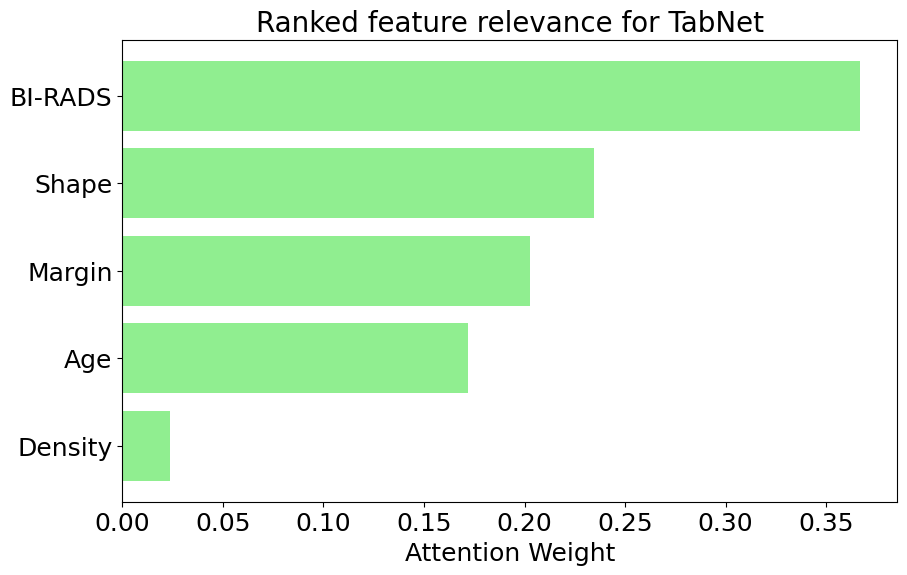

In [28]:
# visualising feature relevance by TabNet
sorted_features = [feature_names[idx] for idx in sorted_indices]
sorted_weights = [attention_weights[idx] for idx in sorted_indices]
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='lightgreen')
plt.gca().tick_params( labelsize=18)
plt.xlabel('Attention Weight', fontsize=18)
plt.title('Ranked feature relevance for TabNet', fontsize=20)
plt.gca().invert_yaxis()  
plt.show()

In [47]:
# 4. Rectifier network

# Hyperparameter optimization
param_dist = {
    'hidden_layer_sizes': [(8, 16), (16, 32), (8, 16, 32), (16, 32, 64), (32, 64, 128), (64, 128, 256),
    (32, 64, 128, 256), (64, 128, 256, 512), (128, 256, 512, 1024), (8, 16, 32, 64, 128), (16, 32, 64, 128, 256)],
    'max_iter': randint(1500, 3500),
    'early_stopping': [True],
    'n_iter_no_change': randint(100, 150),
    'validation_fraction': uniform(0.15, 0.25),
    'activation': ['relu'],
    'learning_rate_init': uniform(1e-5, 1e-3), 
    'alpha': uniform(1e-6, 1e-4),
    'beta_1': [0.9, 0.95, 0.85, 0.88],
    'beta_2': [0.999, 0.9999, 0.9995, 0.9999],
    'epsilon': [1e-8, 1e-9],
}

search_mlp = RandomizedSearchCV(
    MLPClassifier(random_state=random_state),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=1,
    scoring='f1'
)

# Rectifier network training
search_mlp.fit(X_train_scaled, y_train)
best_params_mlp = search_mlp.best_params_
print("Best Parameters for MLP:", best_params_mlp)
print("Best f1 score for rectifier network during training: ",  search_mlp.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for MLP: {'activation': 'relu', 'alpha': 6.469897343583279e-05, 'beta_1': 0.88, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-09, 'hidden_layer_sizes': (128, 256, 512, 1024), 'learning_rate_init': 0.0007879746966350879, 'max_iter': 2494, 'n_iter_no_change': 148, 'validation_fraction': 0.3238996921063466}
Best f1 score for rectifier network during training:  0.8211744617624511


In [48]:
# Rectifier network Testing
best_mlp_model =search_mlp.best_estimator_
y_pred_mlp =best_mlp_model.predict(X_test_scaled)

# Rectifier network Performance Evaluation
print("\nEvaluation Metrics for Rectifier Network:")
accuracy = accuracy_score(y_test, y_pred_mlp)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_mlp)
print("Precision:", precision)
recall= recall_score(y_test, y_pred_mlp)
print("Recall:", recall)
f1= f1_score(y_test, best_mlp_model.predict(X_test))
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_mlp, beta=2)
print("F2 Score:", f_beta)
auc = roc_auc_score(y_test, best_mlp_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for Rectifier Network:
Accuracy: 0.8192771084337349
Precision: 0.7931034482758621
Recall: 0.8518518518518519
F1 Score: 0.6558704453441295
F2 Score: 0.8394160583941606
AUC: 0.8640522875816994


C:\Users\de_de\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [49]:
#feed fwd weights:
def mlp_relu_interpretation(model, x):
    w_list, b_list = model.coefs_, model.intercepts_

    layers = range(len(w_list))
    layer_j = np.copy(x)
    activation_pattern = []
    for j in layers:
        if j == len(w_list) - 1:
            continue
        layer_j = layer_j @ w_list[j] + b_list[j]
        layer_j[layer_j <= 0] = 0
        activation_pattern.extend(np.where(layer_j > 0))

    for j in layers:
        if j == 0:
            feature_weights_layer = w_list[j][:, activation_pattern[j]]
            intercepts_layer = b_list[j][activation_pattern[j]]
        elif 0 < j < len(w_list) - 1:
            layer_j_w_active_input = w_list[j][activation_pattern[j-1], :]
            layer_j_w_active_output = layer_j_w_active_input[:, activation_pattern[j]]
            feature_weights_layer = feature_weights_layer @ layer_j_w_active_output
            intercepts_layer = intercepts_layer @ layer_j_w_active_output + b_list[j][activation_pattern[j]]
        elif j == len(w_list) - 1:
            layer_j_w_active_input = w_list[j][activation_pattern[j-1], :]
            feature_weights_layer = feature_weights_layer @ layer_j_w_active_input
            intercepts_layer = intercepts_layer @ layer_j_w_active_input + b_list[j]

    return feature_weights_layer, intercepts_layer

In [50]:
# Model prediction and  feed fwd weights(Local linear models) extraction- Interpretability
prediction = best_mlp_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")
feature_weights, intercepts = mlp_relu_interpretation(best_mlp_model, instance_to_explain)
feature_weights_tuples = [(feature_index, weight) for feature_index, weight in enumerate(feature_weights.flatten())]
sorted_feature_weights = sorted(feature_weights_tuples, key=lambda x: abs(x[1]), reverse=True)
feature_index_to_name = {i: name for i, name in enumerate(feature_names)}
sorted_feature_names = [feature_index_to_name.get(index, f'Unknown Feature {index}') for index, _ in sorted_feature_weights]
absolute_weights = [abs(weight) for _, weight in sorted_feature_weights]

Model Prediction: 0


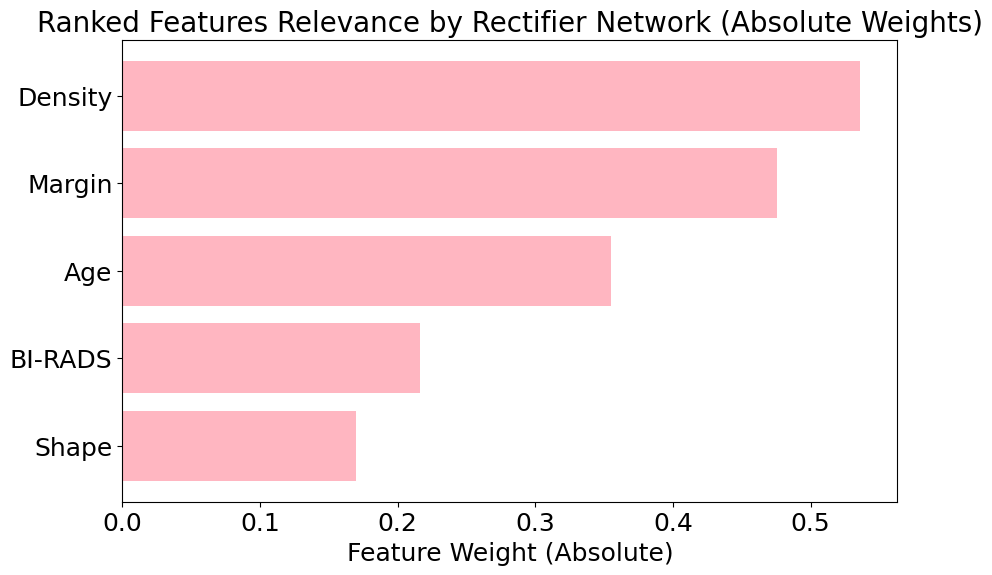

In [51]:
# Visualisation feature relevance by rectifier network
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, absolute_weights, color='lightpink')  
plt.gca().tick_params(labelsize=18) 
plt.xlabel('Feature Weight (Absolute)', fontsize=18)  
plt.title('Ranked Features Relevance by Rectifier Network (Absolute Weights)', fontsize=20)  
plt.gca().invert_yaxis()  
plt.show()